# TODO:

* Calcular información mutua para todos los ficheros con resoluciones grandes <b style='color: green'>DONE</b>
* Función transferencia info, que es copiar la de informacion mutua y devolver dividiendo entre la entropia <b style='color: green'>DONE</b>
* Calcular información mutua para todos los ficheros utilizando los bursts como codificación <b style='color: orange'>DOING</b>
* Graficas interspike

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from utils import *
import pickle

In [ ]:
from_files = ["./DatosSinapsisArtificial/TrozoC_bin.csv",
              "./DatosSinapsisArtificial/TrozoR_bin.csv",
              "./DatosSinapsisArtificial/TrozoG_bin.csv"]
cols = [["LP_burst", "VD_burst"],
        ["LP_burst", "VD_burst"],
        ["LP_burst", "VD_burst"]]
bin_cols = [["LP_bin", "VD_bin"],
            ["LP_bin", "VD_bin"],
            ["LP_bin", "VD_bin"]]
to_files = ["dataC_burst.pkl",
            "dataR_burst.pkl",
            "dataG_burst.pkl"]
thresholds = [1000,1000,1000]
resolutions = [2000, 2000, 2000]
word_lens = [8, 8, 8]
col_names = [f"word_len {i}" for i in range(max(word_lens))]
row_names = [f"resolution {i}" for i in range(max(resolutions))]
for n in range(len(from_files)):
    df = pd.read_csv(from_files[n])[bin_cols[n]]
    df = get_bursts(df, thresholds[n], bin_cols[n], cols[n])[cols[n]]
    df = df.astype({cols[n][0]:'u1', cols[n][0]:'u1'})
    try:
        with open(to_files[n], "rb") as f:
            data = pickle.load(f)
    except FileNotFoundError:
        data = {
            "transfer_info_col1_col2" : pd.DataFrame(columns = col_names, index = row_names),
            "transfer_info_col2_col1" : pd.DataFrame(columns = col_names, index = row_names),
            "mutual_info" : pd.DataFrame(columns = col_names, index = row_names),
            "col1_entropy" : pd.DataFrame(columns = col_names, index = row_names),
            "col2_entropy" : pd.DataFrame(columns = col_names, index = row_names),
            "joined_entropy" : pd.DataFrame(columns = col_names, index = row_names)
        }
        data["transfer_info_col1_col2"][:] = 0
        data["transfer_info_col2_col1"][:] = 0
        data["mutual_info"][:] = 0
        data["col1_entropy"][:] = 0
        data["col2_entropy"][:] = 0
        data["joined_entropy"][:] = 0
    for i in range(resolutions[n]):
        for j in range(word_lens[n]):
            if (data["transfer_info_col1_col2"].loc[row_names[i], col_names[j]] != 0 and
                data["transfer_info_col2_col1"].loc[row_names[i], col_names[j]] != 0 and
                data["mutual_info"].loc[row_names[i], col_names[j]] != 0 and
                data["col1_entropy"].loc[row_names[i], col_names[j]] != 0 and
                data["col2_entropy"].loc[row_names[i], col_names[j]] != 0 and
                data["joined_entropy"].loc[row_names[i], col_names[j]] != 0):
                print(f"Previamente calculado {to_files[n]}: resolución={i+1}, palabra={j+1} en la posicion[{i}][{j}]")
                continue
            print(f"Comienzo cálculo resolución={i+1}, palabra={j+1} en la posicion[{i}][{j}]")
            tr, mi, e, ej = transfer_info(resolution(df, i+1), cols[n], j+1)
            data["transfer_info_col1_col2"].loc[row_names[i], col_names[j]] = tr[0]
            data["transfer_info_col2_col1"].loc[row_names[i], col_names[j]] = tr[1]
            data["mutual_info"].loc[row_names[i], col_names[j]] = mi
            data["col1_entropy"].loc[row_names[i], col_names[j]] = e[0]
            data["col2_entropy"].loc[row_names[i], col_names[j]] = e[1]
            data["joined_entropy"].loc[row_names[i], col_names[j]] = ej
            print(f"Calculado {to_files[n]}: resolución={i+1}, palabra={j+1} en la posicion[{i}][{j}]")
            with open(to_files[n], "wb") as f:
                pickle.dump(data, f)

Previamente calculado dataC_burst.pkl: resolución=1, palabra=1 en la posicion[0][0]
Previamente calculado dataC_burst.pkl: resolución=1, palabra=2 en la posicion[0][1]
Previamente calculado dataC_burst.pkl: resolución=1, palabra=3 en la posicion[0][2]
Previamente calculado dataC_burst.pkl: resolución=1, palabra=4 en la posicion[0][3]
Previamente calculado dataC_burst.pkl: resolución=1, palabra=5 en la posicion[0][4]
Previamente calculado dataC_burst.pkl: resolución=1, palabra=6 en la posicion[0][5]
Previamente calculado dataC_burst.pkl: resolución=1, palabra=7 en la posicion[0][6]
Previamente calculado dataC_burst.pkl: resolución=1, palabra=8 en la posicion[0][7]
Previamente calculado dataC_burst.pkl: resolución=2, palabra=1 en la posicion[1][0]
Previamente calculado dataC_burst.pkl: resolución=2, palabra=2 en la posicion[1][1]
Previamente calculado dataC_burst.pkl: resolución=2, palabra=3 en la posicion[1][2]
Previamente calculado dataC_burst.pkl: resolución=2, palabra=4 en la posicio

Calculado dataC_burst.pkl: resolución=157, palabra=6 en la posicion[156][5]
Comienzo cálculo resolución=157, palabra=7 en la posicion[156][6]
Calculado dataC_burst.pkl: resolución=157, palabra=7 en la posicion[156][6]
Comienzo cálculo resolución=157, palabra=8 en la posicion[156][7]
Calculado dataC_burst.pkl: resolución=157, palabra=8 en la posicion[156][7]
Comienzo cálculo resolución=158, palabra=1 en la posicion[157][0]
Calculado dataC_burst.pkl: resolución=158, palabra=1 en la posicion[157][0]
Comienzo cálculo resolución=158, palabra=2 en la posicion[157][1]
Calculado dataC_burst.pkl: resolución=158, palabra=2 en la posicion[157][1]
Comienzo cálculo resolución=158, palabra=3 en la posicion[157][2]
Calculado dataC_burst.pkl: resolución=158, palabra=3 en la posicion[157][2]
Comienzo cálculo resolución=158, palabra=4 en la posicion[157][3]
Calculado dataC_burst.pkl: resolución=158, palabra=4 en la posicion[157][3]
Comienzo cálculo resolución=158, palabra=5 en la posicion[157][4]
Calcul

Calculado dataC_burst.pkl: resolución=164, palabra=8 en la posicion[163][7]
Comienzo cálculo resolución=165, palabra=1 en la posicion[164][0]
Calculado dataC_burst.pkl: resolución=165, palabra=1 en la posicion[164][0]
Comienzo cálculo resolución=165, palabra=2 en la posicion[164][1]
Calculado dataC_burst.pkl: resolución=165, palabra=2 en la posicion[164][1]
Comienzo cálculo resolución=165, palabra=3 en la posicion[164][2]
Calculado dataC_burst.pkl: resolución=165, palabra=3 en la posicion[164][2]
Comienzo cálculo resolución=165, palabra=4 en la posicion[164][3]
Calculado dataC_burst.pkl: resolución=165, palabra=4 en la posicion[164][3]
Comienzo cálculo resolución=165, palabra=5 en la posicion[164][4]
Calculado dataC_burst.pkl: resolución=165, palabra=5 en la posicion[164][4]
Comienzo cálculo resolución=165, palabra=6 en la posicion[164][5]
Calculado dataC_burst.pkl: resolución=165, palabra=6 en la posicion[164][5]
Comienzo cálculo resolución=165, palabra=7 en la posicion[164][6]
Calcul

Calculado dataC_burst.pkl: resolución=172, palabra=2 en la posicion[171][1]
Comienzo cálculo resolución=172, palabra=3 en la posicion[171][2]
Calculado dataC_burst.pkl: resolución=172, palabra=3 en la posicion[171][2]
Comienzo cálculo resolución=172, palabra=4 en la posicion[171][3]
Calculado dataC_burst.pkl: resolución=172, palabra=4 en la posicion[171][3]
Comienzo cálculo resolución=172, palabra=5 en la posicion[171][4]
Calculado dataC_burst.pkl: resolución=172, palabra=5 en la posicion[171][4]
Comienzo cálculo resolución=172, palabra=6 en la posicion[171][5]
Calculado dataC_burst.pkl: resolución=172, palabra=6 en la posicion[171][5]
Comienzo cálculo resolución=172, palabra=7 en la posicion[171][6]
Calculado dataC_burst.pkl: resolución=172, palabra=7 en la posicion[171][6]
Comienzo cálculo resolución=172, palabra=8 en la posicion[171][7]
Calculado dataC_burst.pkl: resolución=172, palabra=8 en la posicion[171][7]
Comienzo cálculo resolución=173, palabra=1 en la posicion[172][0]
Calcul

Calculado dataC_burst.pkl: resolución=179, palabra=4 en la posicion[178][3]
Comienzo cálculo resolución=179, palabra=5 en la posicion[178][4]
Calculado dataC_burst.pkl: resolución=179, palabra=5 en la posicion[178][4]
Comienzo cálculo resolución=179, palabra=6 en la posicion[178][5]
Calculado dataC_burst.pkl: resolución=179, palabra=6 en la posicion[178][5]
Comienzo cálculo resolución=179, palabra=7 en la posicion[178][6]
Calculado dataC_burst.pkl: resolución=179, palabra=7 en la posicion[178][6]
Comienzo cálculo resolución=179, palabra=8 en la posicion[178][7]
Calculado dataC_burst.pkl: resolución=179, palabra=8 en la posicion[178][7]
Comienzo cálculo resolución=180, palabra=1 en la posicion[179][0]
Calculado dataC_burst.pkl: resolución=180, palabra=1 en la posicion[179][0]
Comienzo cálculo resolución=180, palabra=2 en la posicion[179][1]
Calculado dataC_burst.pkl: resolución=180, palabra=2 en la posicion[179][1]
Comienzo cálculo resolución=180, palabra=3 en la posicion[179][2]
Calcul

Calculado dataC_burst.pkl: resolución=186, palabra=6 en la posicion[185][5]
Comienzo cálculo resolución=186, palabra=7 en la posicion[185][6]
Calculado dataC_burst.pkl: resolución=186, palabra=7 en la posicion[185][6]
Comienzo cálculo resolución=186, palabra=8 en la posicion[185][7]
Calculado dataC_burst.pkl: resolución=186, palabra=8 en la posicion[185][7]
Comienzo cálculo resolución=187, palabra=1 en la posicion[186][0]
Calculado dataC_burst.pkl: resolución=187, palabra=1 en la posicion[186][0]
Comienzo cálculo resolución=187, palabra=2 en la posicion[186][1]
Calculado dataC_burst.pkl: resolución=187, palabra=2 en la posicion[186][1]
Comienzo cálculo resolución=187, palabra=3 en la posicion[186][2]
Calculado dataC_burst.pkl: resolución=187, palabra=3 en la posicion[186][2]
Comienzo cálculo resolución=187, palabra=4 en la posicion[186][3]
Calculado dataC_burst.pkl: resolución=187, palabra=4 en la posicion[186][3]
Comienzo cálculo resolución=187, palabra=5 en la posicion[186][4]
Calcul

Calculado dataC_burst.pkl: resolución=193, palabra=8 en la posicion[192][7]
Comienzo cálculo resolución=194, palabra=1 en la posicion[193][0]
Calculado dataC_burst.pkl: resolución=194, palabra=1 en la posicion[193][0]
Comienzo cálculo resolución=194, palabra=2 en la posicion[193][1]
Calculado dataC_burst.pkl: resolución=194, palabra=2 en la posicion[193][1]
Comienzo cálculo resolución=194, palabra=3 en la posicion[193][2]
Calculado dataC_burst.pkl: resolución=194, palabra=3 en la posicion[193][2]
Comienzo cálculo resolución=194, palabra=4 en la posicion[193][3]
Calculado dataC_burst.pkl: resolución=194, palabra=4 en la posicion[193][3]
Comienzo cálculo resolución=194, palabra=5 en la posicion[193][4]
Calculado dataC_burst.pkl: resolución=194, palabra=5 en la posicion[193][4]
Comienzo cálculo resolución=194, palabra=6 en la posicion[193][5]
Calculado dataC_burst.pkl: resolución=194, palabra=6 en la posicion[193][5]
Comienzo cálculo resolución=194, palabra=7 en la posicion[193][6]
Calcul

Calculado dataC_burst.pkl: resolución=201, palabra=2 en la posicion[200][1]
Comienzo cálculo resolución=201, palabra=3 en la posicion[200][2]
Calculado dataC_burst.pkl: resolución=201, palabra=3 en la posicion[200][2]
Comienzo cálculo resolución=201, palabra=4 en la posicion[200][3]
Calculado dataC_burst.pkl: resolución=201, palabra=4 en la posicion[200][3]
Comienzo cálculo resolución=201, palabra=5 en la posicion[200][4]
Calculado dataC_burst.pkl: resolución=201, palabra=5 en la posicion[200][4]
Comienzo cálculo resolución=201, palabra=6 en la posicion[200][5]
Calculado dataC_burst.pkl: resolución=201, palabra=6 en la posicion[200][5]
Comienzo cálculo resolución=201, palabra=7 en la posicion[200][6]
Calculado dataC_burst.pkl: resolución=201, palabra=7 en la posicion[200][6]
Comienzo cálculo resolución=201, palabra=8 en la posicion[200][7]
Calculado dataC_burst.pkl: resolución=201, palabra=8 en la posicion[200][7]
Comienzo cálculo resolución=202, palabra=1 en la posicion[201][0]
Calcul

Calculado dataC_burst.pkl: resolución=208, palabra=4 en la posicion[207][3]
Comienzo cálculo resolución=208, palabra=5 en la posicion[207][4]
Calculado dataC_burst.pkl: resolución=208, palabra=5 en la posicion[207][4]
Comienzo cálculo resolución=208, palabra=6 en la posicion[207][5]
Calculado dataC_burst.pkl: resolución=208, palabra=6 en la posicion[207][5]
Comienzo cálculo resolución=208, palabra=7 en la posicion[207][6]
Calculado dataC_burst.pkl: resolución=208, palabra=7 en la posicion[207][6]
Comienzo cálculo resolución=208, palabra=8 en la posicion[207][7]
Calculado dataC_burst.pkl: resolución=208, palabra=8 en la posicion[207][7]
Comienzo cálculo resolución=209, palabra=1 en la posicion[208][0]
Calculado dataC_burst.pkl: resolución=209, palabra=1 en la posicion[208][0]
Comienzo cálculo resolución=209, palabra=2 en la posicion[208][1]
Calculado dataC_burst.pkl: resolución=209, palabra=2 en la posicion[208][1]
Comienzo cálculo resolución=209, palabra=3 en la posicion[208][2]
Calcul

Calculado dataC_burst.pkl: resolución=215, palabra=6 en la posicion[214][5]
Comienzo cálculo resolución=215, palabra=7 en la posicion[214][6]
Calculado dataC_burst.pkl: resolución=215, palabra=7 en la posicion[214][6]
Comienzo cálculo resolución=215, palabra=8 en la posicion[214][7]
Calculado dataC_burst.pkl: resolución=215, palabra=8 en la posicion[214][7]
Comienzo cálculo resolución=216, palabra=1 en la posicion[215][0]
Calculado dataC_burst.pkl: resolución=216, palabra=1 en la posicion[215][0]
Comienzo cálculo resolución=216, palabra=2 en la posicion[215][1]
Calculado dataC_burst.pkl: resolución=216, palabra=2 en la posicion[215][1]
Comienzo cálculo resolución=216, palabra=3 en la posicion[215][2]
Calculado dataC_burst.pkl: resolución=216, palabra=3 en la posicion[215][2]
Comienzo cálculo resolución=216, palabra=4 en la posicion[215][3]
Calculado dataC_burst.pkl: resolución=216, palabra=4 en la posicion[215][3]
Comienzo cálculo resolución=216, palabra=5 en la posicion[215][4]
Calcul

Calculado dataC_burst.pkl: resolución=222, palabra=8 en la posicion[221][7]
Comienzo cálculo resolución=223, palabra=1 en la posicion[222][0]
Calculado dataC_burst.pkl: resolución=223, palabra=1 en la posicion[222][0]
Comienzo cálculo resolución=223, palabra=2 en la posicion[222][1]
Calculado dataC_burst.pkl: resolución=223, palabra=2 en la posicion[222][1]
Comienzo cálculo resolución=223, palabra=3 en la posicion[222][2]
Calculado dataC_burst.pkl: resolución=223, palabra=3 en la posicion[222][2]
Comienzo cálculo resolución=223, palabra=4 en la posicion[222][3]
Calculado dataC_burst.pkl: resolución=223, palabra=4 en la posicion[222][3]
Comienzo cálculo resolución=223, palabra=5 en la posicion[222][4]
Calculado dataC_burst.pkl: resolución=223, palabra=5 en la posicion[222][4]
Comienzo cálculo resolución=223, palabra=6 en la posicion[222][5]
Calculado dataC_burst.pkl: resolución=223, palabra=6 en la posicion[222][5]
Comienzo cálculo resolución=223, palabra=7 en la posicion[222][6]
Calcul

Calculado dataC_burst.pkl: resolución=230, palabra=2 en la posicion[229][1]
Comienzo cálculo resolución=230, palabra=3 en la posicion[229][2]
Calculado dataC_burst.pkl: resolución=230, palabra=3 en la posicion[229][2]
Comienzo cálculo resolución=230, palabra=4 en la posicion[229][3]
Calculado dataC_burst.pkl: resolución=230, palabra=4 en la posicion[229][3]
Comienzo cálculo resolución=230, palabra=5 en la posicion[229][4]
Calculado dataC_burst.pkl: resolución=230, palabra=5 en la posicion[229][4]
Comienzo cálculo resolución=230, palabra=6 en la posicion[229][5]
Calculado dataC_burst.pkl: resolución=230, palabra=6 en la posicion[229][5]
Comienzo cálculo resolución=230, palabra=7 en la posicion[229][6]
Calculado dataC_burst.pkl: resolución=230, palabra=7 en la posicion[229][6]
Comienzo cálculo resolución=230, palabra=8 en la posicion[229][7]
Calculado dataC_burst.pkl: resolución=230, palabra=8 en la posicion[229][7]
Comienzo cálculo resolución=231, palabra=1 en la posicion[230][0]
Calcul

Calculado dataC_burst.pkl: resolución=237, palabra=4 en la posicion[236][3]
Comienzo cálculo resolución=237, palabra=5 en la posicion[236][4]
Calculado dataC_burst.pkl: resolución=237, palabra=5 en la posicion[236][4]
Comienzo cálculo resolución=237, palabra=6 en la posicion[236][5]
Calculado dataC_burst.pkl: resolución=237, palabra=6 en la posicion[236][5]
Comienzo cálculo resolución=237, palabra=7 en la posicion[236][6]
Calculado dataC_burst.pkl: resolución=237, palabra=7 en la posicion[236][6]
Comienzo cálculo resolución=237, palabra=8 en la posicion[236][7]
Calculado dataC_burst.pkl: resolución=237, palabra=8 en la posicion[236][7]
Comienzo cálculo resolución=238, palabra=1 en la posicion[237][0]
Calculado dataC_burst.pkl: resolución=238, palabra=1 en la posicion[237][0]
Comienzo cálculo resolución=238, palabra=2 en la posicion[237][1]
Calculado dataC_burst.pkl: resolución=238, palabra=2 en la posicion[237][1]
Comienzo cálculo resolución=238, palabra=3 en la posicion[237][2]
Calcul

Calculado dataC_burst.pkl: resolución=244, palabra=6 en la posicion[243][5]
Comienzo cálculo resolución=244, palabra=7 en la posicion[243][6]
Calculado dataC_burst.pkl: resolución=244, palabra=7 en la posicion[243][6]
Comienzo cálculo resolución=244, palabra=8 en la posicion[243][7]
Calculado dataC_burst.pkl: resolución=244, palabra=8 en la posicion[243][7]
Comienzo cálculo resolución=245, palabra=1 en la posicion[244][0]
Calculado dataC_burst.pkl: resolución=245, palabra=1 en la posicion[244][0]
Comienzo cálculo resolución=245, palabra=2 en la posicion[244][1]
Calculado dataC_burst.pkl: resolución=245, palabra=2 en la posicion[244][1]
Comienzo cálculo resolución=245, palabra=3 en la posicion[244][2]
Calculado dataC_burst.pkl: resolución=245, palabra=3 en la posicion[244][2]
Comienzo cálculo resolución=245, palabra=4 en la posicion[244][3]
Calculado dataC_burst.pkl: resolución=245, palabra=4 en la posicion[244][3]
Comienzo cálculo resolución=245, palabra=5 en la posicion[244][4]
Calcul

Calculado dataC_burst.pkl: resolución=251, palabra=8 en la posicion[250][7]
Comienzo cálculo resolución=252, palabra=1 en la posicion[251][0]
Calculado dataC_burst.pkl: resolución=252, palabra=1 en la posicion[251][0]
Comienzo cálculo resolución=252, palabra=2 en la posicion[251][1]
Calculado dataC_burst.pkl: resolución=252, palabra=2 en la posicion[251][1]
Comienzo cálculo resolución=252, palabra=3 en la posicion[251][2]
Calculado dataC_burst.pkl: resolución=252, palabra=3 en la posicion[251][2]
Comienzo cálculo resolución=252, palabra=4 en la posicion[251][3]
Calculado dataC_burst.pkl: resolución=252, palabra=4 en la posicion[251][3]
Comienzo cálculo resolución=252, palabra=5 en la posicion[251][4]
Calculado dataC_burst.pkl: resolución=252, palabra=5 en la posicion[251][4]
Comienzo cálculo resolución=252, palabra=6 en la posicion[251][5]
Calculado dataC_burst.pkl: resolución=252, palabra=6 en la posicion[251][5]
Comienzo cálculo resolución=252, palabra=7 en la posicion[251][6]
Calcul

Calculado dataC_burst.pkl: resolución=259, palabra=2 en la posicion[258][1]
Comienzo cálculo resolución=259, palabra=3 en la posicion[258][2]
Calculado dataC_burst.pkl: resolución=259, palabra=3 en la posicion[258][2]
Comienzo cálculo resolución=259, palabra=4 en la posicion[258][3]
Calculado dataC_burst.pkl: resolución=259, palabra=4 en la posicion[258][3]
Comienzo cálculo resolución=259, palabra=5 en la posicion[258][4]
Calculado dataC_burst.pkl: resolución=259, palabra=5 en la posicion[258][4]
Comienzo cálculo resolución=259, palabra=6 en la posicion[258][5]
Calculado dataC_burst.pkl: resolución=259, palabra=6 en la posicion[258][5]
Comienzo cálculo resolución=259, palabra=7 en la posicion[258][6]
Calculado dataC_burst.pkl: resolución=259, palabra=7 en la posicion[258][6]
Comienzo cálculo resolución=259, palabra=8 en la posicion[258][7]
Calculado dataC_burst.pkl: resolución=259, palabra=8 en la posicion[258][7]
Comienzo cálculo resolución=260, palabra=1 en la posicion[259][0]
Calcul

Calculado dataC_burst.pkl: resolución=266, palabra=4 en la posicion[265][3]
Comienzo cálculo resolución=266, palabra=5 en la posicion[265][4]
Calculado dataC_burst.pkl: resolución=266, palabra=5 en la posicion[265][4]
Comienzo cálculo resolución=266, palabra=6 en la posicion[265][5]
Calculado dataC_burst.pkl: resolución=266, palabra=6 en la posicion[265][5]
Comienzo cálculo resolución=266, palabra=7 en la posicion[265][6]
Calculado dataC_burst.pkl: resolución=266, palabra=7 en la posicion[265][6]
Comienzo cálculo resolución=266, palabra=8 en la posicion[265][7]
Calculado dataC_burst.pkl: resolución=266, palabra=8 en la posicion[265][7]
Comienzo cálculo resolución=267, palabra=1 en la posicion[266][0]
Calculado dataC_burst.pkl: resolución=267, palabra=1 en la posicion[266][0]
Comienzo cálculo resolución=267, palabra=2 en la posicion[266][1]
Calculado dataC_burst.pkl: resolución=267, palabra=2 en la posicion[266][1]
Comienzo cálculo resolución=267, palabra=3 en la posicion[266][2]
Calcul

Calculado dataC_burst.pkl: resolución=273, palabra=6 en la posicion[272][5]
Comienzo cálculo resolución=273, palabra=7 en la posicion[272][6]
Calculado dataC_burst.pkl: resolución=273, palabra=7 en la posicion[272][6]
Comienzo cálculo resolución=273, palabra=8 en la posicion[272][7]
Calculado dataC_burst.pkl: resolución=273, palabra=8 en la posicion[272][7]
Comienzo cálculo resolución=274, palabra=1 en la posicion[273][0]
Calculado dataC_burst.pkl: resolución=274, palabra=1 en la posicion[273][0]
Comienzo cálculo resolución=274, palabra=2 en la posicion[273][1]
Calculado dataC_burst.pkl: resolución=274, palabra=2 en la posicion[273][1]
Comienzo cálculo resolución=274, palabra=3 en la posicion[273][2]
Calculado dataC_burst.pkl: resolución=274, palabra=3 en la posicion[273][2]
Comienzo cálculo resolución=274, palabra=4 en la posicion[273][3]
Calculado dataC_burst.pkl: resolución=274, palabra=4 en la posicion[273][3]
Comienzo cálculo resolución=274, palabra=5 en la posicion[273][4]
Calcul

Calculado dataC_burst.pkl: resolución=280, palabra=8 en la posicion[279][7]
Comienzo cálculo resolución=281, palabra=1 en la posicion[280][0]
Calculado dataC_burst.pkl: resolución=281, palabra=1 en la posicion[280][0]
Comienzo cálculo resolución=281, palabra=2 en la posicion[280][1]
Calculado dataC_burst.pkl: resolución=281, palabra=2 en la posicion[280][1]
Comienzo cálculo resolución=281, palabra=3 en la posicion[280][2]
Calculado dataC_burst.pkl: resolución=281, palabra=3 en la posicion[280][2]
Comienzo cálculo resolución=281, palabra=4 en la posicion[280][3]
Calculado dataC_burst.pkl: resolución=281, palabra=4 en la posicion[280][3]
Comienzo cálculo resolución=281, palabra=5 en la posicion[280][4]
Calculado dataC_burst.pkl: resolución=281, palabra=5 en la posicion[280][4]
Comienzo cálculo resolución=281, palabra=6 en la posicion[280][5]
Calculado dataC_burst.pkl: resolución=281, palabra=6 en la posicion[280][5]
Comienzo cálculo resolución=281, palabra=7 en la posicion[280][6]
Calcul

Calculado dataC_burst.pkl: resolución=288, palabra=2 en la posicion[287][1]
Comienzo cálculo resolución=288, palabra=3 en la posicion[287][2]
Calculado dataC_burst.pkl: resolución=288, palabra=3 en la posicion[287][2]
Comienzo cálculo resolución=288, palabra=4 en la posicion[287][3]
Calculado dataC_burst.pkl: resolución=288, palabra=4 en la posicion[287][3]
Comienzo cálculo resolución=288, palabra=5 en la posicion[287][4]
Calculado dataC_burst.pkl: resolución=288, palabra=5 en la posicion[287][4]
Comienzo cálculo resolución=288, palabra=6 en la posicion[287][5]
Calculado dataC_burst.pkl: resolución=288, palabra=6 en la posicion[287][5]
Comienzo cálculo resolución=288, palabra=7 en la posicion[287][6]
Calculado dataC_burst.pkl: resolución=288, palabra=7 en la posicion[287][6]
Comienzo cálculo resolución=288, palabra=8 en la posicion[287][7]
Calculado dataC_burst.pkl: resolución=288, palabra=8 en la posicion[287][7]
Comienzo cálculo resolución=289, palabra=1 en la posicion[288][0]
Calcul

Calculado dataC_burst.pkl: resolución=295, palabra=4 en la posicion[294][3]
Comienzo cálculo resolución=295, palabra=5 en la posicion[294][4]
Calculado dataC_burst.pkl: resolución=295, palabra=5 en la posicion[294][4]
Comienzo cálculo resolución=295, palabra=6 en la posicion[294][5]
Calculado dataC_burst.pkl: resolución=295, palabra=6 en la posicion[294][5]
Comienzo cálculo resolución=295, palabra=7 en la posicion[294][6]
Calculado dataC_burst.pkl: resolución=295, palabra=7 en la posicion[294][6]
Comienzo cálculo resolución=295, palabra=8 en la posicion[294][7]
Calculado dataC_burst.pkl: resolución=295, palabra=8 en la posicion[294][7]
Comienzo cálculo resolución=296, palabra=1 en la posicion[295][0]
Calculado dataC_burst.pkl: resolución=296, palabra=1 en la posicion[295][0]
Comienzo cálculo resolución=296, palabra=2 en la posicion[295][1]
Calculado dataC_burst.pkl: resolución=296, palabra=2 en la posicion[295][1]
Comienzo cálculo resolución=296, palabra=3 en la posicion[295][2]
Calcul

Calculado dataC_burst.pkl: resolución=302, palabra=6 en la posicion[301][5]
Comienzo cálculo resolución=302, palabra=7 en la posicion[301][6]
Calculado dataC_burst.pkl: resolución=302, palabra=7 en la posicion[301][6]
Comienzo cálculo resolución=302, palabra=8 en la posicion[301][7]
Calculado dataC_burst.pkl: resolución=302, palabra=8 en la posicion[301][7]
Comienzo cálculo resolución=303, palabra=1 en la posicion[302][0]
Calculado dataC_burst.pkl: resolución=303, palabra=1 en la posicion[302][0]
Comienzo cálculo resolución=303, palabra=2 en la posicion[302][1]
Calculado dataC_burst.pkl: resolución=303, palabra=2 en la posicion[302][1]
Comienzo cálculo resolución=303, palabra=3 en la posicion[302][2]
Calculado dataC_burst.pkl: resolución=303, palabra=3 en la posicion[302][2]
Comienzo cálculo resolución=303, palabra=4 en la posicion[302][3]
Calculado dataC_burst.pkl: resolución=303, palabra=4 en la posicion[302][3]
Comienzo cálculo resolución=303, palabra=5 en la posicion[302][4]
Calcul

Calculado dataC_burst.pkl: resolución=309, palabra=8 en la posicion[308][7]
Comienzo cálculo resolución=310, palabra=1 en la posicion[309][0]
Calculado dataC_burst.pkl: resolución=310, palabra=1 en la posicion[309][0]
Comienzo cálculo resolución=310, palabra=2 en la posicion[309][1]
Calculado dataC_burst.pkl: resolución=310, palabra=2 en la posicion[309][1]
Comienzo cálculo resolución=310, palabra=3 en la posicion[309][2]
Calculado dataC_burst.pkl: resolución=310, palabra=3 en la posicion[309][2]
Comienzo cálculo resolución=310, palabra=4 en la posicion[309][3]
Calculado dataC_burst.pkl: resolución=310, palabra=4 en la posicion[309][3]
Comienzo cálculo resolución=310, palabra=5 en la posicion[309][4]
Calculado dataC_burst.pkl: resolución=310, palabra=5 en la posicion[309][4]
Comienzo cálculo resolución=310, palabra=6 en la posicion[309][5]
Calculado dataC_burst.pkl: resolución=310, palabra=6 en la posicion[309][5]
Comienzo cálculo resolución=310, palabra=7 en la posicion[309][6]
Calcul

Calculado dataC_burst.pkl: resolución=317, palabra=2 en la posicion[316][1]
Comienzo cálculo resolución=317, palabra=3 en la posicion[316][2]
Calculado dataC_burst.pkl: resolución=317, palabra=3 en la posicion[316][2]
Comienzo cálculo resolución=317, palabra=4 en la posicion[316][3]
Calculado dataC_burst.pkl: resolución=317, palabra=4 en la posicion[316][3]
Comienzo cálculo resolución=317, palabra=5 en la posicion[316][4]
Calculado dataC_burst.pkl: resolución=317, palabra=5 en la posicion[316][4]
Comienzo cálculo resolución=317, palabra=6 en la posicion[316][5]
Calculado dataC_burst.pkl: resolución=317, palabra=6 en la posicion[316][5]
Comienzo cálculo resolución=317, palabra=7 en la posicion[316][6]
Calculado dataC_burst.pkl: resolución=317, palabra=7 en la posicion[316][6]
Comienzo cálculo resolución=317, palabra=8 en la posicion[316][7]
Calculado dataC_burst.pkl: resolución=317, palabra=8 en la posicion[316][7]
Comienzo cálculo resolución=318, palabra=1 en la posicion[317][0]
Calcul

Calculado dataC_burst.pkl: resolución=324, palabra=4 en la posicion[323][3]
Comienzo cálculo resolución=324, palabra=5 en la posicion[323][4]
Calculado dataC_burst.pkl: resolución=324, palabra=5 en la posicion[323][4]
Comienzo cálculo resolución=324, palabra=6 en la posicion[323][5]
Calculado dataC_burst.pkl: resolución=324, palabra=6 en la posicion[323][5]
Comienzo cálculo resolución=324, palabra=7 en la posicion[323][6]
Calculado dataC_burst.pkl: resolución=324, palabra=7 en la posicion[323][6]
Comienzo cálculo resolución=324, palabra=8 en la posicion[323][7]
Calculado dataC_burst.pkl: resolución=324, palabra=8 en la posicion[323][7]
Comienzo cálculo resolución=325, palabra=1 en la posicion[324][0]
Calculado dataC_burst.pkl: resolución=325, palabra=1 en la posicion[324][0]
Comienzo cálculo resolución=325, palabra=2 en la posicion[324][1]
Calculado dataC_burst.pkl: resolución=325, palabra=2 en la posicion[324][1]
Comienzo cálculo resolución=325, palabra=3 en la posicion[324][2]
Calcul

Calculado dataC_burst.pkl: resolución=331, palabra=6 en la posicion[330][5]
Comienzo cálculo resolución=331, palabra=7 en la posicion[330][6]
Calculado dataC_burst.pkl: resolución=331, palabra=7 en la posicion[330][6]
Comienzo cálculo resolución=331, palabra=8 en la posicion[330][7]
Calculado dataC_burst.pkl: resolución=331, palabra=8 en la posicion[330][7]
Comienzo cálculo resolución=332, palabra=1 en la posicion[331][0]
Calculado dataC_burst.pkl: resolución=332, palabra=1 en la posicion[331][0]
Comienzo cálculo resolución=332, palabra=2 en la posicion[331][1]
Calculado dataC_burst.pkl: resolución=332, palabra=2 en la posicion[331][1]
Comienzo cálculo resolución=332, palabra=3 en la posicion[331][2]
Calculado dataC_burst.pkl: resolución=332, palabra=3 en la posicion[331][2]
Comienzo cálculo resolución=332, palabra=4 en la posicion[331][3]
Calculado dataC_burst.pkl: resolución=332, palabra=4 en la posicion[331][3]
Comienzo cálculo resolución=332, palabra=5 en la posicion[331][4]
Calcul

Calculado dataC_burst.pkl: resolución=338, palabra=8 en la posicion[337][7]
Comienzo cálculo resolución=339, palabra=1 en la posicion[338][0]
Calculado dataC_burst.pkl: resolución=339, palabra=1 en la posicion[338][0]
Comienzo cálculo resolución=339, palabra=2 en la posicion[338][1]
Calculado dataC_burst.pkl: resolución=339, palabra=2 en la posicion[338][1]
Comienzo cálculo resolución=339, palabra=3 en la posicion[338][2]
Calculado dataC_burst.pkl: resolución=339, palabra=3 en la posicion[338][2]
Comienzo cálculo resolución=339, palabra=4 en la posicion[338][3]
Calculado dataC_burst.pkl: resolución=339, palabra=4 en la posicion[338][3]
Comienzo cálculo resolución=339, palabra=5 en la posicion[338][4]
Calculado dataC_burst.pkl: resolución=339, palabra=5 en la posicion[338][4]
Comienzo cálculo resolución=339, palabra=6 en la posicion[338][5]
Calculado dataC_burst.pkl: resolución=339, palabra=6 en la posicion[338][5]
Comienzo cálculo resolución=339, palabra=7 en la posicion[338][6]
Calcul

Calculado dataC_burst.pkl: resolución=346, palabra=2 en la posicion[345][1]
Comienzo cálculo resolución=346, palabra=3 en la posicion[345][2]
Calculado dataC_burst.pkl: resolución=346, palabra=3 en la posicion[345][2]
Comienzo cálculo resolución=346, palabra=4 en la posicion[345][3]
Calculado dataC_burst.pkl: resolución=346, palabra=4 en la posicion[345][3]
Comienzo cálculo resolución=346, palabra=5 en la posicion[345][4]
Calculado dataC_burst.pkl: resolución=346, palabra=5 en la posicion[345][4]
Comienzo cálculo resolución=346, palabra=6 en la posicion[345][5]
Calculado dataC_burst.pkl: resolución=346, palabra=6 en la posicion[345][5]
Comienzo cálculo resolución=346, palabra=7 en la posicion[345][6]
Calculado dataC_burst.pkl: resolución=346, palabra=7 en la posicion[345][6]
Comienzo cálculo resolución=346, palabra=8 en la posicion[345][7]
Calculado dataC_burst.pkl: resolución=346, palabra=8 en la posicion[345][7]
Comienzo cálculo resolución=347, palabra=1 en la posicion[346][0]
Calcul

Calculado dataC_burst.pkl: resolución=353, palabra=4 en la posicion[352][3]
Comienzo cálculo resolución=353, palabra=5 en la posicion[352][4]
Calculado dataC_burst.pkl: resolución=353, palabra=5 en la posicion[352][4]
Comienzo cálculo resolución=353, palabra=6 en la posicion[352][5]
Calculado dataC_burst.pkl: resolución=353, palabra=6 en la posicion[352][5]
Comienzo cálculo resolución=353, palabra=7 en la posicion[352][6]
Calculado dataC_burst.pkl: resolución=353, palabra=7 en la posicion[352][6]
Comienzo cálculo resolución=353, palabra=8 en la posicion[352][7]
Calculado dataC_burst.pkl: resolución=353, palabra=8 en la posicion[352][7]
Comienzo cálculo resolución=354, palabra=1 en la posicion[353][0]
Calculado dataC_burst.pkl: resolución=354, palabra=1 en la posicion[353][0]
Comienzo cálculo resolución=354, palabra=2 en la posicion[353][1]
Calculado dataC_burst.pkl: resolución=354, palabra=2 en la posicion[353][1]
Comienzo cálculo resolución=354, palabra=3 en la posicion[353][2]
Calcul

Calculado dataC_burst.pkl: resolución=360, palabra=6 en la posicion[359][5]
Comienzo cálculo resolución=360, palabra=7 en la posicion[359][6]
Calculado dataC_burst.pkl: resolución=360, palabra=7 en la posicion[359][6]
Comienzo cálculo resolución=360, palabra=8 en la posicion[359][7]
Calculado dataC_burst.pkl: resolución=360, palabra=8 en la posicion[359][7]
Comienzo cálculo resolución=361, palabra=1 en la posicion[360][0]
Calculado dataC_burst.pkl: resolución=361, palabra=1 en la posicion[360][0]
Comienzo cálculo resolución=361, palabra=2 en la posicion[360][1]
Calculado dataC_burst.pkl: resolución=361, palabra=2 en la posicion[360][1]
Comienzo cálculo resolución=361, palabra=3 en la posicion[360][2]
Calculado dataC_burst.pkl: resolución=361, palabra=3 en la posicion[360][2]
Comienzo cálculo resolución=361, palabra=4 en la posicion[360][3]
Calculado dataC_burst.pkl: resolución=361, palabra=4 en la posicion[360][3]
Comienzo cálculo resolución=361, palabra=5 en la posicion[360][4]
Calcul

Calculado dataC_burst.pkl: resolución=367, palabra=8 en la posicion[366][7]
Comienzo cálculo resolución=368, palabra=1 en la posicion[367][0]
Calculado dataC_burst.pkl: resolución=368, palabra=1 en la posicion[367][0]
Comienzo cálculo resolución=368, palabra=2 en la posicion[367][1]
Calculado dataC_burst.pkl: resolución=368, palabra=2 en la posicion[367][1]
Comienzo cálculo resolución=368, palabra=3 en la posicion[367][2]
Calculado dataC_burst.pkl: resolución=368, palabra=3 en la posicion[367][2]
Comienzo cálculo resolución=368, palabra=4 en la posicion[367][3]
Calculado dataC_burst.pkl: resolución=368, palabra=4 en la posicion[367][3]
Comienzo cálculo resolución=368, palabra=5 en la posicion[367][4]
Calculado dataC_burst.pkl: resolución=368, palabra=5 en la posicion[367][4]
Comienzo cálculo resolución=368, palabra=6 en la posicion[367][5]
Calculado dataC_burst.pkl: resolución=368, palabra=6 en la posicion[367][5]
Comienzo cálculo resolución=368, palabra=7 en la posicion[367][6]
Calcul

Calculado dataC_burst.pkl: resolución=375, palabra=2 en la posicion[374][1]
Comienzo cálculo resolución=375, palabra=3 en la posicion[374][2]
Calculado dataC_burst.pkl: resolución=375, palabra=3 en la posicion[374][2]
Comienzo cálculo resolución=375, palabra=4 en la posicion[374][3]
Calculado dataC_burst.pkl: resolución=375, palabra=4 en la posicion[374][3]
Comienzo cálculo resolución=375, palabra=5 en la posicion[374][4]
Calculado dataC_burst.pkl: resolución=375, palabra=5 en la posicion[374][4]
Comienzo cálculo resolución=375, palabra=6 en la posicion[374][5]
Calculado dataC_burst.pkl: resolución=375, palabra=6 en la posicion[374][5]
Comienzo cálculo resolución=375, palabra=7 en la posicion[374][6]
Calculado dataC_burst.pkl: resolución=375, palabra=7 en la posicion[374][6]
Comienzo cálculo resolución=375, palabra=8 en la posicion[374][7]
Calculado dataC_burst.pkl: resolución=375, palabra=8 en la posicion[374][7]
Comienzo cálculo resolución=376, palabra=1 en la posicion[375][0]
Calcul

Calculado dataC_burst.pkl: resolución=382, palabra=4 en la posicion[381][3]
Comienzo cálculo resolución=382, palabra=5 en la posicion[381][4]
Calculado dataC_burst.pkl: resolución=382, palabra=5 en la posicion[381][4]
Comienzo cálculo resolución=382, palabra=6 en la posicion[381][5]
Calculado dataC_burst.pkl: resolución=382, palabra=6 en la posicion[381][5]
Comienzo cálculo resolución=382, palabra=7 en la posicion[381][6]
Calculado dataC_burst.pkl: resolución=382, palabra=7 en la posicion[381][6]
Comienzo cálculo resolución=382, palabra=8 en la posicion[381][7]
Calculado dataC_burst.pkl: resolución=382, palabra=8 en la posicion[381][7]
Comienzo cálculo resolución=383, palabra=1 en la posicion[382][0]
Calculado dataC_burst.pkl: resolución=383, palabra=1 en la posicion[382][0]
Comienzo cálculo resolución=383, palabra=2 en la posicion[382][1]
Calculado dataC_burst.pkl: resolución=383, palabra=2 en la posicion[382][1]
Comienzo cálculo resolución=383, palabra=3 en la posicion[382][2]
Calcul

Calculado dataC_burst.pkl: resolución=389, palabra=6 en la posicion[388][5]
Comienzo cálculo resolución=389, palabra=7 en la posicion[388][6]
Calculado dataC_burst.pkl: resolución=389, palabra=7 en la posicion[388][6]
Comienzo cálculo resolución=389, palabra=8 en la posicion[388][7]
Calculado dataC_burst.pkl: resolución=389, palabra=8 en la posicion[388][7]
Comienzo cálculo resolución=390, palabra=1 en la posicion[389][0]
Calculado dataC_burst.pkl: resolución=390, palabra=1 en la posicion[389][0]
Comienzo cálculo resolución=390, palabra=2 en la posicion[389][1]
Calculado dataC_burst.pkl: resolución=390, palabra=2 en la posicion[389][1]
Comienzo cálculo resolución=390, palabra=3 en la posicion[389][2]
Calculado dataC_burst.pkl: resolución=390, palabra=3 en la posicion[389][2]
Comienzo cálculo resolución=390, palabra=4 en la posicion[389][3]
Calculado dataC_burst.pkl: resolución=390, palabra=4 en la posicion[389][3]
Comienzo cálculo resolución=390, palabra=5 en la posicion[389][4]
Calcul

Calculado dataC_burst.pkl: resolución=396, palabra=8 en la posicion[395][7]
Comienzo cálculo resolución=397, palabra=1 en la posicion[396][0]
Calculado dataC_burst.pkl: resolución=397, palabra=1 en la posicion[396][0]
Comienzo cálculo resolución=397, palabra=2 en la posicion[396][1]
Calculado dataC_burst.pkl: resolución=397, palabra=2 en la posicion[396][1]
Comienzo cálculo resolución=397, palabra=3 en la posicion[396][2]
Calculado dataC_burst.pkl: resolución=397, palabra=3 en la posicion[396][2]
Comienzo cálculo resolución=397, palabra=4 en la posicion[396][3]
Calculado dataC_burst.pkl: resolución=397, palabra=4 en la posicion[396][3]
Comienzo cálculo resolución=397, palabra=5 en la posicion[396][4]
Calculado dataC_burst.pkl: resolución=397, palabra=5 en la posicion[396][4]
Comienzo cálculo resolución=397, palabra=6 en la posicion[396][5]
Calculado dataC_burst.pkl: resolución=397, palabra=6 en la posicion[396][5]
Comienzo cálculo resolución=397, palabra=7 en la posicion[396][6]
Calcul

Calculado dataC_burst.pkl: resolución=404, palabra=2 en la posicion[403][1]
Comienzo cálculo resolución=404, palabra=3 en la posicion[403][2]
Calculado dataC_burst.pkl: resolución=404, palabra=3 en la posicion[403][2]
Comienzo cálculo resolución=404, palabra=4 en la posicion[403][3]
Calculado dataC_burst.pkl: resolución=404, palabra=4 en la posicion[403][3]
Comienzo cálculo resolución=404, palabra=5 en la posicion[403][4]
Calculado dataC_burst.pkl: resolución=404, palabra=5 en la posicion[403][4]
Comienzo cálculo resolución=404, palabra=6 en la posicion[403][5]
Calculado dataC_burst.pkl: resolución=404, palabra=6 en la posicion[403][5]
Comienzo cálculo resolución=404, palabra=7 en la posicion[403][6]
Calculado dataC_burst.pkl: resolución=404, palabra=7 en la posicion[403][6]
Comienzo cálculo resolución=404, palabra=8 en la posicion[403][7]
Calculado dataC_burst.pkl: resolución=404, palabra=8 en la posicion[403][7]
Comienzo cálculo resolución=405, palabra=1 en la posicion[404][0]
Calcul

Calculado dataC_burst.pkl: resolución=411, palabra=4 en la posicion[410][3]
Comienzo cálculo resolución=411, palabra=5 en la posicion[410][4]
Calculado dataC_burst.pkl: resolución=411, palabra=5 en la posicion[410][4]
Comienzo cálculo resolución=411, palabra=6 en la posicion[410][5]
Calculado dataC_burst.pkl: resolución=411, palabra=6 en la posicion[410][5]
Comienzo cálculo resolución=411, palabra=7 en la posicion[410][6]
Calculado dataC_burst.pkl: resolución=411, palabra=7 en la posicion[410][6]
Comienzo cálculo resolución=411, palabra=8 en la posicion[410][7]
Calculado dataC_burst.pkl: resolución=411, palabra=8 en la posicion[410][7]
Comienzo cálculo resolución=412, palabra=1 en la posicion[411][0]
Calculado dataC_burst.pkl: resolución=412, palabra=1 en la posicion[411][0]
Comienzo cálculo resolución=412, palabra=2 en la posicion[411][1]
Calculado dataC_burst.pkl: resolución=412, palabra=2 en la posicion[411][1]
Comienzo cálculo resolución=412, palabra=3 en la posicion[411][2]
Calcul

Calculado dataC_burst.pkl: resolución=418, palabra=6 en la posicion[417][5]
Comienzo cálculo resolución=418, palabra=7 en la posicion[417][6]
Calculado dataC_burst.pkl: resolución=418, palabra=7 en la posicion[417][6]
Comienzo cálculo resolución=418, palabra=8 en la posicion[417][7]
Calculado dataC_burst.pkl: resolución=418, palabra=8 en la posicion[417][7]
Comienzo cálculo resolución=419, palabra=1 en la posicion[418][0]
Calculado dataC_burst.pkl: resolución=419, palabra=1 en la posicion[418][0]
Comienzo cálculo resolución=419, palabra=2 en la posicion[418][1]
Calculado dataC_burst.pkl: resolución=419, palabra=2 en la posicion[418][1]
Comienzo cálculo resolución=419, palabra=3 en la posicion[418][2]
Calculado dataC_burst.pkl: resolución=419, palabra=3 en la posicion[418][2]
Comienzo cálculo resolución=419, palabra=4 en la posicion[418][3]
Calculado dataC_burst.pkl: resolución=419, palabra=4 en la posicion[418][3]
Comienzo cálculo resolución=419, palabra=5 en la posicion[418][4]
Calcul

Calculado dataC_burst.pkl: resolución=425, palabra=8 en la posicion[424][7]
Comienzo cálculo resolución=426, palabra=1 en la posicion[425][0]
Calculado dataC_burst.pkl: resolución=426, palabra=1 en la posicion[425][0]
Comienzo cálculo resolución=426, palabra=2 en la posicion[425][1]
Calculado dataC_burst.pkl: resolución=426, palabra=2 en la posicion[425][1]
Comienzo cálculo resolución=426, palabra=3 en la posicion[425][2]
Calculado dataC_burst.pkl: resolución=426, palabra=3 en la posicion[425][2]
Comienzo cálculo resolución=426, palabra=4 en la posicion[425][3]
Calculado dataC_burst.pkl: resolución=426, palabra=4 en la posicion[425][3]
Comienzo cálculo resolución=426, palabra=5 en la posicion[425][4]
Calculado dataC_burst.pkl: resolución=426, palabra=5 en la posicion[425][4]
Comienzo cálculo resolución=426, palabra=6 en la posicion[425][5]
Calculado dataC_burst.pkl: resolución=426, palabra=6 en la posicion[425][5]
Comienzo cálculo resolución=426, palabra=7 en la posicion[425][6]
Calcul

Calculado dataC_burst.pkl: resolución=433, palabra=2 en la posicion[432][1]
Comienzo cálculo resolución=433, palabra=3 en la posicion[432][2]
Calculado dataC_burst.pkl: resolución=433, palabra=3 en la posicion[432][2]
Comienzo cálculo resolución=433, palabra=4 en la posicion[432][3]
Calculado dataC_burst.pkl: resolución=433, palabra=4 en la posicion[432][3]
Comienzo cálculo resolución=433, palabra=5 en la posicion[432][4]
Calculado dataC_burst.pkl: resolución=433, palabra=5 en la posicion[432][4]
Comienzo cálculo resolución=433, palabra=6 en la posicion[432][5]
Calculado dataC_burst.pkl: resolución=433, palabra=6 en la posicion[432][5]
Comienzo cálculo resolución=433, palabra=7 en la posicion[432][6]
Calculado dataC_burst.pkl: resolución=433, palabra=7 en la posicion[432][6]
Comienzo cálculo resolución=433, palabra=8 en la posicion[432][7]
Calculado dataC_burst.pkl: resolución=433, palabra=8 en la posicion[432][7]
Comienzo cálculo resolución=434, palabra=1 en la posicion[433][0]
Calcul

Calculado dataC_burst.pkl: resolución=440, palabra=4 en la posicion[439][3]
Comienzo cálculo resolución=440, palabra=5 en la posicion[439][4]
Calculado dataC_burst.pkl: resolución=440, palabra=5 en la posicion[439][4]
Comienzo cálculo resolución=440, palabra=6 en la posicion[439][5]
Calculado dataC_burst.pkl: resolución=440, palabra=6 en la posicion[439][5]
Comienzo cálculo resolución=440, palabra=7 en la posicion[439][6]
Calculado dataC_burst.pkl: resolución=440, palabra=7 en la posicion[439][6]
Comienzo cálculo resolución=440, palabra=8 en la posicion[439][7]
Calculado dataC_burst.pkl: resolución=440, palabra=8 en la posicion[439][7]
Comienzo cálculo resolución=441, palabra=1 en la posicion[440][0]
Calculado dataC_burst.pkl: resolución=441, palabra=1 en la posicion[440][0]
Comienzo cálculo resolución=441, palabra=2 en la posicion[440][1]
Calculado dataC_burst.pkl: resolución=441, palabra=2 en la posicion[440][1]
Comienzo cálculo resolución=441, palabra=3 en la posicion[440][2]
Calcul

Calculado dataC_burst.pkl: resolución=447, palabra=6 en la posicion[446][5]
Comienzo cálculo resolución=447, palabra=7 en la posicion[446][6]
Calculado dataC_burst.pkl: resolución=447, palabra=7 en la posicion[446][6]
Comienzo cálculo resolución=447, palabra=8 en la posicion[446][7]
Calculado dataC_burst.pkl: resolución=447, palabra=8 en la posicion[446][7]
Comienzo cálculo resolución=448, palabra=1 en la posicion[447][0]
Calculado dataC_burst.pkl: resolución=448, palabra=1 en la posicion[447][0]
Comienzo cálculo resolución=448, palabra=2 en la posicion[447][1]
Calculado dataC_burst.pkl: resolución=448, palabra=2 en la posicion[447][1]
Comienzo cálculo resolución=448, palabra=3 en la posicion[447][2]
Calculado dataC_burst.pkl: resolución=448, palabra=3 en la posicion[447][2]
Comienzo cálculo resolución=448, palabra=4 en la posicion[447][3]
Calculado dataC_burst.pkl: resolución=448, palabra=4 en la posicion[447][3]
Comienzo cálculo resolución=448, palabra=5 en la posicion[447][4]
Calcul

Calculado dataC_burst.pkl: resolución=454, palabra=8 en la posicion[453][7]
Comienzo cálculo resolución=455, palabra=1 en la posicion[454][0]
Calculado dataC_burst.pkl: resolución=455, palabra=1 en la posicion[454][0]
Comienzo cálculo resolución=455, palabra=2 en la posicion[454][1]
Calculado dataC_burst.pkl: resolución=455, palabra=2 en la posicion[454][1]
Comienzo cálculo resolución=455, palabra=3 en la posicion[454][2]
Calculado dataC_burst.pkl: resolución=455, palabra=3 en la posicion[454][2]
Comienzo cálculo resolución=455, palabra=4 en la posicion[454][3]
Calculado dataC_burst.pkl: resolución=455, palabra=4 en la posicion[454][3]
Comienzo cálculo resolución=455, palabra=5 en la posicion[454][4]
Calculado dataC_burst.pkl: resolución=455, palabra=5 en la posicion[454][4]
Comienzo cálculo resolución=455, palabra=6 en la posicion[454][5]
Calculado dataC_burst.pkl: resolución=455, palabra=6 en la posicion[454][5]
Comienzo cálculo resolución=455, palabra=7 en la posicion[454][6]
Calcul

Calculado dataC_burst.pkl: resolución=462, palabra=2 en la posicion[461][1]
Comienzo cálculo resolución=462, palabra=3 en la posicion[461][2]
Calculado dataC_burst.pkl: resolución=462, palabra=3 en la posicion[461][2]
Comienzo cálculo resolución=462, palabra=4 en la posicion[461][3]
Calculado dataC_burst.pkl: resolución=462, palabra=4 en la posicion[461][3]
Comienzo cálculo resolución=462, palabra=5 en la posicion[461][4]
Calculado dataC_burst.pkl: resolución=462, palabra=5 en la posicion[461][4]
Comienzo cálculo resolución=462, palabra=6 en la posicion[461][5]
Calculado dataC_burst.pkl: resolución=462, palabra=6 en la posicion[461][5]
Comienzo cálculo resolución=462, palabra=7 en la posicion[461][6]
Calculado dataC_burst.pkl: resolución=462, palabra=7 en la posicion[461][6]
Comienzo cálculo resolución=462, palabra=8 en la posicion[461][7]
Calculado dataC_burst.pkl: resolución=462, palabra=8 en la posicion[461][7]
Comienzo cálculo resolución=463, palabra=1 en la posicion[462][0]
Calcul

Calculado dataC_burst.pkl: resolución=469, palabra=4 en la posicion[468][3]
Comienzo cálculo resolución=469, palabra=5 en la posicion[468][4]
Calculado dataC_burst.pkl: resolución=469, palabra=5 en la posicion[468][4]
Comienzo cálculo resolución=469, palabra=6 en la posicion[468][5]
Calculado dataC_burst.pkl: resolución=469, palabra=6 en la posicion[468][5]
Comienzo cálculo resolución=469, palabra=7 en la posicion[468][6]
Calculado dataC_burst.pkl: resolución=469, palabra=7 en la posicion[468][6]
Comienzo cálculo resolución=469, palabra=8 en la posicion[468][7]
Calculado dataC_burst.pkl: resolución=469, palabra=8 en la posicion[468][7]
Comienzo cálculo resolución=470, palabra=1 en la posicion[469][0]
Calculado dataC_burst.pkl: resolución=470, palabra=1 en la posicion[469][0]
Comienzo cálculo resolución=470, palabra=2 en la posicion[469][1]
Calculado dataC_burst.pkl: resolución=470, palabra=2 en la posicion[469][1]
Comienzo cálculo resolución=470, palabra=3 en la posicion[469][2]
Calcul

Calculado dataC_burst.pkl: resolución=476, palabra=6 en la posicion[475][5]
Comienzo cálculo resolución=476, palabra=7 en la posicion[475][6]
Calculado dataC_burst.pkl: resolución=476, palabra=7 en la posicion[475][6]
Comienzo cálculo resolución=476, palabra=8 en la posicion[475][7]
Calculado dataC_burst.pkl: resolución=476, palabra=8 en la posicion[475][7]
Comienzo cálculo resolución=477, palabra=1 en la posicion[476][0]
Calculado dataC_burst.pkl: resolución=477, palabra=1 en la posicion[476][0]
Comienzo cálculo resolución=477, palabra=2 en la posicion[476][1]
Calculado dataC_burst.pkl: resolución=477, palabra=2 en la posicion[476][1]
Comienzo cálculo resolución=477, palabra=3 en la posicion[476][2]
Calculado dataC_burst.pkl: resolución=477, palabra=3 en la posicion[476][2]
Comienzo cálculo resolución=477, palabra=4 en la posicion[476][3]
Calculado dataC_burst.pkl: resolución=477, palabra=4 en la posicion[476][3]
Comienzo cálculo resolución=477, palabra=5 en la posicion[476][4]
Calcul

Calculado dataC_burst.pkl: resolución=483, palabra=8 en la posicion[482][7]
Comienzo cálculo resolución=484, palabra=1 en la posicion[483][0]
Calculado dataC_burst.pkl: resolución=484, palabra=1 en la posicion[483][0]
Comienzo cálculo resolución=484, palabra=2 en la posicion[483][1]
Calculado dataC_burst.pkl: resolución=484, palabra=2 en la posicion[483][1]
Comienzo cálculo resolución=484, palabra=3 en la posicion[483][2]
Calculado dataC_burst.pkl: resolución=484, palabra=3 en la posicion[483][2]
Comienzo cálculo resolución=484, palabra=4 en la posicion[483][3]
Calculado dataC_burst.pkl: resolución=484, palabra=4 en la posicion[483][3]
Comienzo cálculo resolución=484, palabra=5 en la posicion[483][4]
Calculado dataC_burst.pkl: resolución=484, palabra=5 en la posicion[483][4]
Comienzo cálculo resolución=484, palabra=6 en la posicion[483][5]
Calculado dataC_burst.pkl: resolución=484, palabra=6 en la posicion[483][5]
Comienzo cálculo resolución=484, palabra=7 en la posicion[483][6]
Calcul

Calculado dataC_burst.pkl: resolución=491, palabra=2 en la posicion[490][1]
Comienzo cálculo resolución=491, palabra=3 en la posicion[490][2]
Calculado dataC_burst.pkl: resolución=491, palabra=3 en la posicion[490][2]
Comienzo cálculo resolución=491, palabra=4 en la posicion[490][3]
Calculado dataC_burst.pkl: resolución=491, palabra=4 en la posicion[490][3]
Comienzo cálculo resolución=491, palabra=5 en la posicion[490][4]
Calculado dataC_burst.pkl: resolución=491, palabra=5 en la posicion[490][4]
Comienzo cálculo resolución=491, palabra=6 en la posicion[490][5]
Calculado dataC_burst.pkl: resolución=491, palabra=6 en la posicion[490][5]
Comienzo cálculo resolución=491, palabra=7 en la posicion[490][6]
Calculado dataC_burst.pkl: resolución=491, palabra=7 en la posicion[490][6]
Comienzo cálculo resolución=491, palabra=8 en la posicion[490][7]
Calculado dataC_burst.pkl: resolución=491, palabra=8 en la posicion[490][7]
Comienzo cálculo resolución=492, palabra=1 en la posicion[491][0]
Calcul

Calculado dataC_burst.pkl: resolución=498, palabra=4 en la posicion[497][3]
Comienzo cálculo resolución=498, palabra=5 en la posicion[497][4]
Calculado dataC_burst.pkl: resolución=498, palabra=5 en la posicion[497][4]
Comienzo cálculo resolución=498, palabra=6 en la posicion[497][5]
Calculado dataC_burst.pkl: resolución=498, palabra=6 en la posicion[497][5]
Comienzo cálculo resolución=498, palabra=7 en la posicion[497][6]
Calculado dataC_burst.pkl: resolución=498, palabra=7 en la posicion[497][6]
Comienzo cálculo resolución=498, palabra=8 en la posicion[497][7]
Calculado dataC_burst.pkl: resolución=498, palabra=8 en la posicion[497][7]
Comienzo cálculo resolución=499, palabra=1 en la posicion[498][0]
Calculado dataC_burst.pkl: resolución=499, palabra=1 en la posicion[498][0]
Comienzo cálculo resolución=499, palabra=2 en la posicion[498][1]
Calculado dataC_burst.pkl: resolución=499, palabra=2 en la posicion[498][1]
Comienzo cálculo resolución=499, palabra=3 en la posicion[498][2]
Calcul

Calculado dataC_burst.pkl: resolución=505, palabra=6 en la posicion[504][5]
Comienzo cálculo resolución=505, palabra=7 en la posicion[504][6]
Calculado dataC_burst.pkl: resolución=505, palabra=7 en la posicion[504][6]
Comienzo cálculo resolución=505, palabra=8 en la posicion[504][7]
Calculado dataC_burst.pkl: resolución=505, palabra=8 en la posicion[504][7]
Comienzo cálculo resolución=506, palabra=1 en la posicion[505][0]
Calculado dataC_burst.pkl: resolución=506, palabra=1 en la posicion[505][0]
Comienzo cálculo resolución=506, palabra=2 en la posicion[505][1]
Calculado dataC_burst.pkl: resolución=506, palabra=2 en la posicion[505][1]
Comienzo cálculo resolución=506, palabra=3 en la posicion[505][2]
Calculado dataC_burst.pkl: resolución=506, palabra=3 en la posicion[505][2]
Comienzo cálculo resolución=506, palabra=4 en la posicion[505][3]
Calculado dataC_burst.pkl: resolución=506, palabra=4 en la posicion[505][3]
Comienzo cálculo resolución=506, palabra=5 en la posicion[505][4]
Calcul

Calculado dataC_burst.pkl: resolución=512, palabra=8 en la posicion[511][7]
Comienzo cálculo resolución=513, palabra=1 en la posicion[512][0]
Calculado dataC_burst.pkl: resolución=513, palabra=1 en la posicion[512][0]
Comienzo cálculo resolución=513, palabra=2 en la posicion[512][1]
Calculado dataC_burst.pkl: resolución=513, palabra=2 en la posicion[512][1]
Comienzo cálculo resolución=513, palabra=3 en la posicion[512][2]
Calculado dataC_burst.pkl: resolución=513, palabra=3 en la posicion[512][2]
Comienzo cálculo resolución=513, palabra=4 en la posicion[512][3]
Calculado dataC_burst.pkl: resolución=513, palabra=4 en la posicion[512][3]
Comienzo cálculo resolución=513, palabra=5 en la posicion[512][4]
Calculado dataC_burst.pkl: resolución=513, palabra=5 en la posicion[512][4]
Comienzo cálculo resolución=513, palabra=6 en la posicion[512][5]
Calculado dataC_burst.pkl: resolución=513, palabra=6 en la posicion[512][5]
Comienzo cálculo resolución=513, palabra=7 en la posicion[512][6]
Calcul

Calculado dataC_burst.pkl: resolución=520, palabra=2 en la posicion[519][1]
Comienzo cálculo resolución=520, palabra=3 en la posicion[519][2]
Calculado dataC_burst.pkl: resolución=520, palabra=3 en la posicion[519][2]
Comienzo cálculo resolución=520, palabra=4 en la posicion[519][3]
Calculado dataC_burst.pkl: resolución=520, palabra=4 en la posicion[519][3]
Comienzo cálculo resolución=520, palabra=5 en la posicion[519][4]
Calculado dataC_burst.pkl: resolución=520, palabra=5 en la posicion[519][4]
Comienzo cálculo resolución=520, palabra=6 en la posicion[519][5]
Calculado dataC_burst.pkl: resolución=520, palabra=6 en la posicion[519][5]
Comienzo cálculo resolución=520, palabra=7 en la posicion[519][6]
Calculado dataC_burst.pkl: resolución=520, palabra=7 en la posicion[519][6]
Comienzo cálculo resolución=520, palabra=8 en la posicion[519][7]
Calculado dataC_burst.pkl: resolución=520, palabra=8 en la posicion[519][7]
Comienzo cálculo resolución=521, palabra=1 en la posicion[520][0]
Calcul

Calculado dataC_burst.pkl: resolución=527, palabra=4 en la posicion[526][3]
Comienzo cálculo resolución=527, palabra=5 en la posicion[526][4]
Calculado dataC_burst.pkl: resolución=527, palabra=5 en la posicion[526][4]
Comienzo cálculo resolución=527, palabra=6 en la posicion[526][5]
Calculado dataC_burst.pkl: resolución=527, palabra=6 en la posicion[526][5]
Comienzo cálculo resolución=527, palabra=7 en la posicion[526][6]
Calculado dataC_burst.pkl: resolución=527, palabra=7 en la posicion[526][6]
Comienzo cálculo resolución=527, palabra=8 en la posicion[526][7]
Calculado dataC_burst.pkl: resolución=527, palabra=8 en la posicion[526][7]
Comienzo cálculo resolución=528, palabra=1 en la posicion[527][0]
Calculado dataC_burst.pkl: resolución=528, palabra=1 en la posicion[527][0]
Comienzo cálculo resolución=528, palabra=2 en la posicion[527][1]
Calculado dataC_burst.pkl: resolución=528, palabra=2 en la posicion[527][1]
Comienzo cálculo resolución=528, palabra=3 en la posicion[527][2]
Calcul

Calculado dataC_burst.pkl: resolución=534, palabra=6 en la posicion[533][5]
Comienzo cálculo resolución=534, palabra=7 en la posicion[533][6]
Calculado dataC_burst.pkl: resolución=534, palabra=7 en la posicion[533][6]
Comienzo cálculo resolución=534, palabra=8 en la posicion[533][7]
Calculado dataC_burst.pkl: resolución=534, palabra=8 en la posicion[533][7]
Comienzo cálculo resolución=535, palabra=1 en la posicion[534][0]
Calculado dataC_burst.pkl: resolución=535, palabra=1 en la posicion[534][0]
Comienzo cálculo resolución=535, palabra=2 en la posicion[534][1]
Calculado dataC_burst.pkl: resolución=535, palabra=2 en la posicion[534][1]
Comienzo cálculo resolución=535, palabra=3 en la posicion[534][2]
Calculado dataC_burst.pkl: resolución=535, palabra=3 en la posicion[534][2]
Comienzo cálculo resolución=535, palabra=4 en la posicion[534][3]
Calculado dataC_burst.pkl: resolución=535, palabra=4 en la posicion[534][3]
Comienzo cálculo resolución=535, palabra=5 en la posicion[534][4]
Calcul

Calculado dataC_burst.pkl: resolución=541, palabra=8 en la posicion[540][7]
Comienzo cálculo resolución=542, palabra=1 en la posicion[541][0]
Calculado dataC_burst.pkl: resolución=542, palabra=1 en la posicion[541][0]
Comienzo cálculo resolución=542, palabra=2 en la posicion[541][1]
Calculado dataC_burst.pkl: resolución=542, palabra=2 en la posicion[541][1]
Comienzo cálculo resolución=542, palabra=3 en la posicion[541][2]
Calculado dataC_burst.pkl: resolución=542, palabra=3 en la posicion[541][2]
Comienzo cálculo resolución=542, palabra=4 en la posicion[541][3]
Calculado dataC_burst.pkl: resolución=542, palabra=4 en la posicion[541][3]
Comienzo cálculo resolución=542, palabra=5 en la posicion[541][4]
Calculado dataC_burst.pkl: resolución=542, palabra=5 en la posicion[541][4]
Comienzo cálculo resolución=542, palabra=6 en la posicion[541][5]
Calculado dataC_burst.pkl: resolución=542, palabra=6 en la posicion[541][5]
Comienzo cálculo resolución=542, palabra=7 en la posicion[541][6]
Calcul

Calculado dataC_burst.pkl: resolución=549, palabra=2 en la posicion[548][1]
Comienzo cálculo resolución=549, palabra=3 en la posicion[548][2]
Calculado dataC_burst.pkl: resolución=549, palabra=3 en la posicion[548][2]
Comienzo cálculo resolución=549, palabra=4 en la posicion[548][3]
Calculado dataC_burst.pkl: resolución=549, palabra=4 en la posicion[548][3]
Comienzo cálculo resolución=549, palabra=5 en la posicion[548][4]
Calculado dataC_burst.pkl: resolución=549, palabra=5 en la posicion[548][4]
Comienzo cálculo resolución=549, palabra=6 en la posicion[548][5]
Calculado dataC_burst.pkl: resolución=549, palabra=6 en la posicion[548][5]
Comienzo cálculo resolución=549, palabra=7 en la posicion[548][6]
Calculado dataC_burst.pkl: resolución=549, palabra=7 en la posicion[548][6]
Comienzo cálculo resolución=549, palabra=8 en la posicion[548][7]
Calculado dataC_burst.pkl: resolución=549, palabra=8 en la posicion[548][7]
Comienzo cálculo resolución=550, palabra=1 en la posicion[549][0]
Calcul

Calculado dataC_burst.pkl: resolución=556, palabra=4 en la posicion[555][3]
Comienzo cálculo resolución=556, palabra=5 en la posicion[555][4]
Calculado dataC_burst.pkl: resolución=556, palabra=5 en la posicion[555][4]
Comienzo cálculo resolución=556, palabra=6 en la posicion[555][5]
Calculado dataC_burst.pkl: resolución=556, palabra=6 en la posicion[555][5]
Comienzo cálculo resolución=556, palabra=7 en la posicion[555][6]
Calculado dataC_burst.pkl: resolución=556, palabra=7 en la posicion[555][6]
Comienzo cálculo resolución=556, palabra=8 en la posicion[555][7]
Calculado dataC_burst.pkl: resolución=556, palabra=8 en la posicion[555][7]
Comienzo cálculo resolución=557, palabra=1 en la posicion[556][0]
Calculado dataC_burst.pkl: resolución=557, palabra=1 en la posicion[556][0]
Comienzo cálculo resolución=557, palabra=2 en la posicion[556][1]
Calculado dataC_burst.pkl: resolución=557, palabra=2 en la posicion[556][1]
Comienzo cálculo resolución=557, palabra=3 en la posicion[556][2]
Calcul

Calculado dataC_burst.pkl: resolución=563, palabra=6 en la posicion[562][5]
Comienzo cálculo resolución=563, palabra=7 en la posicion[562][6]
Calculado dataC_burst.pkl: resolución=563, palabra=7 en la posicion[562][6]
Comienzo cálculo resolución=563, palabra=8 en la posicion[562][7]
Calculado dataC_burst.pkl: resolución=563, palabra=8 en la posicion[562][7]
Comienzo cálculo resolución=564, palabra=1 en la posicion[563][0]
Calculado dataC_burst.pkl: resolución=564, palabra=1 en la posicion[563][0]
Comienzo cálculo resolución=564, palabra=2 en la posicion[563][1]
Calculado dataC_burst.pkl: resolución=564, palabra=2 en la posicion[563][1]
Comienzo cálculo resolución=564, palabra=3 en la posicion[563][2]
Calculado dataC_burst.pkl: resolución=564, palabra=3 en la posicion[563][2]
Comienzo cálculo resolución=564, palabra=4 en la posicion[563][3]
Calculado dataC_burst.pkl: resolución=564, palabra=4 en la posicion[563][3]
Comienzo cálculo resolución=564, palabra=5 en la posicion[563][4]
Calcul

Calculado dataC_burst.pkl: resolución=570, palabra=8 en la posicion[569][7]
Comienzo cálculo resolución=571, palabra=1 en la posicion[570][0]
Calculado dataC_burst.pkl: resolución=571, palabra=1 en la posicion[570][0]
Comienzo cálculo resolución=571, palabra=2 en la posicion[570][1]
Calculado dataC_burst.pkl: resolución=571, palabra=2 en la posicion[570][1]
Comienzo cálculo resolución=571, palabra=3 en la posicion[570][2]
Calculado dataC_burst.pkl: resolución=571, palabra=3 en la posicion[570][2]
Comienzo cálculo resolución=571, palabra=4 en la posicion[570][3]
Calculado dataC_burst.pkl: resolución=571, palabra=4 en la posicion[570][3]
Comienzo cálculo resolución=571, palabra=5 en la posicion[570][4]
Calculado dataC_burst.pkl: resolución=571, palabra=5 en la posicion[570][4]
Comienzo cálculo resolución=571, palabra=6 en la posicion[570][5]
Calculado dataC_burst.pkl: resolución=571, palabra=6 en la posicion[570][5]
Comienzo cálculo resolución=571, palabra=7 en la posicion[570][6]
Calcul

Calculado dataC_burst.pkl: resolución=578, palabra=2 en la posicion[577][1]
Comienzo cálculo resolución=578, palabra=3 en la posicion[577][2]
Calculado dataC_burst.pkl: resolución=578, palabra=3 en la posicion[577][2]
Comienzo cálculo resolución=578, palabra=4 en la posicion[577][3]
Calculado dataC_burst.pkl: resolución=578, palabra=4 en la posicion[577][3]
Comienzo cálculo resolución=578, palabra=5 en la posicion[577][4]
Calculado dataC_burst.pkl: resolución=578, palabra=5 en la posicion[577][4]
Comienzo cálculo resolución=578, palabra=6 en la posicion[577][5]
Calculado dataC_burst.pkl: resolución=578, palabra=6 en la posicion[577][5]
Comienzo cálculo resolución=578, palabra=7 en la posicion[577][6]
Calculado dataC_burst.pkl: resolución=578, palabra=7 en la posicion[577][6]
Comienzo cálculo resolución=578, palabra=8 en la posicion[577][7]
Calculado dataC_burst.pkl: resolución=578, palabra=8 en la posicion[577][7]
Comienzo cálculo resolución=579, palabra=1 en la posicion[578][0]
Calcul

Calculado dataC_burst.pkl: resolución=585, palabra=4 en la posicion[584][3]
Comienzo cálculo resolución=585, palabra=5 en la posicion[584][4]
Calculado dataC_burst.pkl: resolución=585, palabra=5 en la posicion[584][4]
Comienzo cálculo resolución=585, palabra=6 en la posicion[584][5]
Calculado dataC_burst.pkl: resolución=585, palabra=6 en la posicion[584][5]
Comienzo cálculo resolución=585, palabra=7 en la posicion[584][6]
Calculado dataC_burst.pkl: resolución=585, palabra=7 en la posicion[584][6]
Comienzo cálculo resolución=585, palabra=8 en la posicion[584][7]
Calculado dataC_burst.pkl: resolución=585, palabra=8 en la posicion[584][7]
Comienzo cálculo resolución=586, palabra=1 en la posicion[585][0]
Calculado dataC_burst.pkl: resolución=586, palabra=1 en la posicion[585][0]
Comienzo cálculo resolución=586, palabra=2 en la posicion[585][1]
Calculado dataC_burst.pkl: resolución=586, palabra=2 en la posicion[585][1]
Comienzo cálculo resolución=586, palabra=3 en la posicion[585][2]
Calcul

Calculado dataC_burst.pkl: resolución=592, palabra=6 en la posicion[591][5]
Comienzo cálculo resolución=592, palabra=7 en la posicion[591][6]
Calculado dataC_burst.pkl: resolución=592, palabra=7 en la posicion[591][6]
Comienzo cálculo resolución=592, palabra=8 en la posicion[591][7]
Calculado dataC_burst.pkl: resolución=592, palabra=8 en la posicion[591][7]
Comienzo cálculo resolución=593, palabra=1 en la posicion[592][0]
Calculado dataC_burst.pkl: resolución=593, palabra=1 en la posicion[592][0]
Comienzo cálculo resolución=593, palabra=2 en la posicion[592][1]
Calculado dataC_burst.pkl: resolución=593, palabra=2 en la posicion[592][1]
Comienzo cálculo resolución=593, palabra=3 en la posicion[592][2]
Calculado dataC_burst.pkl: resolución=593, palabra=3 en la posicion[592][2]
Comienzo cálculo resolución=593, palabra=4 en la posicion[592][3]
Calculado dataC_burst.pkl: resolución=593, palabra=4 en la posicion[592][3]
Comienzo cálculo resolución=593, palabra=5 en la posicion[592][4]
Calcul

Calculado dataC_burst.pkl: resolución=599, palabra=8 en la posicion[598][7]
Comienzo cálculo resolución=600, palabra=1 en la posicion[599][0]
Calculado dataC_burst.pkl: resolución=600, palabra=1 en la posicion[599][0]
Comienzo cálculo resolución=600, palabra=2 en la posicion[599][1]
Calculado dataC_burst.pkl: resolución=600, palabra=2 en la posicion[599][1]
Comienzo cálculo resolución=600, palabra=3 en la posicion[599][2]
Calculado dataC_burst.pkl: resolución=600, palabra=3 en la posicion[599][2]
Comienzo cálculo resolución=600, palabra=4 en la posicion[599][3]
Calculado dataC_burst.pkl: resolución=600, palabra=4 en la posicion[599][3]
Comienzo cálculo resolución=600, palabra=5 en la posicion[599][4]
Calculado dataC_burst.pkl: resolución=600, palabra=5 en la posicion[599][4]
Comienzo cálculo resolución=600, palabra=6 en la posicion[599][5]
Calculado dataC_burst.pkl: resolución=600, palabra=6 en la posicion[599][5]
Comienzo cálculo resolución=600, palabra=7 en la posicion[599][6]
Calcul

Calculado dataC_burst.pkl: resolución=607, palabra=2 en la posicion[606][1]
Comienzo cálculo resolución=607, palabra=3 en la posicion[606][2]
Calculado dataC_burst.pkl: resolución=607, palabra=3 en la posicion[606][2]
Comienzo cálculo resolución=607, palabra=4 en la posicion[606][3]
Calculado dataC_burst.pkl: resolución=607, palabra=4 en la posicion[606][3]
Comienzo cálculo resolución=607, palabra=5 en la posicion[606][4]
Calculado dataC_burst.pkl: resolución=607, palabra=5 en la posicion[606][4]
Comienzo cálculo resolución=607, palabra=6 en la posicion[606][5]
Calculado dataC_burst.pkl: resolución=607, palabra=6 en la posicion[606][5]
Comienzo cálculo resolución=607, palabra=7 en la posicion[606][6]
Calculado dataC_burst.pkl: resolución=607, palabra=7 en la posicion[606][6]
Comienzo cálculo resolución=607, palabra=8 en la posicion[606][7]
Calculado dataC_burst.pkl: resolución=607, palabra=8 en la posicion[606][7]
Comienzo cálculo resolución=608, palabra=1 en la posicion[607][0]
Calcul

Calculado dataC_burst.pkl: resolución=614, palabra=4 en la posicion[613][3]
Comienzo cálculo resolución=614, palabra=5 en la posicion[613][4]
Calculado dataC_burst.pkl: resolución=614, palabra=5 en la posicion[613][4]
Comienzo cálculo resolución=614, palabra=6 en la posicion[613][5]
Calculado dataC_burst.pkl: resolución=614, palabra=6 en la posicion[613][5]
Comienzo cálculo resolución=614, palabra=7 en la posicion[613][6]
Calculado dataC_burst.pkl: resolución=614, palabra=7 en la posicion[613][6]
Comienzo cálculo resolución=614, palabra=8 en la posicion[613][7]
Calculado dataC_burst.pkl: resolución=614, palabra=8 en la posicion[613][7]
Comienzo cálculo resolución=615, palabra=1 en la posicion[614][0]
Calculado dataC_burst.pkl: resolución=615, palabra=1 en la posicion[614][0]
Comienzo cálculo resolución=615, palabra=2 en la posicion[614][1]
Calculado dataC_burst.pkl: resolución=615, palabra=2 en la posicion[614][1]
Comienzo cálculo resolución=615, palabra=3 en la posicion[614][2]
Calcul

Calculado dataC_burst.pkl: resolución=621, palabra=6 en la posicion[620][5]
Comienzo cálculo resolución=621, palabra=7 en la posicion[620][6]
Calculado dataC_burst.pkl: resolución=621, palabra=7 en la posicion[620][6]
Comienzo cálculo resolución=621, palabra=8 en la posicion[620][7]
Calculado dataC_burst.pkl: resolución=621, palabra=8 en la posicion[620][7]
Comienzo cálculo resolución=622, palabra=1 en la posicion[621][0]
Calculado dataC_burst.pkl: resolución=622, palabra=1 en la posicion[621][0]
Comienzo cálculo resolución=622, palabra=2 en la posicion[621][1]
Calculado dataC_burst.pkl: resolución=622, palabra=2 en la posicion[621][1]
Comienzo cálculo resolución=622, palabra=3 en la posicion[621][2]
Calculado dataC_burst.pkl: resolución=622, palabra=3 en la posicion[621][2]
Comienzo cálculo resolución=622, palabra=4 en la posicion[621][3]
Calculado dataC_burst.pkl: resolución=622, palabra=4 en la posicion[621][3]
Comienzo cálculo resolución=622, palabra=5 en la posicion[621][4]
Calcul

Calculado dataC_burst.pkl: resolución=628, palabra=8 en la posicion[627][7]
Comienzo cálculo resolución=629, palabra=1 en la posicion[628][0]
Calculado dataC_burst.pkl: resolución=629, palabra=1 en la posicion[628][0]
Comienzo cálculo resolución=629, palabra=2 en la posicion[628][1]
Calculado dataC_burst.pkl: resolución=629, palabra=2 en la posicion[628][1]
Comienzo cálculo resolución=629, palabra=3 en la posicion[628][2]
Calculado dataC_burst.pkl: resolución=629, palabra=3 en la posicion[628][2]
Comienzo cálculo resolución=629, palabra=4 en la posicion[628][3]
Calculado dataC_burst.pkl: resolución=629, palabra=4 en la posicion[628][3]
Comienzo cálculo resolución=629, palabra=5 en la posicion[628][4]
Calculado dataC_burst.pkl: resolución=629, palabra=5 en la posicion[628][4]
Comienzo cálculo resolución=629, palabra=6 en la posicion[628][5]
Calculado dataC_burst.pkl: resolución=629, palabra=6 en la posicion[628][5]
Comienzo cálculo resolución=629, palabra=7 en la posicion[628][6]
Calcul

Calculado dataC_burst.pkl: resolución=636, palabra=2 en la posicion[635][1]
Comienzo cálculo resolución=636, palabra=3 en la posicion[635][2]
Calculado dataC_burst.pkl: resolución=636, palabra=3 en la posicion[635][2]
Comienzo cálculo resolución=636, palabra=4 en la posicion[635][3]
Calculado dataC_burst.pkl: resolución=636, palabra=4 en la posicion[635][3]
Comienzo cálculo resolución=636, palabra=5 en la posicion[635][4]
Calculado dataC_burst.pkl: resolución=636, palabra=5 en la posicion[635][4]
Comienzo cálculo resolución=636, palabra=6 en la posicion[635][5]
Calculado dataC_burst.pkl: resolución=636, palabra=6 en la posicion[635][5]
Comienzo cálculo resolución=636, palabra=7 en la posicion[635][6]
Calculado dataC_burst.pkl: resolución=636, palabra=7 en la posicion[635][6]
Comienzo cálculo resolución=636, palabra=8 en la posicion[635][7]
Calculado dataC_burst.pkl: resolución=636, palabra=8 en la posicion[635][7]
Comienzo cálculo resolución=637, palabra=1 en la posicion[636][0]
Calcul

Calculado dataC_burst.pkl: resolución=643, palabra=4 en la posicion[642][3]
Comienzo cálculo resolución=643, palabra=5 en la posicion[642][4]
Calculado dataC_burst.pkl: resolución=643, palabra=5 en la posicion[642][4]
Comienzo cálculo resolución=643, palabra=6 en la posicion[642][5]
Calculado dataC_burst.pkl: resolución=643, palabra=6 en la posicion[642][5]
Comienzo cálculo resolución=643, palabra=7 en la posicion[642][6]
Calculado dataC_burst.pkl: resolución=643, palabra=7 en la posicion[642][6]
Comienzo cálculo resolución=643, palabra=8 en la posicion[642][7]
Calculado dataC_burst.pkl: resolución=643, palabra=8 en la posicion[642][7]
Comienzo cálculo resolución=644, palabra=1 en la posicion[643][0]
Calculado dataC_burst.pkl: resolución=644, palabra=1 en la posicion[643][0]
Comienzo cálculo resolución=644, palabra=2 en la posicion[643][1]
Calculado dataC_burst.pkl: resolución=644, palabra=2 en la posicion[643][1]
Comienzo cálculo resolución=644, palabra=3 en la posicion[643][2]
Calcul

Calculado dataC_burst.pkl: resolución=650, palabra=6 en la posicion[649][5]
Comienzo cálculo resolución=650, palabra=7 en la posicion[649][6]
Calculado dataC_burst.pkl: resolución=650, palabra=7 en la posicion[649][6]
Comienzo cálculo resolución=650, palabra=8 en la posicion[649][7]
Calculado dataC_burst.pkl: resolución=650, palabra=8 en la posicion[649][7]
Comienzo cálculo resolución=651, palabra=1 en la posicion[650][0]
Calculado dataC_burst.pkl: resolución=651, palabra=1 en la posicion[650][0]
Comienzo cálculo resolución=651, palabra=2 en la posicion[650][1]
Calculado dataC_burst.pkl: resolución=651, palabra=2 en la posicion[650][1]
Comienzo cálculo resolución=651, palabra=3 en la posicion[650][2]
Calculado dataC_burst.pkl: resolución=651, palabra=3 en la posicion[650][2]
Comienzo cálculo resolución=651, palabra=4 en la posicion[650][3]
Calculado dataC_burst.pkl: resolución=651, palabra=4 en la posicion[650][3]
Comienzo cálculo resolución=651, palabra=5 en la posicion[650][4]
Calcul

Calculado dataC_burst.pkl: resolución=657, palabra=8 en la posicion[656][7]
Comienzo cálculo resolución=658, palabra=1 en la posicion[657][0]
Calculado dataC_burst.pkl: resolución=658, palabra=1 en la posicion[657][0]
Comienzo cálculo resolución=658, palabra=2 en la posicion[657][1]
Calculado dataC_burst.pkl: resolución=658, palabra=2 en la posicion[657][1]
Comienzo cálculo resolución=658, palabra=3 en la posicion[657][2]
Calculado dataC_burst.pkl: resolución=658, palabra=3 en la posicion[657][2]
Comienzo cálculo resolución=658, palabra=4 en la posicion[657][3]
Calculado dataC_burst.pkl: resolución=658, palabra=4 en la posicion[657][3]
Comienzo cálculo resolución=658, palabra=5 en la posicion[657][4]
Calculado dataC_burst.pkl: resolución=658, palabra=5 en la posicion[657][4]
Comienzo cálculo resolución=658, palabra=6 en la posicion[657][5]
Calculado dataC_burst.pkl: resolución=658, palabra=6 en la posicion[657][5]
Comienzo cálculo resolución=658, palabra=7 en la posicion[657][6]
Calcul

Calculado dataC_burst.pkl: resolución=665, palabra=2 en la posicion[664][1]
Comienzo cálculo resolución=665, palabra=3 en la posicion[664][2]
Calculado dataC_burst.pkl: resolución=665, palabra=3 en la posicion[664][2]
Comienzo cálculo resolución=665, palabra=4 en la posicion[664][3]
Calculado dataC_burst.pkl: resolución=665, palabra=4 en la posicion[664][3]
Comienzo cálculo resolución=665, palabra=5 en la posicion[664][4]
Calculado dataC_burst.pkl: resolución=665, palabra=5 en la posicion[664][4]
Comienzo cálculo resolución=665, palabra=6 en la posicion[664][5]
Calculado dataC_burst.pkl: resolución=665, palabra=6 en la posicion[664][5]
Comienzo cálculo resolución=665, palabra=7 en la posicion[664][6]
Calculado dataC_burst.pkl: resolución=665, palabra=7 en la posicion[664][6]
Comienzo cálculo resolución=665, palabra=8 en la posicion[664][7]
Calculado dataC_burst.pkl: resolución=665, palabra=8 en la posicion[664][7]
Comienzo cálculo resolución=666, palabra=1 en la posicion[665][0]
Calcul

Calculado dataC_burst.pkl: resolución=672, palabra=4 en la posicion[671][3]
Comienzo cálculo resolución=672, palabra=5 en la posicion[671][4]
Calculado dataC_burst.pkl: resolución=672, palabra=5 en la posicion[671][4]
Comienzo cálculo resolución=672, palabra=6 en la posicion[671][5]
Calculado dataC_burst.pkl: resolución=672, palabra=6 en la posicion[671][5]
Comienzo cálculo resolución=672, palabra=7 en la posicion[671][6]
Calculado dataC_burst.pkl: resolución=672, palabra=7 en la posicion[671][6]
Comienzo cálculo resolución=672, palabra=8 en la posicion[671][7]
Calculado dataC_burst.pkl: resolución=672, palabra=8 en la posicion[671][7]
Comienzo cálculo resolución=673, palabra=1 en la posicion[672][0]
Calculado dataC_burst.pkl: resolución=673, palabra=1 en la posicion[672][0]
Comienzo cálculo resolución=673, palabra=2 en la posicion[672][1]
Calculado dataC_burst.pkl: resolución=673, palabra=2 en la posicion[672][1]
Comienzo cálculo resolución=673, palabra=3 en la posicion[672][2]
Calcul

Calculado dataC_burst.pkl: resolución=679, palabra=6 en la posicion[678][5]
Comienzo cálculo resolución=679, palabra=7 en la posicion[678][6]
Calculado dataC_burst.pkl: resolución=679, palabra=7 en la posicion[678][6]
Comienzo cálculo resolución=679, palabra=8 en la posicion[678][7]
Calculado dataC_burst.pkl: resolución=679, palabra=8 en la posicion[678][7]
Comienzo cálculo resolución=680, palabra=1 en la posicion[679][0]
Calculado dataC_burst.pkl: resolución=680, palabra=1 en la posicion[679][0]
Comienzo cálculo resolución=680, palabra=2 en la posicion[679][1]
Calculado dataC_burst.pkl: resolución=680, palabra=2 en la posicion[679][1]
Comienzo cálculo resolución=680, palabra=3 en la posicion[679][2]
Calculado dataC_burst.pkl: resolución=680, palabra=3 en la posicion[679][2]
Comienzo cálculo resolución=680, palabra=4 en la posicion[679][3]
Calculado dataC_burst.pkl: resolución=680, palabra=4 en la posicion[679][3]
Comienzo cálculo resolución=680, palabra=5 en la posicion[679][4]
Calcul

Calculado dataC_burst.pkl: resolución=686, palabra=8 en la posicion[685][7]
Comienzo cálculo resolución=687, palabra=1 en la posicion[686][0]
Calculado dataC_burst.pkl: resolución=687, palabra=1 en la posicion[686][0]
Comienzo cálculo resolución=687, palabra=2 en la posicion[686][1]
Calculado dataC_burst.pkl: resolución=687, palabra=2 en la posicion[686][1]
Comienzo cálculo resolución=687, palabra=3 en la posicion[686][2]
Calculado dataC_burst.pkl: resolución=687, palabra=3 en la posicion[686][2]
Comienzo cálculo resolución=687, palabra=4 en la posicion[686][3]
Calculado dataC_burst.pkl: resolución=687, palabra=4 en la posicion[686][3]
Comienzo cálculo resolución=687, palabra=5 en la posicion[686][4]
Calculado dataC_burst.pkl: resolución=687, palabra=5 en la posicion[686][4]
Comienzo cálculo resolución=687, palabra=6 en la posicion[686][5]
Calculado dataC_burst.pkl: resolución=687, palabra=6 en la posicion[686][5]
Comienzo cálculo resolución=687, palabra=7 en la posicion[686][6]
Calcul

Calculado dataC_burst.pkl: resolución=694, palabra=2 en la posicion[693][1]
Comienzo cálculo resolución=694, palabra=3 en la posicion[693][2]
Calculado dataC_burst.pkl: resolución=694, palabra=3 en la posicion[693][2]
Comienzo cálculo resolución=694, palabra=4 en la posicion[693][3]
Calculado dataC_burst.pkl: resolución=694, palabra=4 en la posicion[693][3]
Comienzo cálculo resolución=694, palabra=5 en la posicion[693][4]
Calculado dataC_burst.pkl: resolución=694, palabra=5 en la posicion[693][4]
Comienzo cálculo resolución=694, palabra=6 en la posicion[693][5]
Calculado dataC_burst.pkl: resolución=694, palabra=6 en la posicion[693][5]
Comienzo cálculo resolución=694, palabra=7 en la posicion[693][6]
Calculado dataC_burst.pkl: resolución=694, palabra=7 en la posicion[693][6]
Comienzo cálculo resolución=694, palabra=8 en la posicion[693][7]
Calculado dataC_burst.pkl: resolución=694, palabra=8 en la posicion[693][7]
Comienzo cálculo resolución=695, palabra=1 en la posicion[694][0]
Calcul

Calculado dataC_burst.pkl: resolución=701, palabra=4 en la posicion[700][3]
Comienzo cálculo resolución=701, palabra=5 en la posicion[700][4]
Calculado dataC_burst.pkl: resolución=701, palabra=5 en la posicion[700][4]
Comienzo cálculo resolución=701, palabra=6 en la posicion[700][5]
Calculado dataC_burst.pkl: resolución=701, palabra=6 en la posicion[700][5]
Comienzo cálculo resolución=701, palabra=7 en la posicion[700][6]
Calculado dataC_burst.pkl: resolución=701, palabra=7 en la posicion[700][6]
Comienzo cálculo resolución=701, palabra=8 en la posicion[700][7]
Calculado dataC_burst.pkl: resolución=701, palabra=8 en la posicion[700][7]
Comienzo cálculo resolución=702, palabra=1 en la posicion[701][0]
Calculado dataC_burst.pkl: resolución=702, palabra=1 en la posicion[701][0]
Comienzo cálculo resolución=702, palabra=2 en la posicion[701][1]
Calculado dataC_burst.pkl: resolución=702, palabra=2 en la posicion[701][1]
Comienzo cálculo resolución=702, palabra=3 en la posicion[701][2]
Calcul

Calculado dataC_burst.pkl: resolución=708, palabra=6 en la posicion[707][5]
Comienzo cálculo resolución=708, palabra=7 en la posicion[707][6]
Calculado dataC_burst.pkl: resolución=708, palabra=7 en la posicion[707][6]
Comienzo cálculo resolución=708, palabra=8 en la posicion[707][7]
Calculado dataC_burst.pkl: resolución=708, palabra=8 en la posicion[707][7]
Comienzo cálculo resolución=709, palabra=1 en la posicion[708][0]
Calculado dataC_burst.pkl: resolución=709, palabra=1 en la posicion[708][0]
Comienzo cálculo resolución=709, palabra=2 en la posicion[708][1]
Calculado dataC_burst.pkl: resolución=709, palabra=2 en la posicion[708][1]
Comienzo cálculo resolución=709, palabra=3 en la posicion[708][2]
Calculado dataC_burst.pkl: resolución=709, palabra=3 en la posicion[708][2]
Comienzo cálculo resolución=709, palabra=4 en la posicion[708][3]
Calculado dataC_burst.pkl: resolución=709, palabra=4 en la posicion[708][3]
Comienzo cálculo resolución=709, palabra=5 en la posicion[708][4]
Calcul

Calculado dataC_burst.pkl: resolución=715, palabra=8 en la posicion[714][7]
Comienzo cálculo resolución=716, palabra=1 en la posicion[715][0]
Calculado dataC_burst.pkl: resolución=716, palabra=1 en la posicion[715][0]
Comienzo cálculo resolución=716, palabra=2 en la posicion[715][1]
Calculado dataC_burst.pkl: resolución=716, palabra=2 en la posicion[715][1]
Comienzo cálculo resolución=716, palabra=3 en la posicion[715][2]
Calculado dataC_burst.pkl: resolución=716, palabra=3 en la posicion[715][2]
Comienzo cálculo resolución=716, palabra=4 en la posicion[715][3]
Calculado dataC_burst.pkl: resolución=716, palabra=4 en la posicion[715][3]
Comienzo cálculo resolución=716, palabra=5 en la posicion[715][4]
Calculado dataC_burst.pkl: resolución=716, palabra=5 en la posicion[715][4]
Comienzo cálculo resolución=716, palabra=6 en la posicion[715][5]
Calculado dataC_burst.pkl: resolución=716, palabra=6 en la posicion[715][5]
Comienzo cálculo resolución=716, palabra=7 en la posicion[715][6]
Calcul

Calculado dataC_burst.pkl: resolución=723, palabra=2 en la posicion[722][1]
Comienzo cálculo resolución=723, palabra=3 en la posicion[722][2]
Calculado dataC_burst.pkl: resolución=723, palabra=3 en la posicion[722][2]
Comienzo cálculo resolución=723, palabra=4 en la posicion[722][3]
Calculado dataC_burst.pkl: resolución=723, palabra=4 en la posicion[722][3]
Comienzo cálculo resolución=723, palabra=5 en la posicion[722][4]
Calculado dataC_burst.pkl: resolución=723, palabra=5 en la posicion[722][4]
Comienzo cálculo resolución=723, palabra=6 en la posicion[722][5]
Calculado dataC_burst.pkl: resolución=723, palabra=6 en la posicion[722][5]
Comienzo cálculo resolución=723, palabra=7 en la posicion[722][6]
Calculado dataC_burst.pkl: resolución=723, palabra=7 en la posicion[722][6]
Comienzo cálculo resolución=723, palabra=8 en la posicion[722][7]
Calculado dataC_burst.pkl: resolución=723, palabra=8 en la posicion[722][7]
Comienzo cálculo resolución=724, palabra=1 en la posicion[723][0]
Calcul

Calculado dataC_burst.pkl: resolución=730, palabra=4 en la posicion[729][3]
Comienzo cálculo resolución=730, palabra=5 en la posicion[729][4]
Calculado dataC_burst.pkl: resolución=730, palabra=5 en la posicion[729][4]
Comienzo cálculo resolución=730, palabra=6 en la posicion[729][5]
Calculado dataC_burst.pkl: resolución=730, palabra=6 en la posicion[729][5]
Comienzo cálculo resolución=730, palabra=7 en la posicion[729][6]
Calculado dataC_burst.pkl: resolución=730, palabra=7 en la posicion[729][6]
Comienzo cálculo resolución=730, palabra=8 en la posicion[729][7]
Calculado dataC_burst.pkl: resolución=730, palabra=8 en la posicion[729][7]
Comienzo cálculo resolución=731, palabra=1 en la posicion[730][0]
Calculado dataC_burst.pkl: resolución=731, palabra=1 en la posicion[730][0]
Comienzo cálculo resolución=731, palabra=2 en la posicion[730][1]
Calculado dataC_burst.pkl: resolución=731, palabra=2 en la posicion[730][1]
Comienzo cálculo resolución=731, palabra=3 en la posicion[730][2]
Calcul

Calculado dataC_burst.pkl: resolución=737, palabra=6 en la posicion[736][5]
Comienzo cálculo resolución=737, palabra=7 en la posicion[736][6]
Calculado dataC_burst.pkl: resolución=737, palabra=7 en la posicion[736][6]
Comienzo cálculo resolución=737, palabra=8 en la posicion[736][7]
Calculado dataC_burst.pkl: resolución=737, palabra=8 en la posicion[736][7]
Comienzo cálculo resolución=738, palabra=1 en la posicion[737][0]
Calculado dataC_burst.pkl: resolución=738, palabra=1 en la posicion[737][0]
Comienzo cálculo resolución=738, palabra=2 en la posicion[737][1]
Calculado dataC_burst.pkl: resolución=738, palabra=2 en la posicion[737][1]
Comienzo cálculo resolución=738, palabra=3 en la posicion[737][2]
Calculado dataC_burst.pkl: resolución=738, palabra=3 en la posicion[737][2]
Comienzo cálculo resolución=738, palabra=4 en la posicion[737][3]
Calculado dataC_burst.pkl: resolución=738, palabra=4 en la posicion[737][3]
Comienzo cálculo resolución=738, palabra=5 en la posicion[737][4]
Calcul

Calculado dataC_burst.pkl: resolución=744, palabra=8 en la posicion[743][7]
Comienzo cálculo resolución=745, palabra=1 en la posicion[744][0]
Calculado dataC_burst.pkl: resolución=745, palabra=1 en la posicion[744][0]
Comienzo cálculo resolución=745, palabra=2 en la posicion[744][1]
Calculado dataC_burst.pkl: resolución=745, palabra=2 en la posicion[744][1]
Comienzo cálculo resolución=745, palabra=3 en la posicion[744][2]
Calculado dataC_burst.pkl: resolución=745, palabra=3 en la posicion[744][2]
Comienzo cálculo resolución=745, palabra=4 en la posicion[744][3]
Calculado dataC_burst.pkl: resolución=745, palabra=4 en la posicion[744][3]
Comienzo cálculo resolución=745, palabra=5 en la posicion[744][4]
Calculado dataC_burst.pkl: resolución=745, palabra=5 en la posicion[744][4]
Comienzo cálculo resolución=745, palabra=6 en la posicion[744][5]
Calculado dataC_burst.pkl: resolución=745, palabra=6 en la posicion[744][5]
Comienzo cálculo resolución=745, palabra=7 en la posicion[744][6]
Calcul

Calculado dataC_burst.pkl: resolución=752, palabra=2 en la posicion[751][1]
Comienzo cálculo resolución=752, palabra=3 en la posicion[751][2]
Calculado dataC_burst.pkl: resolución=752, palabra=3 en la posicion[751][2]
Comienzo cálculo resolución=752, palabra=4 en la posicion[751][3]
Calculado dataC_burst.pkl: resolución=752, palabra=4 en la posicion[751][3]
Comienzo cálculo resolución=752, palabra=5 en la posicion[751][4]
Calculado dataC_burst.pkl: resolución=752, palabra=5 en la posicion[751][4]
Comienzo cálculo resolución=752, palabra=6 en la posicion[751][5]
Calculado dataC_burst.pkl: resolución=752, palabra=6 en la posicion[751][5]
Comienzo cálculo resolución=752, palabra=7 en la posicion[751][6]
Calculado dataC_burst.pkl: resolución=752, palabra=7 en la posicion[751][6]
Comienzo cálculo resolución=752, palabra=8 en la posicion[751][7]
Calculado dataC_burst.pkl: resolución=752, palabra=8 en la posicion[751][7]
Comienzo cálculo resolución=753, palabra=1 en la posicion[752][0]
Calcul

Calculado dataC_burst.pkl: resolución=759, palabra=4 en la posicion[758][3]
Comienzo cálculo resolución=759, palabra=5 en la posicion[758][4]
Calculado dataC_burst.pkl: resolución=759, palabra=5 en la posicion[758][4]
Comienzo cálculo resolución=759, palabra=6 en la posicion[758][5]
Calculado dataC_burst.pkl: resolución=759, palabra=6 en la posicion[758][5]
Comienzo cálculo resolución=759, palabra=7 en la posicion[758][6]
Calculado dataC_burst.pkl: resolución=759, palabra=7 en la posicion[758][6]
Comienzo cálculo resolución=759, palabra=8 en la posicion[758][7]
Calculado dataC_burst.pkl: resolución=759, palabra=8 en la posicion[758][7]
Comienzo cálculo resolución=760, palabra=1 en la posicion[759][0]
Calculado dataC_burst.pkl: resolución=760, palabra=1 en la posicion[759][0]
Comienzo cálculo resolución=760, palabra=2 en la posicion[759][1]
Calculado dataC_burst.pkl: resolución=760, palabra=2 en la posicion[759][1]
Comienzo cálculo resolución=760, palabra=3 en la posicion[759][2]
Calcul

Calculado dataC_burst.pkl: resolución=766, palabra=6 en la posicion[765][5]
Comienzo cálculo resolución=766, palabra=7 en la posicion[765][6]
Calculado dataC_burst.pkl: resolución=766, palabra=7 en la posicion[765][6]
Comienzo cálculo resolución=766, palabra=8 en la posicion[765][7]
Calculado dataC_burst.pkl: resolución=766, palabra=8 en la posicion[765][7]
Comienzo cálculo resolución=767, palabra=1 en la posicion[766][0]
Calculado dataC_burst.pkl: resolución=767, palabra=1 en la posicion[766][0]
Comienzo cálculo resolución=767, palabra=2 en la posicion[766][1]
Calculado dataC_burst.pkl: resolución=767, palabra=2 en la posicion[766][1]
Comienzo cálculo resolución=767, palabra=3 en la posicion[766][2]
Calculado dataC_burst.pkl: resolución=767, palabra=3 en la posicion[766][2]
Comienzo cálculo resolución=767, palabra=4 en la posicion[766][3]
Calculado dataC_burst.pkl: resolución=767, palabra=4 en la posicion[766][3]
Comienzo cálculo resolución=767, palabra=5 en la posicion[766][4]
Calcul

Calculado dataC_burst.pkl: resolución=773, palabra=8 en la posicion[772][7]
Comienzo cálculo resolución=774, palabra=1 en la posicion[773][0]
Calculado dataC_burst.pkl: resolución=774, palabra=1 en la posicion[773][0]
Comienzo cálculo resolución=774, palabra=2 en la posicion[773][1]
Calculado dataC_burst.pkl: resolución=774, palabra=2 en la posicion[773][1]
Comienzo cálculo resolución=774, palabra=3 en la posicion[773][2]
Calculado dataC_burst.pkl: resolución=774, palabra=3 en la posicion[773][2]
Comienzo cálculo resolución=774, palabra=4 en la posicion[773][3]
Calculado dataC_burst.pkl: resolución=774, palabra=4 en la posicion[773][3]
Comienzo cálculo resolución=774, palabra=5 en la posicion[773][4]
Calculado dataC_burst.pkl: resolución=774, palabra=5 en la posicion[773][4]
Comienzo cálculo resolución=774, palabra=6 en la posicion[773][5]
Calculado dataC_burst.pkl: resolución=774, palabra=6 en la posicion[773][5]
Comienzo cálculo resolución=774, palabra=7 en la posicion[773][6]
Calcul

Calculado dataC_burst.pkl: resolución=781, palabra=2 en la posicion[780][1]
Comienzo cálculo resolución=781, palabra=3 en la posicion[780][2]
Calculado dataC_burst.pkl: resolución=781, palabra=3 en la posicion[780][2]
Comienzo cálculo resolución=781, palabra=4 en la posicion[780][3]
Calculado dataC_burst.pkl: resolución=781, palabra=4 en la posicion[780][3]
Comienzo cálculo resolución=781, palabra=5 en la posicion[780][4]
Calculado dataC_burst.pkl: resolución=781, palabra=5 en la posicion[780][4]
Comienzo cálculo resolución=781, palabra=6 en la posicion[780][5]
Calculado dataC_burst.pkl: resolución=781, palabra=6 en la posicion[780][5]
Comienzo cálculo resolución=781, palabra=7 en la posicion[780][6]
Calculado dataC_burst.pkl: resolución=781, palabra=7 en la posicion[780][6]
Comienzo cálculo resolución=781, palabra=8 en la posicion[780][7]
Calculado dataC_burst.pkl: resolución=781, palabra=8 en la posicion[780][7]
Comienzo cálculo resolución=782, palabra=1 en la posicion[781][0]
Calcul

Calculado dataC_burst.pkl: resolución=788, palabra=4 en la posicion[787][3]
Comienzo cálculo resolución=788, palabra=5 en la posicion[787][4]
Calculado dataC_burst.pkl: resolución=788, palabra=5 en la posicion[787][4]
Comienzo cálculo resolución=788, palabra=6 en la posicion[787][5]
Calculado dataC_burst.pkl: resolución=788, palabra=6 en la posicion[787][5]
Comienzo cálculo resolución=788, palabra=7 en la posicion[787][6]
Calculado dataC_burst.pkl: resolución=788, palabra=7 en la posicion[787][6]
Comienzo cálculo resolución=788, palabra=8 en la posicion[787][7]
Calculado dataC_burst.pkl: resolución=788, palabra=8 en la posicion[787][7]
Comienzo cálculo resolución=789, palabra=1 en la posicion[788][0]
Calculado dataC_burst.pkl: resolución=789, palabra=1 en la posicion[788][0]
Comienzo cálculo resolución=789, palabra=2 en la posicion[788][1]
Calculado dataC_burst.pkl: resolución=789, palabra=2 en la posicion[788][1]
Comienzo cálculo resolución=789, palabra=3 en la posicion[788][2]
Calcul

Calculado dataC_burst.pkl: resolución=795, palabra=6 en la posicion[794][5]
Comienzo cálculo resolución=795, palabra=7 en la posicion[794][6]
Calculado dataC_burst.pkl: resolución=795, palabra=7 en la posicion[794][6]
Comienzo cálculo resolución=795, palabra=8 en la posicion[794][7]
Calculado dataC_burst.pkl: resolución=795, palabra=8 en la posicion[794][7]
Comienzo cálculo resolución=796, palabra=1 en la posicion[795][0]
Calculado dataC_burst.pkl: resolución=796, palabra=1 en la posicion[795][0]
Comienzo cálculo resolución=796, palabra=2 en la posicion[795][1]
Calculado dataC_burst.pkl: resolución=796, palabra=2 en la posicion[795][1]
Comienzo cálculo resolución=796, palabra=3 en la posicion[795][2]
Calculado dataC_burst.pkl: resolución=796, palabra=3 en la posicion[795][2]
Comienzo cálculo resolución=796, palabra=4 en la posicion[795][3]
Calculado dataC_burst.pkl: resolución=796, palabra=4 en la posicion[795][3]
Comienzo cálculo resolución=796, palabra=5 en la posicion[795][4]
Calcul

Calculado dataC_burst.pkl: resolución=802, palabra=8 en la posicion[801][7]
Comienzo cálculo resolución=803, palabra=1 en la posicion[802][0]
Calculado dataC_burst.pkl: resolución=803, palabra=1 en la posicion[802][0]
Comienzo cálculo resolución=803, palabra=2 en la posicion[802][1]
Calculado dataC_burst.pkl: resolución=803, palabra=2 en la posicion[802][1]
Comienzo cálculo resolución=803, palabra=3 en la posicion[802][2]
Calculado dataC_burst.pkl: resolución=803, palabra=3 en la posicion[802][2]
Comienzo cálculo resolución=803, palabra=4 en la posicion[802][3]
Calculado dataC_burst.pkl: resolución=803, palabra=4 en la posicion[802][3]
Comienzo cálculo resolución=803, palabra=5 en la posicion[802][4]
Calculado dataC_burst.pkl: resolución=803, palabra=5 en la posicion[802][4]
Comienzo cálculo resolución=803, palabra=6 en la posicion[802][5]
Calculado dataC_burst.pkl: resolución=803, palabra=6 en la posicion[802][5]
Comienzo cálculo resolución=803, palabra=7 en la posicion[802][6]
Calcul

Calculado dataC_burst.pkl: resolución=810, palabra=2 en la posicion[809][1]
Comienzo cálculo resolución=810, palabra=3 en la posicion[809][2]
Calculado dataC_burst.pkl: resolución=810, palabra=3 en la posicion[809][2]
Comienzo cálculo resolución=810, palabra=4 en la posicion[809][3]
Calculado dataC_burst.pkl: resolución=810, palabra=4 en la posicion[809][3]
Comienzo cálculo resolución=810, palabra=5 en la posicion[809][4]
Calculado dataC_burst.pkl: resolución=810, palabra=5 en la posicion[809][4]
Comienzo cálculo resolución=810, palabra=6 en la posicion[809][5]
Calculado dataC_burst.pkl: resolución=810, palabra=6 en la posicion[809][5]
Comienzo cálculo resolución=810, palabra=7 en la posicion[809][6]
Calculado dataC_burst.pkl: resolución=810, palabra=7 en la posicion[809][6]
Comienzo cálculo resolución=810, palabra=8 en la posicion[809][7]
Calculado dataC_burst.pkl: resolución=810, palabra=8 en la posicion[809][7]
Comienzo cálculo resolución=811, palabra=1 en la posicion[810][0]
Calcul

Calculado dataC_burst.pkl: resolución=817, palabra=4 en la posicion[816][3]
Comienzo cálculo resolución=817, palabra=5 en la posicion[816][4]
Calculado dataC_burst.pkl: resolución=817, palabra=5 en la posicion[816][4]
Comienzo cálculo resolución=817, palabra=6 en la posicion[816][5]
Calculado dataC_burst.pkl: resolución=817, palabra=6 en la posicion[816][5]
Comienzo cálculo resolución=817, palabra=7 en la posicion[816][6]
Calculado dataC_burst.pkl: resolución=817, palabra=7 en la posicion[816][6]
Comienzo cálculo resolución=817, palabra=8 en la posicion[816][7]
Calculado dataC_burst.pkl: resolución=817, palabra=8 en la posicion[816][7]
Comienzo cálculo resolución=818, palabra=1 en la posicion[817][0]
Calculado dataC_burst.pkl: resolución=818, palabra=1 en la posicion[817][0]
Comienzo cálculo resolución=818, palabra=2 en la posicion[817][1]
Calculado dataC_burst.pkl: resolución=818, palabra=2 en la posicion[817][1]
Comienzo cálculo resolución=818, palabra=3 en la posicion[817][2]
Calcul

Calculado dataC_burst.pkl: resolución=824, palabra=6 en la posicion[823][5]
Comienzo cálculo resolución=824, palabra=7 en la posicion[823][6]
Calculado dataC_burst.pkl: resolución=824, palabra=7 en la posicion[823][6]
Comienzo cálculo resolución=824, palabra=8 en la posicion[823][7]
Calculado dataC_burst.pkl: resolución=824, palabra=8 en la posicion[823][7]
Comienzo cálculo resolución=825, palabra=1 en la posicion[824][0]
Calculado dataC_burst.pkl: resolución=825, palabra=1 en la posicion[824][0]
Comienzo cálculo resolución=825, palabra=2 en la posicion[824][1]
Calculado dataC_burst.pkl: resolución=825, palabra=2 en la posicion[824][1]
Comienzo cálculo resolución=825, palabra=3 en la posicion[824][2]
Calculado dataC_burst.pkl: resolución=825, palabra=3 en la posicion[824][2]
Comienzo cálculo resolución=825, palabra=4 en la posicion[824][3]
Calculado dataC_burst.pkl: resolución=825, palabra=4 en la posicion[824][3]
Comienzo cálculo resolución=825, palabra=5 en la posicion[824][4]
Calcul

Calculado dataC_burst.pkl: resolución=831, palabra=8 en la posicion[830][7]
Comienzo cálculo resolución=832, palabra=1 en la posicion[831][0]
Calculado dataC_burst.pkl: resolución=832, palabra=1 en la posicion[831][0]
Comienzo cálculo resolución=832, palabra=2 en la posicion[831][1]
Calculado dataC_burst.pkl: resolución=832, palabra=2 en la posicion[831][1]
Comienzo cálculo resolución=832, palabra=3 en la posicion[831][2]
Calculado dataC_burst.pkl: resolución=832, palabra=3 en la posicion[831][2]
Comienzo cálculo resolución=832, palabra=4 en la posicion[831][3]
Calculado dataC_burst.pkl: resolución=832, palabra=4 en la posicion[831][3]
Comienzo cálculo resolución=832, palabra=5 en la posicion[831][4]
Calculado dataC_burst.pkl: resolución=832, palabra=5 en la posicion[831][4]
Comienzo cálculo resolución=832, palabra=6 en la posicion[831][5]
Calculado dataC_burst.pkl: resolución=832, palabra=6 en la posicion[831][5]
Comienzo cálculo resolución=832, palabra=7 en la posicion[831][6]
Calcul

Calculado dataC_burst.pkl: resolución=839, palabra=2 en la posicion[838][1]
Comienzo cálculo resolución=839, palabra=3 en la posicion[838][2]
Calculado dataC_burst.pkl: resolución=839, palabra=3 en la posicion[838][2]
Comienzo cálculo resolución=839, palabra=4 en la posicion[838][3]
Calculado dataC_burst.pkl: resolución=839, palabra=4 en la posicion[838][3]
Comienzo cálculo resolución=839, palabra=5 en la posicion[838][4]
Calculado dataC_burst.pkl: resolución=839, palabra=5 en la posicion[838][4]
Comienzo cálculo resolución=839, palabra=6 en la posicion[838][5]
Calculado dataC_burst.pkl: resolución=839, palabra=6 en la posicion[838][5]
Comienzo cálculo resolución=839, palabra=7 en la posicion[838][6]
Calculado dataC_burst.pkl: resolución=839, palabra=7 en la posicion[838][6]
Comienzo cálculo resolución=839, palabra=8 en la posicion[838][7]
Calculado dataC_burst.pkl: resolución=839, palabra=8 en la posicion[838][7]
Comienzo cálculo resolución=840, palabra=1 en la posicion[839][0]
Calcul

Calculado dataC_burst.pkl: resolución=846, palabra=4 en la posicion[845][3]
Comienzo cálculo resolución=846, palabra=5 en la posicion[845][4]
Calculado dataC_burst.pkl: resolución=846, palabra=5 en la posicion[845][4]
Comienzo cálculo resolución=846, palabra=6 en la posicion[845][5]
Calculado dataC_burst.pkl: resolución=846, palabra=6 en la posicion[845][5]
Comienzo cálculo resolución=846, palabra=7 en la posicion[845][6]
Calculado dataC_burst.pkl: resolución=846, palabra=7 en la posicion[845][6]
Comienzo cálculo resolución=846, palabra=8 en la posicion[845][7]
Calculado dataC_burst.pkl: resolución=846, palabra=8 en la posicion[845][7]
Comienzo cálculo resolución=847, palabra=1 en la posicion[846][0]
Calculado dataC_burst.pkl: resolución=847, palabra=1 en la posicion[846][0]
Comienzo cálculo resolución=847, palabra=2 en la posicion[846][1]
Calculado dataC_burst.pkl: resolución=847, palabra=2 en la posicion[846][1]
Comienzo cálculo resolución=847, palabra=3 en la posicion[846][2]
Calcul

Calculado dataC_burst.pkl: resolución=853, palabra=6 en la posicion[852][5]
Comienzo cálculo resolución=853, palabra=7 en la posicion[852][6]
Calculado dataC_burst.pkl: resolución=853, palabra=7 en la posicion[852][6]
Comienzo cálculo resolución=853, palabra=8 en la posicion[852][7]
Calculado dataC_burst.pkl: resolución=853, palabra=8 en la posicion[852][7]
Comienzo cálculo resolución=854, palabra=1 en la posicion[853][0]
Calculado dataC_burst.pkl: resolución=854, palabra=1 en la posicion[853][0]
Comienzo cálculo resolución=854, palabra=2 en la posicion[853][1]
Calculado dataC_burst.pkl: resolución=854, palabra=2 en la posicion[853][1]
Comienzo cálculo resolución=854, palabra=3 en la posicion[853][2]
Calculado dataC_burst.pkl: resolución=854, palabra=3 en la posicion[853][2]
Comienzo cálculo resolución=854, palabra=4 en la posicion[853][3]
Calculado dataC_burst.pkl: resolución=854, palabra=4 en la posicion[853][3]
Comienzo cálculo resolución=854, palabra=5 en la posicion[853][4]
Calcul

Calculado dataC_burst.pkl: resolución=860, palabra=8 en la posicion[859][7]
Comienzo cálculo resolución=861, palabra=1 en la posicion[860][0]
Calculado dataC_burst.pkl: resolución=861, palabra=1 en la posicion[860][0]
Comienzo cálculo resolución=861, palabra=2 en la posicion[860][1]
Calculado dataC_burst.pkl: resolución=861, palabra=2 en la posicion[860][1]
Comienzo cálculo resolución=861, palabra=3 en la posicion[860][2]
Calculado dataC_burst.pkl: resolución=861, palabra=3 en la posicion[860][2]
Comienzo cálculo resolución=861, palabra=4 en la posicion[860][3]
Calculado dataC_burst.pkl: resolución=861, palabra=4 en la posicion[860][3]
Comienzo cálculo resolución=861, palabra=5 en la posicion[860][4]
Calculado dataC_burst.pkl: resolución=861, palabra=5 en la posicion[860][4]
Comienzo cálculo resolución=861, palabra=6 en la posicion[860][5]
Calculado dataC_burst.pkl: resolución=861, palabra=6 en la posicion[860][5]
Comienzo cálculo resolución=861, palabra=7 en la posicion[860][6]
Calcul

Calculado dataC_burst.pkl: resolución=868, palabra=2 en la posicion[867][1]
Comienzo cálculo resolución=868, palabra=3 en la posicion[867][2]
Calculado dataC_burst.pkl: resolución=868, palabra=3 en la posicion[867][2]
Comienzo cálculo resolución=868, palabra=4 en la posicion[867][3]
Calculado dataC_burst.pkl: resolución=868, palabra=4 en la posicion[867][3]
Comienzo cálculo resolución=868, palabra=5 en la posicion[867][4]
Calculado dataC_burst.pkl: resolución=868, palabra=5 en la posicion[867][4]
Comienzo cálculo resolución=868, palabra=6 en la posicion[867][5]
Calculado dataC_burst.pkl: resolución=868, palabra=6 en la posicion[867][5]
Comienzo cálculo resolución=868, palabra=7 en la posicion[867][6]
Calculado dataC_burst.pkl: resolución=868, palabra=7 en la posicion[867][6]
Comienzo cálculo resolución=868, palabra=8 en la posicion[867][7]
Calculado dataC_burst.pkl: resolución=868, palabra=8 en la posicion[867][7]
Comienzo cálculo resolución=869, palabra=1 en la posicion[868][0]
Calcul

Calculado dataC_burst.pkl: resolución=875, palabra=4 en la posicion[874][3]
Comienzo cálculo resolución=875, palabra=5 en la posicion[874][4]
Calculado dataC_burst.pkl: resolución=875, palabra=5 en la posicion[874][4]
Comienzo cálculo resolución=875, palabra=6 en la posicion[874][5]
Calculado dataC_burst.pkl: resolución=875, palabra=6 en la posicion[874][5]
Comienzo cálculo resolución=875, palabra=7 en la posicion[874][6]
Calculado dataC_burst.pkl: resolución=875, palabra=7 en la posicion[874][6]
Comienzo cálculo resolución=875, palabra=8 en la posicion[874][7]
Calculado dataC_burst.pkl: resolución=875, palabra=8 en la posicion[874][7]
Comienzo cálculo resolución=876, palabra=1 en la posicion[875][0]
Calculado dataC_burst.pkl: resolución=876, palabra=1 en la posicion[875][0]
Comienzo cálculo resolución=876, palabra=2 en la posicion[875][1]
Calculado dataC_burst.pkl: resolución=876, palabra=2 en la posicion[875][1]
Comienzo cálculo resolución=876, palabra=3 en la posicion[875][2]
Calcul

Calculado dataC_burst.pkl: resolución=882, palabra=6 en la posicion[881][5]
Comienzo cálculo resolución=882, palabra=7 en la posicion[881][6]
Calculado dataC_burst.pkl: resolución=882, palabra=7 en la posicion[881][6]
Comienzo cálculo resolución=882, palabra=8 en la posicion[881][7]
Calculado dataC_burst.pkl: resolución=882, palabra=8 en la posicion[881][7]
Comienzo cálculo resolución=883, palabra=1 en la posicion[882][0]
Calculado dataC_burst.pkl: resolución=883, palabra=1 en la posicion[882][0]
Comienzo cálculo resolución=883, palabra=2 en la posicion[882][1]
Calculado dataC_burst.pkl: resolución=883, palabra=2 en la posicion[882][1]
Comienzo cálculo resolución=883, palabra=3 en la posicion[882][2]
Calculado dataC_burst.pkl: resolución=883, palabra=3 en la posicion[882][2]
Comienzo cálculo resolución=883, palabra=4 en la posicion[882][3]
Calculado dataC_burst.pkl: resolución=883, palabra=4 en la posicion[882][3]
Comienzo cálculo resolución=883, palabra=5 en la posicion[882][4]
Calcul

Calculado dataC_burst.pkl: resolución=889, palabra=8 en la posicion[888][7]
Comienzo cálculo resolución=890, palabra=1 en la posicion[889][0]
Calculado dataC_burst.pkl: resolución=890, palabra=1 en la posicion[889][0]
Comienzo cálculo resolución=890, palabra=2 en la posicion[889][1]
Calculado dataC_burst.pkl: resolución=890, palabra=2 en la posicion[889][1]
Comienzo cálculo resolución=890, palabra=3 en la posicion[889][2]
Calculado dataC_burst.pkl: resolución=890, palabra=3 en la posicion[889][2]
Comienzo cálculo resolución=890, palabra=4 en la posicion[889][3]
Calculado dataC_burst.pkl: resolución=890, palabra=4 en la posicion[889][3]
Comienzo cálculo resolución=890, palabra=5 en la posicion[889][4]
Calculado dataC_burst.pkl: resolución=890, palabra=5 en la posicion[889][4]
Comienzo cálculo resolución=890, palabra=6 en la posicion[889][5]
Calculado dataC_burst.pkl: resolución=890, palabra=6 en la posicion[889][5]
Comienzo cálculo resolución=890, palabra=7 en la posicion[889][6]
Calcul

Calculado dataC_burst.pkl: resolución=897, palabra=2 en la posicion[896][1]
Comienzo cálculo resolución=897, palabra=3 en la posicion[896][2]
Calculado dataC_burst.pkl: resolución=897, palabra=3 en la posicion[896][2]
Comienzo cálculo resolución=897, palabra=4 en la posicion[896][3]
Calculado dataC_burst.pkl: resolución=897, palabra=4 en la posicion[896][3]
Comienzo cálculo resolución=897, palabra=5 en la posicion[896][4]
Calculado dataC_burst.pkl: resolución=897, palabra=5 en la posicion[896][4]
Comienzo cálculo resolución=897, palabra=6 en la posicion[896][5]
Calculado dataC_burst.pkl: resolución=897, palabra=6 en la posicion[896][5]
Comienzo cálculo resolución=897, palabra=7 en la posicion[896][6]
Calculado dataC_burst.pkl: resolución=897, palabra=7 en la posicion[896][6]
Comienzo cálculo resolución=897, palabra=8 en la posicion[896][7]
Calculado dataC_burst.pkl: resolución=897, palabra=8 en la posicion[896][7]
Comienzo cálculo resolución=898, palabra=1 en la posicion[897][0]
Calcul

Calculado dataC_burst.pkl: resolución=904, palabra=4 en la posicion[903][3]
Comienzo cálculo resolución=904, palabra=5 en la posicion[903][4]
Calculado dataC_burst.pkl: resolución=904, palabra=5 en la posicion[903][4]
Comienzo cálculo resolución=904, palabra=6 en la posicion[903][5]
Calculado dataC_burst.pkl: resolución=904, palabra=6 en la posicion[903][5]
Comienzo cálculo resolución=904, palabra=7 en la posicion[903][6]
Calculado dataC_burst.pkl: resolución=904, palabra=7 en la posicion[903][6]
Comienzo cálculo resolución=904, palabra=8 en la posicion[903][7]
Calculado dataC_burst.pkl: resolución=904, palabra=8 en la posicion[903][7]
Comienzo cálculo resolución=905, palabra=1 en la posicion[904][0]
Calculado dataC_burst.pkl: resolución=905, palabra=1 en la posicion[904][0]
Comienzo cálculo resolución=905, palabra=2 en la posicion[904][1]
Calculado dataC_burst.pkl: resolución=905, palabra=2 en la posicion[904][1]
Comienzo cálculo resolución=905, palabra=3 en la posicion[904][2]
Calcul

Calculado dataC_burst.pkl: resolución=911, palabra=6 en la posicion[910][5]
Comienzo cálculo resolución=911, palabra=7 en la posicion[910][6]
Calculado dataC_burst.pkl: resolución=911, palabra=7 en la posicion[910][6]
Comienzo cálculo resolución=911, palabra=8 en la posicion[910][7]
Calculado dataC_burst.pkl: resolución=911, palabra=8 en la posicion[910][7]
Comienzo cálculo resolución=912, palabra=1 en la posicion[911][0]
Calculado dataC_burst.pkl: resolución=912, palabra=1 en la posicion[911][0]
Comienzo cálculo resolución=912, palabra=2 en la posicion[911][1]
Calculado dataC_burst.pkl: resolución=912, palabra=2 en la posicion[911][1]
Comienzo cálculo resolución=912, palabra=3 en la posicion[911][2]
Calculado dataC_burst.pkl: resolución=912, palabra=3 en la posicion[911][2]
Comienzo cálculo resolución=912, palabra=4 en la posicion[911][3]
Calculado dataC_burst.pkl: resolución=912, palabra=4 en la posicion[911][3]
Comienzo cálculo resolución=912, palabra=5 en la posicion[911][4]
Calcul

Calculado dataC_burst.pkl: resolución=918, palabra=8 en la posicion[917][7]
Comienzo cálculo resolución=919, palabra=1 en la posicion[918][0]
Calculado dataC_burst.pkl: resolución=919, palabra=1 en la posicion[918][0]
Comienzo cálculo resolución=919, palabra=2 en la posicion[918][1]
Calculado dataC_burst.pkl: resolución=919, palabra=2 en la posicion[918][1]
Comienzo cálculo resolución=919, palabra=3 en la posicion[918][2]
Calculado dataC_burst.pkl: resolución=919, palabra=3 en la posicion[918][2]
Comienzo cálculo resolución=919, palabra=4 en la posicion[918][3]
Calculado dataC_burst.pkl: resolución=919, palabra=4 en la posicion[918][3]
Comienzo cálculo resolución=919, palabra=5 en la posicion[918][4]
Calculado dataC_burst.pkl: resolución=919, palabra=5 en la posicion[918][4]
Comienzo cálculo resolución=919, palabra=6 en la posicion[918][5]
Calculado dataC_burst.pkl: resolución=919, palabra=6 en la posicion[918][5]
Comienzo cálculo resolución=919, palabra=7 en la posicion[918][6]
Calcul

Calculado dataC_burst.pkl: resolución=926, palabra=2 en la posicion[925][1]
Comienzo cálculo resolución=926, palabra=3 en la posicion[925][2]
Calculado dataC_burst.pkl: resolución=926, palabra=3 en la posicion[925][2]
Comienzo cálculo resolución=926, palabra=4 en la posicion[925][3]
Calculado dataC_burst.pkl: resolución=926, palabra=4 en la posicion[925][3]
Comienzo cálculo resolución=926, palabra=5 en la posicion[925][4]
Calculado dataC_burst.pkl: resolución=926, palabra=5 en la posicion[925][4]
Comienzo cálculo resolución=926, palabra=6 en la posicion[925][5]
Calculado dataC_burst.pkl: resolución=926, palabra=6 en la posicion[925][5]
Comienzo cálculo resolución=926, palabra=7 en la posicion[925][6]
Calculado dataC_burst.pkl: resolución=926, palabra=7 en la posicion[925][6]
Comienzo cálculo resolución=926, palabra=8 en la posicion[925][7]
Calculado dataC_burst.pkl: resolución=926, palabra=8 en la posicion[925][7]
Comienzo cálculo resolución=927, palabra=1 en la posicion[926][0]
Calcul

Calculado dataC_burst.pkl: resolución=933, palabra=4 en la posicion[932][3]
Comienzo cálculo resolución=933, palabra=5 en la posicion[932][4]
Calculado dataC_burst.pkl: resolución=933, palabra=5 en la posicion[932][4]
Comienzo cálculo resolución=933, palabra=6 en la posicion[932][5]
Calculado dataC_burst.pkl: resolución=933, palabra=6 en la posicion[932][5]
Comienzo cálculo resolución=933, palabra=7 en la posicion[932][6]
Calculado dataC_burst.pkl: resolución=933, palabra=7 en la posicion[932][6]
Comienzo cálculo resolución=933, palabra=8 en la posicion[932][7]
Calculado dataC_burst.pkl: resolución=933, palabra=8 en la posicion[932][7]
Comienzo cálculo resolución=934, palabra=1 en la posicion[933][0]
Calculado dataC_burst.pkl: resolución=934, palabra=1 en la posicion[933][0]
Comienzo cálculo resolución=934, palabra=2 en la posicion[933][1]
Calculado dataC_burst.pkl: resolución=934, palabra=2 en la posicion[933][1]
Comienzo cálculo resolución=934, palabra=3 en la posicion[933][2]
Calcul

Calculado dataC_burst.pkl: resolución=940, palabra=6 en la posicion[939][5]
Comienzo cálculo resolución=940, palabra=7 en la posicion[939][6]
Calculado dataC_burst.pkl: resolución=940, palabra=7 en la posicion[939][6]
Comienzo cálculo resolución=940, palabra=8 en la posicion[939][7]
Calculado dataC_burst.pkl: resolución=940, palabra=8 en la posicion[939][7]
Comienzo cálculo resolución=941, palabra=1 en la posicion[940][0]
Calculado dataC_burst.pkl: resolución=941, palabra=1 en la posicion[940][0]
Comienzo cálculo resolución=941, palabra=2 en la posicion[940][1]
Calculado dataC_burst.pkl: resolución=941, palabra=2 en la posicion[940][1]
Comienzo cálculo resolución=941, palabra=3 en la posicion[940][2]
Calculado dataC_burst.pkl: resolución=941, palabra=3 en la posicion[940][2]
Comienzo cálculo resolución=941, palabra=4 en la posicion[940][3]
Calculado dataC_burst.pkl: resolución=941, palabra=4 en la posicion[940][3]
Comienzo cálculo resolución=941, palabra=5 en la posicion[940][4]
Calcul

Calculado dataC_burst.pkl: resolución=947, palabra=8 en la posicion[946][7]
Comienzo cálculo resolución=948, palabra=1 en la posicion[947][0]
Calculado dataC_burst.pkl: resolución=948, palabra=1 en la posicion[947][0]
Comienzo cálculo resolución=948, palabra=2 en la posicion[947][1]
Calculado dataC_burst.pkl: resolución=948, palabra=2 en la posicion[947][1]
Comienzo cálculo resolución=948, palabra=3 en la posicion[947][2]
Calculado dataC_burst.pkl: resolución=948, palabra=3 en la posicion[947][2]
Comienzo cálculo resolución=948, palabra=4 en la posicion[947][3]
Calculado dataC_burst.pkl: resolución=948, palabra=4 en la posicion[947][3]
Comienzo cálculo resolución=948, palabra=5 en la posicion[947][4]
Calculado dataC_burst.pkl: resolución=948, palabra=5 en la posicion[947][4]
Comienzo cálculo resolución=948, palabra=6 en la posicion[947][5]
Calculado dataC_burst.pkl: resolución=948, palabra=6 en la posicion[947][5]
Comienzo cálculo resolución=948, palabra=7 en la posicion[947][6]
Calcul

Calculado dataC_burst.pkl: resolución=955, palabra=2 en la posicion[954][1]
Comienzo cálculo resolución=955, palabra=3 en la posicion[954][2]
Calculado dataC_burst.pkl: resolución=955, palabra=3 en la posicion[954][2]
Comienzo cálculo resolución=955, palabra=4 en la posicion[954][3]
Calculado dataC_burst.pkl: resolución=955, palabra=4 en la posicion[954][3]
Comienzo cálculo resolución=955, palabra=5 en la posicion[954][4]
Calculado dataC_burst.pkl: resolución=955, palabra=5 en la posicion[954][4]
Comienzo cálculo resolución=955, palabra=6 en la posicion[954][5]
Calculado dataC_burst.pkl: resolución=955, palabra=6 en la posicion[954][5]
Comienzo cálculo resolución=955, palabra=7 en la posicion[954][6]
Calculado dataC_burst.pkl: resolución=955, palabra=7 en la posicion[954][6]
Comienzo cálculo resolución=955, palabra=8 en la posicion[954][7]
Calculado dataC_burst.pkl: resolución=955, palabra=8 en la posicion[954][7]
Comienzo cálculo resolución=956, palabra=1 en la posicion[955][0]
Calcul

Calculado dataC_burst.pkl: resolución=962, palabra=4 en la posicion[961][3]
Comienzo cálculo resolución=962, palabra=5 en la posicion[961][4]
Calculado dataC_burst.pkl: resolución=962, palabra=5 en la posicion[961][4]
Comienzo cálculo resolución=962, palabra=6 en la posicion[961][5]
Calculado dataC_burst.pkl: resolución=962, palabra=6 en la posicion[961][5]
Comienzo cálculo resolución=962, palabra=7 en la posicion[961][6]
Calculado dataC_burst.pkl: resolución=962, palabra=7 en la posicion[961][6]
Comienzo cálculo resolución=962, palabra=8 en la posicion[961][7]
Calculado dataC_burst.pkl: resolución=962, palabra=8 en la posicion[961][7]
Comienzo cálculo resolución=963, palabra=1 en la posicion[962][0]
Calculado dataC_burst.pkl: resolución=963, palabra=1 en la posicion[962][0]
Comienzo cálculo resolución=963, palabra=2 en la posicion[962][1]
Calculado dataC_burst.pkl: resolución=963, palabra=2 en la posicion[962][1]
Comienzo cálculo resolución=963, palabra=3 en la posicion[962][2]
Calcul

Calculado dataC_burst.pkl: resolución=969, palabra=6 en la posicion[968][5]
Comienzo cálculo resolución=969, palabra=7 en la posicion[968][6]
Calculado dataC_burst.pkl: resolución=969, palabra=7 en la posicion[968][6]
Comienzo cálculo resolución=969, palabra=8 en la posicion[968][7]
Calculado dataC_burst.pkl: resolución=969, palabra=8 en la posicion[968][7]
Comienzo cálculo resolución=970, palabra=1 en la posicion[969][0]
Calculado dataC_burst.pkl: resolución=970, palabra=1 en la posicion[969][0]
Comienzo cálculo resolución=970, palabra=2 en la posicion[969][1]
Calculado dataC_burst.pkl: resolución=970, palabra=2 en la posicion[969][1]
Comienzo cálculo resolución=970, palabra=3 en la posicion[969][2]
Calculado dataC_burst.pkl: resolución=970, palabra=3 en la posicion[969][2]
Comienzo cálculo resolución=970, palabra=4 en la posicion[969][3]
Calculado dataC_burst.pkl: resolución=970, palabra=4 en la posicion[969][3]
Comienzo cálculo resolución=970, palabra=5 en la posicion[969][4]
Calcul

Calculado dataC_burst.pkl: resolución=976, palabra=8 en la posicion[975][7]
Comienzo cálculo resolución=977, palabra=1 en la posicion[976][0]
Calculado dataC_burst.pkl: resolución=977, palabra=1 en la posicion[976][0]
Comienzo cálculo resolución=977, palabra=2 en la posicion[976][1]
Calculado dataC_burst.pkl: resolución=977, palabra=2 en la posicion[976][1]
Comienzo cálculo resolución=977, palabra=3 en la posicion[976][2]
Calculado dataC_burst.pkl: resolución=977, palabra=3 en la posicion[976][2]
Comienzo cálculo resolución=977, palabra=4 en la posicion[976][3]
Calculado dataC_burst.pkl: resolución=977, palabra=4 en la posicion[976][3]
Comienzo cálculo resolución=977, palabra=5 en la posicion[976][4]
Calculado dataC_burst.pkl: resolución=977, palabra=5 en la posicion[976][4]
Comienzo cálculo resolución=977, palabra=6 en la posicion[976][5]
Calculado dataC_burst.pkl: resolución=977, palabra=6 en la posicion[976][5]
Comienzo cálculo resolución=977, palabra=7 en la posicion[976][6]
Calcul

Calculado dataC_burst.pkl: resolución=984, palabra=2 en la posicion[983][1]
Comienzo cálculo resolución=984, palabra=3 en la posicion[983][2]
Calculado dataC_burst.pkl: resolución=984, palabra=3 en la posicion[983][2]
Comienzo cálculo resolución=984, palabra=4 en la posicion[983][3]
Calculado dataC_burst.pkl: resolución=984, palabra=4 en la posicion[983][3]
Comienzo cálculo resolución=984, palabra=5 en la posicion[983][4]
Calculado dataC_burst.pkl: resolución=984, palabra=5 en la posicion[983][4]
Comienzo cálculo resolución=984, palabra=6 en la posicion[983][5]
Calculado dataC_burst.pkl: resolución=984, palabra=6 en la posicion[983][5]
Comienzo cálculo resolución=984, palabra=7 en la posicion[983][6]
Calculado dataC_burst.pkl: resolución=984, palabra=7 en la posicion[983][6]
Comienzo cálculo resolución=984, palabra=8 en la posicion[983][7]
Calculado dataC_burst.pkl: resolución=984, palabra=8 en la posicion[983][7]
Comienzo cálculo resolución=985, palabra=1 en la posicion[984][0]
Calcul

Calculado dataC_burst.pkl: resolución=991, palabra=4 en la posicion[990][3]
Comienzo cálculo resolución=991, palabra=5 en la posicion[990][4]
Calculado dataC_burst.pkl: resolución=991, palabra=5 en la posicion[990][4]
Comienzo cálculo resolución=991, palabra=6 en la posicion[990][5]
Calculado dataC_burst.pkl: resolución=991, palabra=6 en la posicion[990][5]
Comienzo cálculo resolución=991, palabra=7 en la posicion[990][6]
Calculado dataC_burst.pkl: resolución=991, palabra=7 en la posicion[990][6]
Comienzo cálculo resolución=991, palabra=8 en la posicion[990][7]
Calculado dataC_burst.pkl: resolución=991, palabra=8 en la posicion[990][7]
Comienzo cálculo resolución=992, palabra=1 en la posicion[991][0]
Calculado dataC_burst.pkl: resolución=992, palabra=1 en la posicion[991][0]
Comienzo cálculo resolución=992, palabra=2 en la posicion[991][1]
Calculado dataC_burst.pkl: resolución=992, palabra=2 en la posicion[991][1]
Comienzo cálculo resolución=992, palabra=3 en la posicion[991][2]
Calcul

Calculado dataC_burst.pkl: resolución=998, palabra=6 en la posicion[997][5]
Comienzo cálculo resolución=998, palabra=7 en la posicion[997][6]
Calculado dataC_burst.pkl: resolución=998, palabra=7 en la posicion[997][6]
Comienzo cálculo resolución=998, palabra=8 en la posicion[997][7]
Calculado dataC_burst.pkl: resolución=998, palabra=8 en la posicion[997][7]
Comienzo cálculo resolución=999, palabra=1 en la posicion[998][0]
Calculado dataC_burst.pkl: resolución=999, palabra=1 en la posicion[998][0]
Comienzo cálculo resolución=999, palabra=2 en la posicion[998][1]
Calculado dataC_burst.pkl: resolución=999, palabra=2 en la posicion[998][1]
Comienzo cálculo resolución=999, palabra=3 en la posicion[998][2]
Calculado dataC_burst.pkl: resolución=999, palabra=3 en la posicion[998][2]
Comienzo cálculo resolución=999, palabra=4 en la posicion[998][3]
Calculado dataC_burst.pkl: resolución=999, palabra=4 en la posicion[998][3]
Comienzo cálculo resolución=999, palabra=5 en la posicion[998][4]
Calcul

Calculado dataC_burst.pkl: resolución=1005, palabra=7 en la posicion[1004][6]
Comienzo cálculo resolución=1005, palabra=8 en la posicion[1004][7]
Calculado dataC_burst.pkl: resolución=1005, palabra=8 en la posicion[1004][7]
Comienzo cálculo resolución=1006, palabra=1 en la posicion[1005][0]
Calculado dataC_burst.pkl: resolución=1006, palabra=1 en la posicion[1005][0]
Comienzo cálculo resolución=1006, palabra=2 en la posicion[1005][1]
Calculado dataC_burst.pkl: resolución=1006, palabra=2 en la posicion[1005][1]
Comienzo cálculo resolución=1006, palabra=3 en la posicion[1005][2]
Calculado dataC_burst.pkl: resolución=1006, palabra=3 en la posicion[1005][2]
Comienzo cálculo resolución=1006, palabra=4 en la posicion[1005][3]
Calculado dataC_burst.pkl: resolución=1006, palabra=4 en la posicion[1005][3]
Comienzo cálculo resolución=1006, palabra=5 en la posicion[1005][4]
Calculado dataC_burst.pkl: resolución=1006, palabra=5 en la posicion[1005][4]
Comienzo cálculo resolución=1006, palabra=6 en

Calculado dataC_burst.pkl: resolución=1012, palabra=8 en la posicion[1011][7]
Comienzo cálculo resolución=1013, palabra=1 en la posicion[1012][0]
Calculado dataC_burst.pkl: resolución=1013, palabra=1 en la posicion[1012][0]
Comienzo cálculo resolución=1013, palabra=2 en la posicion[1012][1]
Calculado dataC_burst.pkl: resolución=1013, palabra=2 en la posicion[1012][1]
Comienzo cálculo resolución=1013, palabra=3 en la posicion[1012][2]
Calculado dataC_burst.pkl: resolución=1013, palabra=3 en la posicion[1012][2]
Comienzo cálculo resolución=1013, palabra=4 en la posicion[1012][3]
Calculado dataC_burst.pkl: resolución=1013, palabra=4 en la posicion[1012][3]
Comienzo cálculo resolución=1013, palabra=5 en la posicion[1012][4]
Calculado dataC_burst.pkl: resolución=1013, palabra=5 en la posicion[1012][4]
Comienzo cálculo resolución=1013, palabra=6 en la posicion[1012][5]
Calculado dataC_burst.pkl: resolución=1013, palabra=6 en la posicion[1012][5]
Comienzo cálculo resolución=1013, palabra=7 en

Calculado dataC_burst.pkl: resolución=1020, palabra=1 en la posicion[1019][0]
Comienzo cálculo resolución=1020, palabra=2 en la posicion[1019][1]
Calculado dataC_burst.pkl: resolución=1020, palabra=2 en la posicion[1019][1]
Comienzo cálculo resolución=1020, palabra=3 en la posicion[1019][2]
Calculado dataC_burst.pkl: resolución=1020, palabra=3 en la posicion[1019][2]
Comienzo cálculo resolución=1020, palabra=4 en la posicion[1019][3]
Calculado dataC_burst.pkl: resolución=1020, palabra=4 en la posicion[1019][3]
Comienzo cálculo resolución=1020, palabra=5 en la posicion[1019][4]
Calculado dataC_burst.pkl: resolución=1020, palabra=5 en la posicion[1019][4]
Comienzo cálculo resolución=1020, palabra=6 en la posicion[1019][5]
Calculado dataC_burst.pkl: resolución=1020, palabra=6 en la posicion[1019][5]
Comienzo cálculo resolución=1020, palabra=7 en la posicion[1019][6]
Calculado dataC_burst.pkl: resolución=1020, palabra=7 en la posicion[1019][6]
Comienzo cálculo resolución=1020, palabra=8 en

Calculado dataC_burst.pkl: resolución=1027, palabra=2 en la posicion[1026][1]
Comienzo cálculo resolución=1027, palabra=3 en la posicion[1026][2]
Calculado dataC_burst.pkl: resolución=1027, palabra=3 en la posicion[1026][2]
Comienzo cálculo resolución=1027, palabra=4 en la posicion[1026][3]
Calculado dataC_burst.pkl: resolución=1027, palabra=4 en la posicion[1026][3]
Comienzo cálculo resolución=1027, palabra=5 en la posicion[1026][4]
Calculado dataC_burst.pkl: resolución=1027, palabra=5 en la posicion[1026][4]
Comienzo cálculo resolución=1027, palabra=6 en la posicion[1026][5]
Calculado dataC_burst.pkl: resolución=1027, palabra=6 en la posicion[1026][5]
Comienzo cálculo resolución=1027, palabra=7 en la posicion[1026][6]
Calculado dataC_burst.pkl: resolución=1027, palabra=7 en la posicion[1026][6]
Comienzo cálculo resolución=1027, palabra=8 en la posicion[1026][7]
Calculado dataC_burst.pkl: resolución=1027, palabra=8 en la posicion[1026][7]
Comienzo cálculo resolución=1028, palabra=1 en

Calculado dataC_burst.pkl: resolución=1034, palabra=3 en la posicion[1033][2]
Comienzo cálculo resolución=1034, palabra=4 en la posicion[1033][3]
Calculado dataC_burst.pkl: resolución=1034, palabra=4 en la posicion[1033][3]
Comienzo cálculo resolución=1034, palabra=5 en la posicion[1033][4]
Calculado dataC_burst.pkl: resolución=1034, palabra=5 en la posicion[1033][4]
Comienzo cálculo resolución=1034, palabra=6 en la posicion[1033][5]
Calculado dataC_burst.pkl: resolución=1034, palabra=6 en la posicion[1033][5]
Comienzo cálculo resolución=1034, palabra=7 en la posicion[1033][6]
Calculado dataC_burst.pkl: resolución=1034, palabra=7 en la posicion[1033][6]
Comienzo cálculo resolución=1034, palabra=8 en la posicion[1033][7]
Calculado dataC_burst.pkl: resolución=1034, palabra=8 en la posicion[1033][7]
Comienzo cálculo resolución=1035, palabra=1 en la posicion[1034][0]
Calculado dataC_burst.pkl: resolución=1035, palabra=1 en la posicion[1034][0]
Comienzo cálculo resolución=1035, palabra=2 en

Calculado dataC_burst.pkl: resolución=1041, palabra=4 en la posicion[1040][3]
Comienzo cálculo resolución=1041, palabra=5 en la posicion[1040][4]
Calculado dataC_burst.pkl: resolución=1041, palabra=5 en la posicion[1040][4]
Comienzo cálculo resolución=1041, palabra=6 en la posicion[1040][5]
Calculado dataC_burst.pkl: resolución=1041, palabra=6 en la posicion[1040][5]
Comienzo cálculo resolución=1041, palabra=7 en la posicion[1040][6]
Calculado dataC_burst.pkl: resolución=1041, palabra=7 en la posicion[1040][6]
Comienzo cálculo resolución=1041, palabra=8 en la posicion[1040][7]
Calculado dataC_burst.pkl: resolución=1041, palabra=8 en la posicion[1040][7]
Comienzo cálculo resolución=1042, palabra=1 en la posicion[1041][0]
Calculado dataC_burst.pkl: resolución=1042, palabra=1 en la posicion[1041][0]
Comienzo cálculo resolución=1042, palabra=2 en la posicion[1041][1]
Calculado dataC_burst.pkl: resolución=1042, palabra=2 en la posicion[1041][1]
Comienzo cálculo resolución=1042, palabra=3 en

Calculado dataC_burst.pkl: resolución=1048, palabra=5 en la posicion[1047][4]
Comienzo cálculo resolución=1048, palabra=6 en la posicion[1047][5]
Calculado dataC_burst.pkl: resolución=1048, palabra=6 en la posicion[1047][5]
Comienzo cálculo resolución=1048, palabra=7 en la posicion[1047][6]
Calculado dataC_burst.pkl: resolución=1048, palabra=7 en la posicion[1047][6]
Comienzo cálculo resolución=1048, palabra=8 en la posicion[1047][7]
Calculado dataC_burst.pkl: resolución=1048, palabra=8 en la posicion[1047][7]
Comienzo cálculo resolución=1049, palabra=1 en la posicion[1048][0]
Calculado dataC_burst.pkl: resolución=1049, palabra=1 en la posicion[1048][0]
Comienzo cálculo resolución=1049, palabra=2 en la posicion[1048][1]
Calculado dataC_burst.pkl: resolución=1049, palabra=2 en la posicion[1048][1]
Comienzo cálculo resolución=1049, palabra=3 en la posicion[1048][2]
Calculado dataC_burst.pkl: resolución=1049, palabra=3 en la posicion[1048][2]
Comienzo cálculo resolución=1049, palabra=4 en

Calculado dataC_burst.pkl: resolución=1055, palabra=6 en la posicion[1054][5]
Comienzo cálculo resolución=1055, palabra=7 en la posicion[1054][6]
Calculado dataC_burst.pkl: resolución=1055, palabra=7 en la posicion[1054][6]
Comienzo cálculo resolución=1055, palabra=8 en la posicion[1054][7]
Calculado dataC_burst.pkl: resolución=1055, palabra=8 en la posicion[1054][7]
Comienzo cálculo resolución=1056, palabra=1 en la posicion[1055][0]
Calculado dataC_burst.pkl: resolución=1056, palabra=1 en la posicion[1055][0]
Comienzo cálculo resolución=1056, palabra=2 en la posicion[1055][1]
Calculado dataC_burst.pkl: resolución=1056, palabra=2 en la posicion[1055][1]
Comienzo cálculo resolución=1056, palabra=3 en la posicion[1055][2]
Calculado dataC_burst.pkl: resolución=1056, palabra=3 en la posicion[1055][2]
Comienzo cálculo resolución=1056, palabra=4 en la posicion[1055][3]
Calculado dataC_burst.pkl: resolución=1056, palabra=4 en la posicion[1055][3]
Comienzo cálculo resolución=1056, palabra=5 en

Calculado dataC_burst.pkl: resolución=1062, palabra=7 en la posicion[1061][6]
Comienzo cálculo resolución=1062, palabra=8 en la posicion[1061][7]
Calculado dataC_burst.pkl: resolución=1062, palabra=8 en la posicion[1061][7]
Comienzo cálculo resolución=1063, palabra=1 en la posicion[1062][0]
Calculado dataC_burst.pkl: resolución=1063, palabra=1 en la posicion[1062][0]
Comienzo cálculo resolución=1063, palabra=2 en la posicion[1062][1]
Calculado dataC_burst.pkl: resolución=1063, palabra=2 en la posicion[1062][1]
Comienzo cálculo resolución=1063, palabra=3 en la posicion[1062][2]
Calculado dataC_burst.pkl: resolución=1063, palabra=3 en la posicion[1062][2]
Comienzo cálculo resolución=1063, palabra=4 en la posicion[1062][3]
Calculado dataC_burst.pkl: resolución=1063, palabra=4 en la posicion[1062][3]
Comienzo cálculo resolución=1063, palabra=5 en la posicion[1062][4]
Calculado dataC_burst.pkl: resolución=1063, palabra=5 en la posicion[1062][4]
Comienzo cálculo resolución=1063, palabra=6 en

Calculado dataC_burst.pkl: resolución=1069, palabra=8 en la posicion[1068][7]
Comienzo cálculo resolución=1070, palabra=1 en la posicion[1069][0]
Calculado dataC_burst.pkl: resolución=1070, palabra=1 en la posicion[1069][0]
Comienzo cálculo resolución=1070, palabra=2 en la posicion[1069][1]
Calculado dataC_burst.pkl: resolución=1070, palabra=2 en la posicion[1069][1]
Comienzo cálculo resolución=1070, palabra=3 en la posicion[1069][2]
Calculado dataC_burst.pkl: resolución=1070, palabra=3 en la posicion[1069][2]
Comienzo cálculo resolución=1070, palabra=4 en la posicion[1069][3]
Calculado dataC_burst.pkl: resolución=1070, palabra=4 en la posicion[1069][3]
Comienzo cálculo resolución=1070, palabra=5 en la posicion[1069][4]
Calculado dataC_burst.pkl: resolución=1070, palabra=5 en la posicion[1069][4]
Comienzo cálculo resolución=1070, palabra=6 en la posicion[1069][5]
Calculado dataC_burst.pkl: resolución=1070, palabra=6 en la posicion[1069][5]
Comienzo cálculo resolución=1070, palabra=7 en

Calculado dataC_burst.pkl: resolución=1077, palabra=1 en la posicion[1076][0]
Comienzo cálculo resolución=1077, palabra=2 en la posicion[1076][1]
Calculado dataC_burst.pkl: resolución=1077, palabra=2 en la posicion[1076][1]
Comienzo cálculo resolución=1077, palabra=3 en la posicion[1076][2]
Calculado dataC_burst.pkl: resolución=1077, palabra=3 en la posicion[1076][2]
Comienzo cálculo resolución=1077, palabra=4 en la posicion[1076][3]
Calculado dataC_burst.pkl: resolución=1077, palabra=4 en la posicion[1076][3]
Comienzo cálculo resolución=1077, palabra=5 en la posicion[1076][4]
Calculado dataC_burst.pkl: resolución=1077, palabra=5 en la posicion[1076][4]
Comienzo cálculo resolución=1077, palabra=6 en la posicion[1076][5]
Calculado dataC_burst.pkl: resolución=1077, palabra=6 en la posicion[1076][5]
Comienzo cálculo resolución=1077, palabra=7 en la posicion[1076][6]
Calculado dataC_burst.pkl: resolución=1077, palabra=7 en la posicion[1076][6]
Comienzo cálculo resolución=1077, palabra=8 en

Calculado dataC_burst.pkl: resolución=1084, palabra=2 en la posicion[1083][1]
Comienzo cálculo resolución=1084, palabra=3 en la posicion[1083][2]
Calculado dataC_burst.pkl: resolución=1084, palabra=3 en la posicion[1083][2]
Comienzo cálculo resolución=1084, palabra=4 en la posicion[1083][3]
Calculado dataC_burst.pkl: resolución=1084, palabra=4 en la posicion[1083][3]
Comienzo cálculo resolución=1084, palabra=5 en la posicion[1083][4]
Calculado dataC_burst.pkl: resolución=1084, palabra=5 en la posicion[1083][4]
Comienzo cálculo resolución=1084, palabra=6 en la posicion[1083][5]
Calculado dataC_burst.pkl: resolución=1084, palabra=6 en la posicion[1083][5]
Comienzo cálculo resolución=1084, palabra=7 en la posicion[1083][6]
Calculado dataC_burst.pkl: resolución=1084, palabra=7 en la posicion[1083][6]
Comienzo cálculo resolución=1084, palabra=8 en la posicion[1083][7]
Calculado dataC_burst.pkl: resolución=1084, palabra=8 en la posicion[1083][7]
Comienzo cálculo resolución=1085, palabra=1 en

Calculado dataC_burst.pkl: resolución=1091, palabra=3 en la posicion[1090][2]
Comienzo cálculo resolución=1091, palabra=4 en la posicion[1090][3]
Calculado dataC_burst.pkl: resolución=1091, palabra=4 en la posicion[1090][3]
Comienzo cálculo resolución=1091, palabra=5 en la posicion[1090][4]
Calculado dataC_burst.pkl: resolución=1091, palabra=5 en la posicion[1090][4]
Comienzo cálculo resolución=1091, palabra=6 en la posicion[1090][5]
Calculado dataC_burst.pkl: resolución=1091, palabra=6 en la posicion[1090][5]
Comienzo cálculo resolución=1091, palabra=7 en la posicion[1090][6]
Calculado dataC_burst.pkl: resolución=1091, palabra=7 en la posicion[1090][6]
Comienzo cálculo resolución=1091, palabra=8 en la posicion[1090][7]
Calculado dataC_burst.pkl: resolución=1091, palabra=8 en la posicion[1090][7]
Comienzo cálculo resolución=1092, palabra=1 en la posicion[1091][0]
Calculado dataC_burst.pkl: resolución=1092, palabra=1 en la posicion[1091][0]
Comienzo cálculo resolución=1092, palabra=2 en

Calculado dataC_burst.pkl: resolución=1098, palabra=4 en la posicion[1097][3]
Comienzo cálculo resolución=1098, palabra=5 en la posicion[1097][4]
Calculado dataC_burst.pkl: resolución=1098, palabra=5 en la posicion[1097][4]
Comienzo cálculo resolución=1098, palabra=6 en la posicion[1097][5]
Calculado dataC_burst.pkl: resolución=1098, palabra=6 en la posicion[1097][5]
Comienzo cálculo resolución=1098, palabra=7 en la posicion[1097][6]
Calculado dataC_burst.pkl: resolución=1098, palabra=7 en la posicion[1097][6]
Comienzo cálculo resolución=1098, palabra=8 en la posicion[1097][7]
Calculado dataC_burst.pkl: resolución=1098, palabra=8 en la posicion[1097][7]
Comienzo cálculo resolución=1099, palabra=1 en la posicion[1098][0]
Calculado dataC_burst.pkl: resolución=1099, palabra=1 en la posicion[1098][0]
Comienzo cálculo resolución=1099, palabra=2 en la posicion[1098][1]
Calculado dataC_burst.pkl: resolución=1099, palabra=2 en la posicion[1098][1]
Comienzo cálculo resolución=1099, palabra=3 en

Calculado dataC_burst.pkl: resolución=1105, palabra=5 en la posicion[1104][4]
Comienzo cálculo resolución=1105, palabra=6 en la posicion[1104][5]
Calculado dataC_burst.pkl: resolución=1105, palabra=6 en la posicion[1104][5]
Comienzo cálculo resolución=1105, palabra=7 en la posicion[1104][6]
Calculado dataC_burst.pkl: resolución=1105, palabra=7 en la posicion[1104][6]
Comienzo cálculo resolución=1105, palabra=8 en la posicion[1104][7]
Calculado dataC_burst.pkl: resolución=1105, palabra=8 en la posicion[1104][7]
Comienzo cálculo resolución=1106, palabra=1 en la posicion[1105][0]
Calculado dataC_burst.pkl: resolución=1106, palabra=1 en la posicion[1105][0]
Comienzo cálculo resolución=1106, palabra=2 en la posicion[1105][1]
Calculado dataC_burst.pkl: resolución=1106, palabra=2 en la posicion[1105][1]
Comienzo cálculo resolución=1106, palabra=3 en la posicion[1105][2]
Calculado dataC_burst.pkl: resolución=1106, palabra=3 en la posicion[1105][2]
Comienzo cálculo resolución=1106, palabra=4 en

Calculado dataC_burst.pkl: resolución=1112, palabra=6 en la posicion[1111][5]
Comienzo cálculo resolución=1112, palabra=7 en la posicion[1111][6]
Calculado dataC_burst.pkl: resolución=1112, palabra=7 en la posicion[1111][6]
Comienzo cálculo resolución=1112, palabra=8 en la posicion[1111][7]
Calculado dataC_burst.pkl: resolución=1112, palabra=8 en la posicion[1111][7]
Comienzo cálculo resolución=1113, palabra=1 en la posicion[1112][0]
Calculado dataC_burst.pkl: resolución=1113, palabra=1 en la posicion[1112][0]
Comienzo cálculo resolución=1113, palabra=2 en la posicion[1112][1]
Calculado dataC_burst.pkl: resolución=1113, palabra=2 en la posicion[1112][1]
Comienzo cálculo resolución=1113, palabra=3 en la posicion[1112][2]
Calculado dataC_burst.pkl: resolución=1113, palabra=3 en la posicion[1112][2]
Comienzo cálculo resolución=1113, palabra=4 en la posicion[1112][3]
Calculado dataC_burst.pkl: resolución=1113, palabra=4 en la posicion[1112][3]
Comienzo cálculo resolución=1113, palabra=5 en

Calculado dataC_burst.pkl: resolución=1119, palabra=7 en la posicion[1118][6]
Comienzo cálculo resolución=1119, palabra=8 en la posicion[1118][7]
Calculado dataC_burst.pkl: resolución=1119, palabra=8 en la posicion[1118][7]
Comienzo cálculo resolución=1120, palabra=1 en la posicion[1119][0]
Calculado dataC_burst.pkl: resolución=1120, palabra=1 en la posicion[1119][0]
Comienzo cálculo resolución=1120, palabra=2 en la posicion[1119][1]
Calculado dataC_burst.pkl: resolución=1120, palabra=2 en la posicion[1119][1]
Comienzo cálculo resolución=1120, palabra=3 en la posicion[1119][2]
Calculado dataC_burst.pkl: resolución=1120, palabra=3 en la posicion[1119][2]
Comienzo cálculo resolución=1120, palabra=4 en la posicion[1119][3]
Calculado dataC_burst.pkl: resolución=1120, palabra=4 en la posicion[1119][3]
Comienzo cálculo resolución=1120, palabra=5 en la posicion[1119][4]
Calculado dataC_burst.pkl: resolución=1120, palabra=5 en la posicion[1119][4]
Comienzo cálculo resolución=1120, palabra=6 en

Calculado dataC_burst.pkl: resolución=1126, palabra=8 en la posicion[1125][7]
Comienzo cálculo resolución=1127, palabra=1 en la posicion[1126][0]
Calculado dataC_burst.pkl: resolución=1127, palabra=1 en la posicion[1126][0]
Comienzo cálculo resolución=1127, palabra=2 en la posicion[1126][1]
Calculado dataC_burst.pkl: resolución=1127, palabra=2 en la posicion[1126][1]
Comienzo cálculo resolución=1127, palabra=3 en la posicion[1126][2]
Calculado dataC_burst.pkl: resolución=1127, palabra=3 en la posicion[1126][2]
Comienzo cálculo resolución=1127, palabra=4 en la posicion[1126][3]
Calculado dataC_burst.pkl: resolución=1127, palabra=4 en la posicion[1126][3]
Comienzo cálculo resolución=1127, palabra=5 en la posicion[1126][4]
Calculado dataC_burst.pkl: resolución=1127, palabra=5 en la posicion[1126][4]
Comienzo cálculo resolución=1127, palabra=6 en la posicion[1126][5]
Calculado dataC_burst.pkl: resolución=1127, palabra=6 en la posicion[1126][5]
Comienzo cálculo resolución=1127, palabra=7 en

Calculado dataC_burst.pkl: resolución=1134, palabra=1 en la posicion[1133][0]
Comienzo cálculo resolución=1134, palabra=2 en la posicion[1133][1]
Calculado dataC_burst.pkl: resolución=1134, palabra=2 en la posicion[1133][1]
Comienzo cálculo resolución=1134, palabra=3 en la posicion[1133][2]
Calculado dataC_burst.pkl: resolución=1134, palabra=3 en la posicion[1133][2]
Comienzo cálculo resolución=1134, palabra=4 en la posicion[1133][3]
Calculado dataC_burst.pkl: resolución=1134, palabra=4 en la posicion[1133][3]
Comienzo cálculo resolución=1134, palabra=5 en la posicion[1133][4]
Calculado dataC_burst.pkl: resolución=1134, palabra=5 en la posicion[1133][4]
Comienzo cálculo resolución=1134, palabra=6 en la posicion[1133][5]
Calculado dataC_burst.pkl: resolución=1134, palabra=6 en la posicion[1133][5]
Comienzo cálculo resolución=1134, palabra=7 en la posicion[1133][6]
Calculado dataC_burst.pkl: resolución=1134, palabra=7 en la posicion[1133][6]
Comienzo cálculo resolución=1134, palabra=8 en

Calculado dataC_burst.pkl: resolución=1141, palabra=2 en la posicion[1140][1]
Comienzo cálculo resolución=1141, palabra=3 en la posicion[1140][2]
Calculado dataC_burst.pkl: resolución=1141, palabra=3 en la posicion[1140][2]
Comienzo cálculo resolución=1141, palabra=4 en la posicion[1140][3]
Calculado dataC_burst.pkl: resolución=1141, palabra=4 en la posicion[1140][3]
Comienzo cálculo resolución=1141, palabra=5 en la posicion[1140][4]
Calculado dataC_burst.pkl: resolución=1141, palabra=5 en la posicion[1140][4]
Comienzo cálculo resolución=1141, palabra=6 en la posicion[1140][5]
Calculado dataC_burst.pkl: resolución=1141, palabra=6 en la posicion[1140][5]
Comienzo cálculo resolución=1141, palabra=7 en la posicion[1140][6]
Calculado dataC_burst.pkl: resolución=1141, palabra=7 en la posicion[1140][6]
Comienzo cálculo resolución=1141, palabra=8 en la posicion[1140][7]
Calculado dataC_burst.pkl: resolución=1141, palabra=8 en la posicion[1140][7]
Comienzo cálculo resolución=1142, palabra=1 en

Calculado dataC_burst.pkl: resolución=1148, palabra=3 en la posicion[1147][2]
Comienzo cálculo resolución=1148, palabra=4 en la posicion[1147][3]
Calculado dataC_burst.pkl: resolución=1148, palabra=4 en la posicion[1147][3]
Comienzo cálculo resolución=1148, palabra=5 en la posicion[1147][4]
Calculado dataC_burst.pkl: resolución=1148, palabra=5 en la posicion[1147][4]
Comienzo cálculo resolución=1148, palabra=6 en la posicion[1147][5]
Calculado dataC_burst.pkl: resolución=1148, palabra=6 en la posicion[1147][5]
Comienzo cálculo resolución=1148, palabra=7 en la posicion[1147][6]
Calculado dataC_burst.pkl: resolución=1148, palabra=7 en la posicion[1147][6]
Comienzo cálculo resolución=1148, palabra=8 en la posicion[1147][7]
Calculado dataC_burst.pkl: resolución=1148, palabra=8 en la posicion[1147][7]
Comienzo cálculo resolución=1149, palabra=1 en la posicion[1148][0]
Calculado dataC_burst.pkl: resolución=1149, palabra=1 en la posicion[1148][0]
Comienzo cálculo resolución=1149, palabra=2 en

Calculado dataC_burst.pkl: resolución=1155, palabra=4 en la posicion[1154][3]
Comienzo cálculo resolución=1155, palabra=5 en la posicion[1154][4]
Calculado dataC_burst.pkl: resolución=1155, palabra=5 en la posicion[1154][4]
Comienzo cálculo resolución=1155, palabra=6 en la posicion[1154][5]
Calculado dataC_burst.pkl: resolución=1155, palabra=6 en la posicion[1154][5]
Comienzo cálculo resolución=1155, palabra=7 en la posicion[1154][6]
Calculado dataC_burst.pkl: resolución=1155, palabra=7 en la posicion[1154][6]
Comienzo cálculo resolución=1155, palabra=8 en la posicion[1154][7]
Calculado dataC_burst.pkl: resolución=1155, palabra=8 en la posicion[1154][7]
Comienzo cálculo resolución=1156, palabra=1 en la posicion[1155][0]
Calculado dataC_burst.pkl: resolución=1156, palabra=1 en la posicion[1155][0]
Comienzo cálculo resolución=1156, palabra=2 en la posicion[1155][1]
Calculado dataC_burst.pkl: resolución=1156, palabra=2 en la posicion[1155][1]
Comienzo cálculo resolución=1156, palabra=3 en

Calculado dataC_burst.pkl: resolución=1162, palabra=5 en la posicion[1161][4]
Comienzo cálculo resolución=1162, palabra=6 en la posicion[1161][5]
Calculado dataC_burst.pkl: resolución=1162, palabra=6 en la posicion[1161][5]
Comienzo cálculo resolución=1162, palabra=7 en la posicion[1161][6]
Calculado dataC_burst.pkl: resolución=1162, palabra=7 en la posicion[1161][6]
Comienzo cálculo resolución=1162, palabra=8 en la posicion[1161][7]
Calculado dataC_burst.pkl: resolución=1162, palabra=8 en la posicion[1161][7]
Comienzo cálculo resolución=1163, palabra=1 en la posicion[1162][0]
Calculado dataC_burst.pkl: resolución=1163, palabra=1 en la posicion[1162][0]
Comienzo cálculo resolución=1163, palabra=2 en la posicion[1162][1]
Calculado dataC_burst.pkl: resolución=1163, palabra=2 en la posicion[1162][1]
Comienzo cálculo resolución=1163, palabra=3 en la posicion[1162][2]
Calculado dataC_burst.pkl: resolución=1163, palabra=3 en la posicion[1162][2]
Comienzo cálculo resolución=1163, palabra=4 en

Calculado dataC_burst.pkl: resolución=1169, palabra=6 en la posicion[1168][5]
Comienzo cálculo resolución=1169, palabra=7 en la posicion[1168][6]
Calculado dataC_burst.pkl: resolución=1169, palabra=7 en la posicion[1168][6]
Comienzo cálculo resolución=1169, palabra=8 en la posicion[1168][7]
Calculado dataC_burst.pkl: resolución=1169, palabra=8 en la posicion[1168][7]
Comienzo cálculo resolución=1170, palabra=1 en la posicion[1169][0]
Calculado dataC_burst.pkl: resolución=1170, palabra=1 en la posicion[1169][0]
Comienzo cálculo resolución=1170, palabra=2 en la posicion[1169][1]
Calculado dataC_burst.pkl: resolución=1170, palabra=2 en la posicion[1169][1]
Comienzo cálculo resolución=1170, palabra=3 en la posicion[1169][2]
Calculado dataC_burst.pkl: resolución=1170, palabra=3 en la posicion[1169][2]
Comienzo cálculo resolución=1170, palabra=4 en la posicion[1169][3]
Calculado dataC_burst.pkl: resolución=1170, palabra=4 en la posicion[1169][3]
Comienzo cálculo resolución=1170, palabra=5 en

Calculado dataC_burst.pkl: resolución=1176, palabra=7 en la posicion[1175][6]
Comienzo cálculo resolución=1176, palabra=8 en la posicion[1175][7]
Calculado dataC_burst.pkl: resolución=1176, palabra=8 en la posicion[1175][7]
Comienzo cálculo resolución=1177, palabra=1 en la posicion[1176][0]
Calculado dataC_burst.pkl: resolución=1177, palabra=1 en la posicion[1176][0]
Comienzo cálculo resolución=1177, palabra=2 en la posicion[1176][1]
Calculado dataC_burst.pkl: resolución=1177, palabra=2 en la posicion[1176][1]
Comienzo cálculo resolución=1177, palabra=3 en la posicion[1176][2]
Calculado dataC_burst.pkl: resolución=1177, palabra=3 en la posicion[1176][2]
Comienzo cálculo resolución=1177, palabra=4 en la posicion[1176][3]
Calculado dataC_burst.pkl: resolución=1177, palabra=4 en la posicion[1176][3]
Comienzo cálculo resolución=1177, palabra=5 en la posicion[1176][4]
Calculado dataC_burst.pkl: resolución=1177, palabra=5 en la posicion[1176][4]
Comienzo cálculo resolución=1177, palabra=6 en

Calculado dataC_burst.pkl: resolución=1183, palabra=8 en la posicion[1182][7]
Comienzo cálculo resolución=1184, palabra=1 en la posicion[1183][0]
Calculado dataC_burst.pkl: resolución=1184, palabra=1 en la posicion[1183][0]
Comienzo cálculo resolución=1184, palabra=2 en la posicion[1183][1]
Calculado dataC_burst.pkl: resolución=1184, palabra=2 en la posicion[1183][1]
Comienzo cálculo resolución=1184, palabra=3 en la posicion[1183][2]
Calculado dataC_burst.pkl: resolución=1184, palabra=3 en la posicion[1183][2]
Comienzo cálculo resolución=1184, palabra=4 en la posicion[1183][3]
Calculado dataC_burst.pkl: resolución=1184, palabra=4 en la posicion[1183][3]
Comienzo cálculo resolución=1184, palabra=5 en la posicion[1183][4]
Calculado dataC_burst.pkl: resolución=1184, palabra=5 en la posicion[1183][4]
Comienzo cálculo resolución=1184, palabra=6 en la posicion[1183][5]
Calculado dataC_burst.pkl: resolución=1184, palabra=6 en la posicion[1183][5]
Comienzo cálculo resolución=1184, palabra=7 en

Calculado dataC_burst.pkl: resolución=1191, palabra=1 en la posicion[1190][0]
Comienzo cálculo resolución=1191, palabra=2 en la posicion[1190][1]
Calculado dataC_burst.pkl: resolución=1191, palabra=2 en la posicion[1190][1]
Comienzo cálculo resolución=1191, palabra=3 en la posicion[1190][2]
Calculado dataC_burst.pkl: resolución=1191, palabra=3 en la posicion[1190][2]
Comienzo cálculo resolución=1191, palabra=4 en la posicion[1190][3]
Calculado dataC_burst.pkl: resolución=1191, palabra=4 en la posicion[1190][3]
Comienzo cálculo resolución=1191, palabra=5 en la posicion[1190][4]
Calculado dataC_burst.pkl: resolución=1191, palabra=5 en la posicion[1190][4]
Comienzo cálculo resolución=1191, palabra=6 en la posicion[1190][5]
Calculado dataC_burst.pkl: resolución=1191, palabra=6 en la posicion[1190][5]
Comienzo cálculo resolución=1191, palabra=7 en la posicion[1190][6]
Calculado dataC_burst.pkl: resolución=1191, palabra=7 en la posicion[1190][6]
Comienzo cálculo resolución=1191, palabra=8 en

Calculado dataC_burst.pkl: resolución=1198, palabra=2 en la posicion[1197][1]
Comienzo cálculo resolución=1198, palabra=3 en la posicion[1197][2]
Calculado dataC_burst.pkl: resolución=1198, palabra=3 en la posicion[1197][2]
Comienzo cálculo resolución=1198, palabra=4 en la posicion[1197][3]
Calculado dataC_burst.pkl: resolución=1198, palabra=4 en la posicion[1197][3]
Comienzo cálculo resolución=1198, palabra=5 en la posicion[1197][4]
Calculado dataC_burst.pkl: resolución=1198, palabra=5 en la posicion[1197][4]
Comienzo cálculo resolución=1198, palabra=6 en la posicion[1197][5]
Calculado dataC_burst.pkl: resolución=1198, palabra=6 en la posicion[1197][5]
Comienzo cálculo resolución=1198, palabra=7 en la posicion[1197][6]
Calculado dataC_burst.pkl: resolución=1198, palabra=7 en la posicion[1197][6]
Comienzo cálculo resolución=1198, palabra=8 en la posicion[1197][7]
Calculado dataC_burst.pkl: resolución=1198, palabra=8 en la posicion[1197][7]
Comienzo cálculo resolución=1199, palabra=1 en

Calculado dataC_burst.pkl: resolución=1205, palabra=3 en la posicion[1204][2]
Comienzo cálculo resolución=1205, palabra=4 en la posicion[1204][3]
Calculado dataC_burst.pkl: resolución=1205, palabra=4 en la posicion[1204][3]
Comienzo cálculo resolución=1205, palabra=5 en la posicion[1204][4]
Calculado dataC_burst.pkl: resolución=1205, palabra=5 en la posicion[1204][4]
Comienzo cálculo resolución=1205, palabra=6 en la posicion[1204][5]
Calculado dataC_burst.pkl: resolución=1205, palabra=6 en la posicion[1204][5]
Comienzo cálculo resolución=1205, palabra=7 en la posicion[1204][6]
Calculado dataC_burst.pkl: resolución=1205, palabra=7 en la posicion[1204][6]
Comienzo cálculo resolución=1205, palabra=8 en la posicion[1204][7]
Calculado dataC_burst.pkl: resolución=1205, palabra=8 en la posicion[1204][7]
Comienzo cálculo resolución=1206, palabra=1 en la posicion[1205][0]
Calculado dataC_burst.pkl: resolución=1206, palabra=1 en la posicion[1205][0]
Comienzo cálculo resolución=1206, palabra=2 en

Calculado dataC_burst.pkl: resolución=1212, palabra=4 en la posicion[1211][3]
Comienzo cálculo resolución=1212, palabra=5 en la posicion[1211][4]
Calculado dataC_burst.pkl: resolución=1212, palabra=5 en la posicion[1211][4]
Comienzo cálculo resolución=1212, palabra=6 en la posicion[1211][5]
Calculado dataC_burst.pkl: resolución=1212, palabra=6 en la posicion[1211][5]
Comienzo cálculo resolución=1212, palabra=7 en la posicion[1211][6]
Calculado dataC_burst.pkl: resolución=1212, palabra=7 en la posicion[1211][6]
Comienzo cálculo resolución=1212, palabra=8 en la posicion[1211][7]
Calculado dataC_burst.pkl: resolución=1212, palabra=8 en la posicion[1211][7]
Comienzo cálculo resolución=1213, palabra=1 en la posicion[1212][0]
Calculado dataC_burst.pkl: resolución=1213, palabra=1 en la posicion[1212][0]
Comienzo cálculo resolución=1213, palabra=2 en la posicion[1212][1]
Calculado dataC_burst.pkl: resolución=1213, palabra=2 en la posicion[1212][1]
Comienzo cálculo resolución=1213, palabra=3 en

Calculado dataC_burst.pkl: resolución=1219, palabra=5 en la posicion[1218][4]
Comienzo cálculo resolución=1219, palabra=6 en la posicion[1218][5]
Calculado dataC_burst.pkl: resolución=1219, palabra=6 en la posicion[1218][5]
Comienzo cálculo resolución=1219, palabra=7 en la posicion[1218][6]
Calculado dataC_burst.pkl: resolución=1219, palabra=7 en la posicion[1218][6]
Comienzo cálculo resolución=1219, palabra=8 en la posicion[1218][7]
Calculado dataC_burst.pkl: resolución=1219, palabra=8 en la posicion[1218][7]
Comienzo cálculo resolución=1220, palabra=1 en la posicion[1219][0]
Calculado dataC_burst.pkl: resolución=1220, palabra=1 en la posicion[1219][0]
Comienzo cálculo resolución=1220, palabra=2 en la posicion[1219][1]
Calculado dataC_burst.pkl: resolución=1220, palabra=2 en la posicion[1219][1]
Comienzo cálculo resolución=1220, palabra=3 en la posicion[1219][2]
Calculado dataC_burst.pkl: resolución=1220, palabra=3 en la posicion[1219][2]
Comienzo cálculo resolución=1220, palabra=4 en

Calculado dataC_burst.pkl: resolución=1226, palabra=6 en la posicion[1225][5]
Comienzo cálculo resolución=1226, palabra=7 en la posicion[1225][6]
Calculado dataC_burst.pkl: resolución=1226, palabra=7 en la posicion[1225][6]
Comienzo cálculo resolución=1226, palabra=8 en la posicion[1225][7]
Calculado dataC_burst.pkl: resolución=1226, palabra=8 en la posicion[1225][7]
Comienzo cálculo resolución=1227, palabra=1 en la posicion[1226][0]
Calculado dataC_burst.pkl: resolución=1227, palabra=1 en la posicion[1226][0]
Comienzo cálculo resolución=1227, palabra=2 en la posicion[1226][1]
Calculado dataC_burst.pkl: resolución=1227, palabra=2 en la posicion[1226][1]
Comienzo cálculo resolución=1227, palabra=3 en la posicion[1226][2]
Calculado dataC_burst.pkl: resolución=1227, palabra=3 en la posicion[1226][2]
Comienzo cálculo resolución=1227, palabra=4 en la posicion[1226][3]
Calculado dataC_burst.pkl: resolución=1227, palabra=4 en la posicion[1226][3]
Comienzo cálculo resolución=1227, palabra=5 en

Calculado dataC_burst.pkl: resolución=1233, palabra=7 en la posicion[1232][6]
Comienzo cálculo resolución=1233, palabra=8 en la posicion[1232][7]
Calculado dataC_burst.pkl: resolución=1233, palabra=8 en la posicion[1232][7]
Comienzo cálculo resolución=1234, palabra=1 en la posicion[1233][0]
Calculado dataC_burst.pkl: resolución=1234, palabra=1 en la posicion[1233][0]
Comienzo cálculo resolución=1234, palabra=2 en la posicion[1233][1]
Calculado dataC_burst.pkl: resolución=1234, palabra=2 en la posicion[1233][1]
Comienzo cálculo resolución=1234, palabra=3 en la posicion[1233][2]
Calculado dataC_burst.pkl: resolución=1234, palabra=3 en la posicion[1233][2]
Comienzo cálculo resolución=1234, palabra=4 en la posicion[1233][3]
Calculado dataC_burst.pkl: resolución=1234, palabra=4 en la posicion[1233][3]
Comienzo cálculo resolución=1234, palabra=5 en la posicion[1233][4]
Calculado dataC_burst.pkl: resolución=1234, palabra=5 en la posicion[1233][4]
Comienzo cálculo resolución=1234, palabra=6 en

Calculado dataC_burst.pkl: resolución=1240, palabra=8 en la posicion[1239][7]
Comienzo cálculo resolución=1241, palabra=1 en la posicion[1240][0]
Calculado dataC_burst.pkl: resolución=1241, palabra=1 en la posicion[1240][0]
Comienzo cálculo resolución=1241, palabra=2 en la posicion[1240][1]
Calculado dataC_burst.pkl: resolución=1241, palabra=2 en la posicion[1240][1]
Comienzo cálculo resolución=1241, palabra=3 en la posicion[1240][2]
Calculado dataC_burst.pkl: resolución=1241, palabra=3 en la posicion[1240][2]
Comienzo cálculo resolución=1241, palabra=4 en la posicion[1240][3]
Calculado dataC_burst.pkl: resolución=1241, palabra=4 en la posicion[1240][3]
Comienzo cálculo resolución=1241, palabra=5 en la posicion[1240][4]
Calculado dataC_burst.pkl: resolución=1241, palabra=5 en la posicion[1240][4]
Comienzo cálculo resolución=1241, palabra=6 en la posicion[1240][5]
Calculado dataC_burst.pkl: resolución=1241, palabra=6 en la posicion[1240][5]
Comienzo cálculo resolución=1241, palabra=7 en

Calculado dataC_burst.pkl: resolución=1248, palabra=1 en la posicion[1247][0]
Comienzo cálculo resolución=1248, palabra=2 en la posicion[1247][1]
Calculado dataC_burst.pkl: resolución=1248, palabra=2 en la posicion[1247][1]
Comienzo cálculo resolución=1248, palabra=3 en la posicion[1247][2]
Calculado dataC_burst.pkl: resolución=1248, palabra=3 en la posicion[1247][2]
Comienzo cálculo resolución=1248, palabra=4 en la posicion[1247][3]
Calculado dataC_burst.pkl: resolución=1248, palabra=4 en la posicion[1247][3]
Comienzo cálculo resolución=1248, palabra=5 en la posicion[1247][4]
Calculado dataC_burst.pkl: resolución=1248, palabra=5 en la posicion[1247][4]
Comienzo cálculo resolución=1248, palabra=6 en la posicion[1247][5]
Calculado dataC_burst.pkl: resolución=1248, palabra=6 en la posicion[1247][5]
Comienzo cálculo resolución=1248, palabra=7 en la posicion[1247][6]
Calculado dataC_burst.pkl: resolución=1248, palabra=7 en la posicion[1247][6]
Comienzo cálculo resolución=1248, palabra=8 en

Calculado dataC_burst.pkl: resolución=1255, palabra=2 en la posicion[1254][1]
Comienzo cálculo resolución=1255, palabra=3 en la posicion[1254][2]
Calculado dataC_burst.pkl: resolución=1255, palabra=3 en la posicion[1254][2]
Comienzo cálculo resolución=1255, palabra=4 en la posicion[1254][3]
Calculado dataC_burst.pkl: resolución=1255, palabra=4 en la posicion[1254][3]
Comienzo cálculo resolución=1255, palabra=5 en la posicion[1254][4]
Calculado dataC_burst.pkl: resolución=1255, palabra=5 en la posicion[1254][4]
Comienzo cálculo resolución=1255, palabra=6 en la posicion[1254][5]
Calculado dataC_burst.pkl: resolución=1255, palabra=6 en la posicion[1254][5]
Comienzo cálculo resolución=1255, palabra=7 en la posicion[1254][6]
Calculado dataC_burst.pkl: resolución=1255, palabra=7 en la posicion[1254][6]
Comienzo cálculo resolución=1255, palabra=8 en la posicion[1254][7]
Calculado dataC_burst.pkl: resolución=1255, palabra=8 en la posicion[1254][7]
Comienzo cálculo resolución=1256, palabra=1 en

Calculado dataC_burst.pkl: resolución=1262, palabra=3 en la posicion[1261][2]
Comienzo cálculo resolución=1262, palabra=4 en la posicion[1261][3]
Calculado dataC_burst.pkl: resolución=1262, palabra=4 en la posicion[1261][3]
Comienzo cálculo resolución=1262, palabra=5 en la posicion[1261][4]
Calculado dataC_burst.pkl: resolución=1262, palabra=5 en la posicion[1261][4]
Comienzo cálculo resolución=1262, palabra=6 en la posicion[1261][5]
Calculado dataC_burst.pkl: resolución=1262, palabra=6 en la posicion[1261][5]
Comienzo cálculo resolución=1262, palabra=7 en la posicion[1261][6]
Calculado dataC_burst.pkl: resolución=1262, palabra=7 en la posicion[1261][6]
Comienzo cálculo resolución=1262, palabra=8 en la posicion[1261][7]
Calculado dataC_burst.pkl: resolución=1262, palabra=8 en la posicion[1261][7]
Comienzo cálculo resolución=1263, palabra=1 en la posicion[1262][0]
Calculado dataC_burst.pkl: resolución=1263, palabra=1 en la posicion[1262][0]
Comienzo cálculo resolución=1263, palabra=2 en

Calculado dataC_burst.pkl: resolución=1269, palabra=4 en la posicion[1268][3]
Comienzo cálculo resolución=1269, palabra=5 en la posicion[1268][4]
Calculado dataC_burst.pkl: resolución=1269, palabra=5 en la posicion[1268][4]
Comienzo cálculo resolución=1269, palabra=6 en la posicion[1268][5]
Calculado dataC_burst.pkl: resolución=1269, palabra=6 en la posicion[1268][5]
Comienzo cálculo resolución=1269, palabra=7 en la posicion[1268][6]
Calculado dataC_burst.pkl: resolución=1269, palabra=7 en la posicion[1268][6]
Comienzo cálculo resolución=1269, palabra=8 en la posicion[1268][7]
Calculado dataC_burst.pkl: resolución=1269, palabra=8 en la posicion[1268][7]
Comienzo cálculo resolución=1270, palabra=1 en la posicion[1269][0]
Calculado dataC_burst.pkl: resolución=1270, palabra=1 en la posicion[1269][0]
Comienzo cálculo resolución=1270, palabra=2 en la posicion[1269][1]
Calculado dataC_burst.pkl: resolución=1270, palabra=2 en la posicion[1269][1]
Comienzo cálculo resolución=1270, palabra=3 en

Calculado dataC_burst.pkl: resolución=1276, palabra=5 en la posicion[1275][4]
Comienzo cálculo resolución=1276, palabra=6 en la posicion[1275][5]
Calculado dataC_burst.pkl: resolución=1276, palabra=6 en la posicion[1275][5]
Comienzo cálculo resolución=1276, palabra=7 en la posicion[1275][6]
Calculado dataC_burst.pkl: resolución=1276, palabra=7 en la posicion[1275][6]
Comienzo cálculo resolución=1276, palabra=8 en la posicion[1275][7]
Calculado dataC_burst.pkl: resolución=1276, palabra=8 en la posicion[1275][7]
Comienzo cálculo resolución=1277, palabra=1 en la posicion[1276][0]
Calculado dataC_burst.pkl: resolución=1277, palabra=1 en la posicion[1276][0]
Comienzo cálculo resolución=1277, palabra=2 en la posicion[1276][1]
Calculado dataC_burst.pkl: resolución=1277, palabra=2 en la posicion[1276][1]
Comienzo cálculo resolución=1277, palabra=3 en la posicion[1276][2]
Calculado dataC_burst.pkl: resolución=1277, palabra=3 en la posicion[1276][2]
Comienzo cálculo resolución=1277, palabra=4 en

Calculado dataC_burst.pkl: resolución=1283, palabra=6 en la posicion[1282][5]
Comienzo cálculo resolución=1283, palabra=7 en la posicion[1282][6]
Calculado dataC_burst.pkl: resolución=1283, palabra=7 en la posicion[1282][6]
Comienzo cálculo resolución=1283, palabra=8 en la posicion[1282][7]
Calculado dataC_burst.pkl: resolución=1283, palabra=8 en la posicion[1282][7]
Comienzo cálculo resolución=1284, palabra=1 en la posicion[1283][0]
Calculado dataC_burst.pkl: resolución=1284, palabra=1 en la posicion[1283][0]
Comienzo cálculo resolución=1284, palabra=2 en la posicion[1283][1]
Calculado dataC_burst.pkl: resolución=1284, palabra=2 en la posicion[1283][1]
Comienzo cálculo resolución=1284, palabra=3 en la posicion[1283][2]
Calculado dataC_burst.pkl: resolución=1284, palabra=3 en la posicion[1283][2]
Comienzo cálculo resolución=1284, palabra=4 en la posicion[1283][3]
Calculado dataC_burst.pkl: resolución=1284, palabra=4 en la posicion[1283][3]
Comienzo cálculo resolución=1284, palabra=5 en

Calculado dataC_burst.pkl: resolución=1290, palabra=7 en la posicion[1289][6]
Comienzo cálculo resolución=1290, palabra=8 en la posicion[1289][7]
Calculado dataC_burst.pkl: resolución=1290, palabra=8 en la posicion[1289][7]
Comienzo cálculo resolución=1291, palabra=1 en la posicion[1290][0]
Calculado dataC_burst.pkl: resolución=1291, palabra=1 en la posicion[1290][0]
Comienzo cálculo resolución=1291, palabra=2 en la posicion[1290][1]
Calculado dataC_burst.pkl: resolución=1291, palabra=2 en la posicion[1290][1]
Comienzo cálculo resolución=1291, palabra=3 en la posicion[1290][2]
Calculado dataC_burst.pkl: resolución=1291, palabra=3 en la posicion[1290][2]
Comienzo cálculo resolución=1291, palabra=4 en la posicion[1290][3]
Calculado dataC_burst.pkl: resolución=1291, palabra=4 en la posicion[1290][3]
Comienzo cálculo resolución=1291, palabra=5 en la posicion[1290][4]
Calculado dataC_burst.pkl: resolución=1291, palabra=5 en la posicion[1290][4]
Comienzo cálculo resolución=1291, palabra=6 en

Calculado dataC_burst.pkl: resolución=1297, palabra=8 en la posicion[1296][7]
Comienzo cálculo resolución=1298, palabra=1 en la posicion[1297][0]
Calculado dataC_burst.pkl: resolución=1298, palabra=1 en la posicion[1297][0]
Comienzo cálculo resolución=1298, palabra=2 en la posicion[1297][1]
Calculado dataC_burst.pkl: resolución=1298, palabra=2 en la posicion[1297][1]
Comienzo cálculo resolución=1298, palabra=3 en la posicion[1297][2]
Calculado dataC_burst.pkl: resolución=1298, palabra=3 en la posicion[1297][2]
Comienzo cálculo resolución=1298, palabra=4 en la posicion[1297][3]
Calculado dataC_burst.pkl: resolución=1298, palabra=4 en la posicion[1297][3]
Comienzo cálculo resolución=1298, palabra=5 en la posicion[1297][4]
Calculado dataC_burst.pkl: resolución=1298, palabra=5 en la posicion[1297][4]
Comienzo cálculo resolución=1298, palabra=6 en la posicion[1297][5]
Calculado dataC_burst.pkl: resolución=1298, palabra=6 en la posicion[1297][5]
Comienzo cálculo resolución=1298, palabra=7 en

Calculado dataC_burst.pkl: resolución=1305, palabra=1 en la posicion[1304][0]
Comienzo cálculo resolución=1305, palabra=2 en la posicion[1304][1]
Calculado dataC_burst.pkl: resolución=1305, palabra=2 en la posicion[1304][1]
Comienzo cálculo resolución=1305, palabra=3 en la posicion[1304][2]
Calculado dataC_burst.pkl: resolución=1305, palabra=3 en la posicion[1304][2]
Comienzo cálculo resolución=1305, palabra=4 en la posicion[1304][3]
Calculado dataC_burst.pkl: resolución=1305, palabra=4 en la posicion[1304][3]
Comienzo cálculo resolución=1305, palabra=5 en la posicion[1304][4]
Calculado dataC_burst.pkl: resolución=1305, palabra=5 en la posicion[1304][4]
Comienzo cálculo resolución=1305, palabra=6 en la posicion[1304][5]
Calculado dataC_burst.pkl: resolución=1305, palabra=6 en la posicion[1304][5]
Comienzo cálculo resolución=1305, palabra=7 en la posicion[1304][6]
Calculado dataC_burst.pkl: resolución=1305, palabra=7 en la posicion[1304][6]
Comienzo cálculo resolución=1305, palabra=8 en

Calculado dataC_burst.pkl: resolución=1312, palabra=2 en la posicion[1311][1]
Comienzo cálculo resolución=1312, palabra=3 en la posicion[1311][2]
Calculado dataC_burst.pkl: resolución=1312, palabra=3 en la posicion[1311][2]
Comienzo cálculo resolución=1312, palabra=4 en la posicion[1311][3]
Calculado dataC_burst.pkl: resolución=1312, palabra=4 en la posicion[1311][3]
Comienzo cálculo resolución=1312, palabra=5 en la posicion[1311][4]
Calculado dataC_burst.pkl: resolución=1312, palabra=5 en la posicion[1311][4]
Comienzo cálculo resolución=1312, palabra=6 en la posicion[1311][5]
Calculado dataC_burst.pkl: resolución=1312, palabra=6 en la posicion[1311][5]
Comienzo cálculo resolución=1312, palabra=7 en la posicion[1311][6]
Calculado dataC_burst.pkl: resolución=1312, palabra=7 en la posicion[1311][6]
Comienzo cálculo resolución=1312, palabra=8 en la posicion[1311][7]
Calculado dataC_burst.pkl: resolución=1312, palabra=8 en la posicion[1311][7]
Comienzo cálculo resolución=1313, palabra=1 en

Calculado dataC_burst.pkl: resolución=1319, palabra=3 en la posicion[1318][2]
Comienzo cálculo resolución=1319, palabra=4 en la posicion[1318][3]
Calculado dataC_burst.pkl: resolución=1319, palabra=4 en la posicion[1318][3]
Comienzo cálculo resolución=1319, palabra=5 en la posicion[1318][4]
Calculado dataC_burst.pkl: resolución=1319, palabra=5 en la posicion[1318][4]
Comienzo cálculo resolución=1319, palabra=6 en la posicion[1318][5]
Calculado dataC_burst.pkl: resolución=1319, palabra=6 en la posicion[1318][5]
Comienzo cálculo resolución=1319, palabra=7 en la posicion[1318][6]
Calculado dataC_burst.pkl: resolución=1319, palabra=7 en la posicion[1318][6]
Comienzo cálculo resolución=1319, palabra=8 en la posicion[1318][7]
Calculado dataC_burst.pkl: resolución=1319, palabra=8 en la posicion[1318][7]
Comienzo cálculo resolución=1320, palabra=1 en la posicion[1319][0]
Calculado dataC_burst.pkl: resolución=1320, palabra=1 en la posicion[1319][0]
Comienzo cálculo resolución=1320, palabra=2 en

Calculado dataC_burst.pkl: resolución=1326, palabra=4 en la posicion[1325][3]
Comienzo cálculo resolución=1326, palabra=5 en la posicion[1325][4]
Calculado dataC_burst.pkl: resolución=1326, palabra=5 en la posicion[1325][4]
Comienzo cálculo resolución=1326, palabra=6 en la posicion[1325][5]
Calculado dataC_burst.pkl: resolución=1326, palabra=6 en la posicion[1325][5]
Comienzo cálculo resolución=1326, palabra=7 en la posicion[1325][6]
Calculado dataC_burst.pkl: resolución=1326, palabra=7 en la posicion[1325][6]
Comienzo cálculo resolución=1326, palabra=8 en la posicion[1325][7]
Calculado dataC_burst.pkl: resolución=1326, palabra=8 en la posicion[1325][7]
Comienzo cálculo resolución=1327, palabra=1 en la posicion[1326][0]
Calculado dataC_burst.pkl: resolución=1327, palabra=1 en la posicion[1326][0]
Comienzo cálculo resolución=1327, palabra=2 en la posicion[1326][1]
Calculado dataC_burst.pkl: resolución=1327, palabra=2 en la posicion[1326][1]
Comienzo cálculo resolución=1327, palabra=3 en

Calculado dataC_burst.pkl: resolución=1333, palabra=5 en la posicion[1332][4]
Comienzo cálculo resolución=1333, palabra=6 en la posicion[1332][5]
Calculado dataC_burst.pkl: resolución=1333, palabra=6 en la posicion[1332][5]
Comienzo cálculo resolución=1333, palabra=7 en la posicion[1332][6]
Calculado dataC_burst.pkl: resolución=1333, palabra=7 en la posicion[1332][6]
Comienzo cálculo resolución=1333, palabra=8 en la posicion[1332][7]
Calculado dataC_burst.pkl: resolución=1333, palabra=8 en la posicion[1332][7]
Comienzo cálculo resolución=1334, palabra=1 en la posicion[1333][0]
Calculado dataC_burst.pkl: resolución=1334, palabra=1 en la posicion[1333][0]
Comienzo cálculo resolución=1334, palabra=2 en la posicion[1333][1]
Calculado dataC_burst.pkl: resolución=1334, palabra=2 en la posicion[1333][1]
Comienzo cálculo resolución=1334, palabra=3 en la posicion[1333][2]
Calculado dataC_burst.pkl: resolución=1334, palabra=3 en la posicion[1333][2]
Comienzo cálculo resolución=1334, palabra=4 en

Calculado dataC_burst.pkl: resolución=1340, palabra=6 en la posicion[1339][5]
Comienzo cálculo resolución=1340, palabra=7 en la posicion[1339][6]
Calculado dataC_burst.pkl: resolución=1340, palabra=7 en la posicion[1339][6]
Comienzo cálculo resolución=1340, palabra=8 en la posicion[1339][7]
Calculado dataC_burst.pkl: resolución=1340, palabra=8 en la posicion[1339][7]
Comienzo cálculo resolución=1341, palabra=1 en la posicion[1340][0]
Calculado dataC_burst.pkl: resolución=1341, palabra=1 en la posicion[1340][0]
Comienzo cálculo resolución=1341, palabra=2 en la posicion[1340][1]
Calculado dataC_burst.pkl: resolución=1341, palabra=2 en la posicion[1340][1]
Comienzo cálculo resolución=1341, palabra=3 en la posicion[1340][2]
Calculado dataC_burst.pkl: resolución=1341, palabra=3 en la posicion[1340][2]
Comienzo cálculo resolución=1341, palabra=4 en la posicion[1340][3]
Calculado dataC_burst.pkl: resolución=1341, palabra=4 en la posicion[1340][3]
Comienzo cálculo resolución=1341, palabra=5 en

Calculado dataC_burst.pkl: resolución=1347, palabra=7 en la posicion[1346][6]
Comienzo cálculo resolución=1347, palabra=8 en la posicion[1346][7]
Calculado dataC_burst.pkl: resolución=1347, palabra=8 en la posicion[1346][7]
Comienzo cálculo resolución=1348, palabra=1 en la posicion[1347][0]
Calculado dataC_burst.pkl: resolución=1348, palabra=1 en la posicion[1347][0]
Comienzo cálculo resolución=1348, palabra=2 en la posicion[1347][1]
Calculado dataC_burst.pkl: resolución=1348, palabra=2 en la posicion[1347][1]
Comienzo cálculo resolución=1348, palabra=3 en la posicion[1347][2]
Calculado dataC_burst.pkl: resolución=1348, palabra=3 en la posicion[1347][2]
Comienzo cálculo resolución=1348, palabra=4 en la posicion[1347][3]
Calculado dataC_burst.pkl: resolución=1348, palabra=4 en la posicion[1347][3]
Comienzo cálculo resolución=1348, palabra=5 en la posicion[1347][4]
Calculado dataC_burst.pkl: resolución=1348, palabra=5 en la posicion[1347][4]
Comienzo cálculo resolución=1348, palabra=6 en

Calculado dataC_burst.pkl: resolución=1354, palabra=8 en la posicion[1353][7]
Comienzo cálculo resolución=1355, palabra=1 en la posicion[1354][0]
Calculado dataC_burst.pkl: resolución=1355, palabra=1 en la posicion[1354][0]
Comienzo cálculo resolución=1355, palabra=2 en la posicion[1354][1]
Calculado dataC_burst.pkl: resolución=1355, palabra=2 en la posicion[1354][1]
Comienzo cálculo resolución=1355, palabra=3 en la posicion[1354][2]
Calculado dataC_burst.pkl: resolución=1355, palabra=3 en la posicion[1354][2]
Comienzo cálculo resolución=1355, palabra=4 en la posicion[1354][3]
Calculado dataC_burst.pkl: resolución=1355, palabra=4 en la posicion[1354][3]
Comienzo cálculo resolución=1355, palabra=5 en la posicion[1354][4]
Calculado dataC_burst.pkl: resolución=1355, palabra=5 en la posicion[1354][4]
Comienzo cálculo resolución=1355, palabra=6 en la posicion[1354][5]
Calculado dataC_burst.pkl: resolución=1355, palabra=6 en la posicion[1354][5]
Comienzo cálculo resolución=1355, palabra=7 en

Calculado dataC_burst.pkl: resolución=1362, palabra=1 en la posicion[1361][0]
Comienzo cálculo resolución=1362, palabra=2 en la posicion[1361][1]
Calculado dataC_burst.pkl: resolución=1362, palabra=2 en la posicion[1361][1]
Comienzo cálculo resolución=1362, palabra=3 en la posicion[1361][2]
Calculado dataC_burst.pkl: resolución=1362, palabra=3 en la posicion[1361][2]
Comienzo cálculo resolución=1362, palabra=4 en la posicion[1361][3]
Calculado dataC_burst.pkl: resolución=1362, palabra=4 en la posicion[1361][3]
Comienzo cálculo resolución=1362, palabra=5 en la posicion[1361][4]
Calculado dataC_burst.pkl: resolución=1362, palabra=5 en la posicion[1361][4]
Comienzo cálculo resolución=1362, palabra=6 en la posicion[1361][5]
Calculado dataC_burst.pkl: resolución=1362, palabra=6 en la posicion[1361][5]
Comienzo cálculo resolución=1362, palabra=7 en la posicion[1361][6]
Calculado dataC_burst.pkl: resolución=1362, palabra=7 en la posicion[1361][6]
Comienzo cálculo resolución=1362, palabra=8 en

Calculado dataC_burst.pkl: resolución=1369, palabra=2 en la posicion[1368][1]
Comienzo cálculo resolución=1369, palabra=3 en la posicion[1368][2]
Calculado dataC_burst.pkl: resolución=1369, palabra=3 en la posicion[1368][2]
Comienzo cálculo resolución=1369, palabra=4 en la posicion[1368][3]
Calculado dataC_burst.pkl: resolución=1369, palabra=4 en la posicion[1368][3]
Comienzo cálculo resolución=1369, palabra=5 en la posicion[1368][4]
Calculado dataC_burst.pkl: resolución=1369, palabra=5 en la posicion[1368][4]
Comienzo cálculo resolución=1369, palabra=6 en la posicion[1368][5]
Calculado dataC_burst.pkl: resolución=1369, palabra=6 en la posicion[1368][5]
Comienzo cálculo resolución=1369, palabra=7 en la posicion[1368][6]
Calculado dataC_burst.pkl: resolución=1369, palabra=7 en la posicion[1368][6]
Comienzo cálculo resolución=1369, palabra=8 en la posicion[1368][7]
Calculado dataC_burst.pkl: resolución=1369, palabra=8 en la posicion[1368][7]
Comienzo cálculo resolución=1370, palabra=1 en

Calculado dataC_burst.pkl: resolución=1376, palabra=3 en la posicion[1375][2]
Comienzo cálculo resolución=1376, palabra=4 en la posicion[1375][3]
Calculado dataC_burst.pkl: resolución=1376, palabra=4 en la posicion[1375][3]
Comienzo cálculo resolución=1376, palabra=5 en la posicion[1375][4]
Calculado dataC_burst.pkl: resolución=1376, palabra=5 en la posicion[1375][4]
Comienzo cálculo resolución=1376, palabra=6 en la posicion[1375][5]
Calculado dataC_burst.pkl: resolución=1376, palabra=6 en la posicion[1375][5]
Comienzo cálculo resolución=1376, palabra=7 en la posicion[1375][6]
Calculado dataC_burst.pkl: resolución=1376, palabra=7 en la posicion[1375][6]
Comienzo cálculo resolución=1376, palabra=8 en la posicion[1375][7]
Calculado dataC_burst.pkl: resolución=1376, palabra=8 en la posicion[1375][7]
Comienzo cálculo resolución=1377, palabra=1 en la posicion[1376][0]
Calculado dataC_burst.pkl: resolución=1377, palabra=1 en la posicion[1376][0]
Comienzo cálculo resolución=1377, palabra=2 en

Calculado dataC_burst.pkl: resolución=1383, palabra=4 en la posicion[1382][3]
Comienzo cálculo resolución=1383, palabra=5 en la posicion[1382][4]
Calculado dataC_burst.pkl: resolución=1383, palabra=5 en la posicion[1382][4]
Comienzo cálculo resolución=1383, palabra=6 en la posicion[1382][5]
Calculado dataC_burst.pkl: resolución=1383, palabra=6 en la posicion[1382][5]
Comienzo cálculo resolución=1383, palabra=7 en la posicion[1382][6]
Calculado dataC_burst.pkl: resolución=1383, palabra=7 en la posicion[1382][6]
Comienzo cálculo resolución=1383, palabra=8 en la posicion[1382][7]
Calculado dataC_burst.pkl: resolución=1383, palabra=8 en la posicion[1382][7]
Comienzo cálculo resolución=1384, palabra=1 en la posicion[1383][0]
Calculado dataC_burst.pkl: resolución=1384, palabra=1 en la posicion[1383][0]
Comienzo cálculo resolución=1384, palabra=2 en la posicion[1383][1]
Calculado dataC_burst.pkl: resolución=1384, palabra=2 en la posicion[1383][1]
Comienzo cálculo resolución=1384, palabra=3 en

Calculado dataC_burst.pkl: resolución=1390, palabra=5 en la posicion[1389][4]
Comienzo cálculo resolución=1390, palabra=6 en la posicion[1389][5]
Calculado dataC_burst.pkl: resolución=1390, palabra=6 en la posicion[1389][5]
Comienzo cálculo resolución=1390, palabra=7 en la posicion[1389][6]
Calculado dataC_burst.pkl: resolución=1390, palabra=7 en la posicion[1389][6]
Comienzo cálculo resolución=1390, palabra=8 en la posicion[1389][7]
Calculado dataC_burst.pkl: resolución=1390, palabra=8 en la posicion[1389][7]
Comienzo cálculo resolución=1391, palabra=1 en la posicion[1390][0]
Calculado dataC_burst.pkl: resolución=1391, palabra=1 en la posicion[1390][0]
Comienzo cálculo resolución=1391, palabra=2 en la posicion[1390][1]
Calculado dataC_burst.pkl: resolución=1391, palabra=2 en la posicion[1390][1]
Comienzo cálculo resolución=1391, palabra=3 en la posicion[1390][2]
Calculado dataC_burst.pkl: resolución=1391, palabra=3 en la posicion[1390][2]
Comienzo cálculo resolución=1391, palabra=4 en

Calculado dataC_burst.pkl: resolución=1397, palabra=6 en la posicion[1396][5]
Comienzo cálculo resolución=1397, palabra=7 en la posicion[1396][6]
Calculado dataC_burst.pkl: resolución=1397, palabra=7 en la posicion[1396][6]
Comienzo cálculo resolución=1397, palabra=8 en la posicion[1396][7]
Calculado dataC_burst.pkl: resolución=1397, palabra=8 en la posicion[1396][7]
Comienzo cálculo resolución=1398, palabra=1 en la posicion[1397][0]
Calculado dataC_burst.pkl: resolución=1398, palabra=1 en la posicion[1397][0]
Comienzo cálculo resolución=1398, palabra=2 en la posicion[1397][1]
Calculado dataC_burst.pkl: resolución=1398, palabra=2 en la posicion[1397][1]
Comienzo cálculo resolución=1398, palabra=3 en la posicion[1397][2]
Calculado dataC_burst.pkl: resolución=1398, palabra=3 en la posicion[1397][2]
Comienzo cálculo resolución=1398, palabra=4 en la posicion[1397][3]
Calculado dataC_burst.pkl: resolución=1398, palabra=4 en la posicion[1397][3]
Comienzo cálculo resolución=1398, palabra=5 en

Comienzo cálculo resolución=1404, palabra=7 en la posicion[1403][6]
Calculado dataC_burst.pkl: resolución=1404, palabra=7 en la posicion[1403][6]
Comienzo cálculo resolución=1404, palabra=8 en la posicion[1403][7]
Calculado dataC_burst.pkl: resolución=1404, palabra=8 en la posicion[1403][7]
Comienzo cálculo resolución=1405, palabra=1 en la posicion[1404][0]
Calculado dataC_burst.pkl: resolución=1405, palabra=1 en la posicion[1404][0]
Comienzo cálculo resolución=1405, palabra=2 en la posicion[1404][1]
Calculado dataC_burst.pkl: resolución=1405, palabra=2 en la posicion[1404][1]
Comienzo cálculo resolución=1405, palabra=3 en la posicion[1404][2]
Calculado dataC_burst.pkl: resolución=1405, palabra=3 en la posicion[1404][2]
Comienzo cálculo resolución=1405, palabra=4 en la posicion[1404][3]
Calculado dataC_burst.pkl: resolución=1405, palabra=4 en la posicion[1404][3]
Comienzo cálculo resolución=1405, palabra=5 en la posicion[1404][4]
Calculado dataC_burst.pkl: resolución=1405, palabra=5 en

Calculado dataC_burst.pkl: resolución=1411, palabra=7 en la posicion[1410][6]
Comienzo cálculo resolución=1411, palabra=8 en la posicion[1410][7]
Calculado dataC_burst.pkl: resolución=1411, palabra=8 en la posicion[1410][7]
Comienzo cálculo resolución=1412, palabra=1 en la posicion[1411][0]
Calculado dataC_burst.pkl: resolución=1412, palabra=1 en la posicion[1411][0]
Comienzo cálculo resolución=1412, palabra=2 en la posicion[1411][1]
Calculado dataC_burst.pkl: resolución=1412, palabra=2 en la posicion[1411][1]
Comienzo cálculo resolución=1412, palabra=3 en la posicion[1411][2]
Calculado dataC_burst.pkl: resolución=1412, palabra=3 en la posicion[1411][2]
Comienzo cálculo resolución=1412, palabra=4 en la posicion[1411][3]
Calculado dataC_burst.pkl: resolución=1412, palabra=4 en la posicion[1411][3]
Comienzo cálculo resolución=1412, palabra=5 en la posicion[1411][4]
Calculado dataC_burst.pkl: resolución=1412, palabra=5 en la posicion[1411][4]
Comienzo cálculo resolución=1412, palabra=6 en

Calculado dataC_burst.pkl: resolución=1418, palabra=8 en la posicion[1417][7]
Comienzo cálculo resolución=1419, palabra=1 en la posicion[1418][0]
Calculado dataC_burst.pkl: resolución=1419, palabra=1 en la posicion[1418][0]
Comienzo cálculo resolución=1419, palabra=2 en la posicion[1418][1]
Calculado dataC_burst.pkl: resolución=1419, palabra=2 en la posicion[1418][1]
Comienzo cálculo resolución=1419, palabra=3 en la posicion[1418][2]
Calculado dataC_burst.pkl: resolución=1419, palabra=3 en la posicion[1418][2]
Comienzo cálculo resolución=1419, palabra=4 en la posicion[1418][3]
Calculado dataC_burst.pkl: resolución=1419, palabra=4 en la posicion[1418][3]
Comienzo cálculo resolución=1419, palabra=5 en la posicion[1418][4]
Calculado dataC_burst.pkl: resolución=1419, palabra=5 en la posicion[1418][4]
Comienzo cálculo resolución=1419, palabra=6 en la posicion[1418][5]
Calculado dataC_burst.pkl: resolución=1419, palabra=6 en la posicion[1418][5]
Comienzo cálculo resolución=1419, palabra=7 en

Comienzo cálculo resolución=1426, palabra=1 en la posicion[1425][0]
Calculado dataC_burst.pkl: resolución=1426, palabra=1 en la posicion[1425][0]
Comienzo cálculo resolución=1426, palabra=2 en la posicion[1425][1]
Calculado dataC_burst.pkl: resolución=1426, palabra=2 en la posicion[1425][1]
Comienzo cálculo resolución=1426, palabra=3 en la posicion[1425][2]
Calculado dataC_burst.pkl: resolución=1426, palabra=3 en la posicion[1425][2]
Comienzo cálculo resolución=1426, palabra=4 en la posicion[1425][3]
Calculado dataC_burst.pkl: resolución=1426, palabra=4 en la posicion[1425][3]
Comienzo cálculo resolución=1426, palabra=5 en la posicion[1425][4]
Calculado dataC_burst.pkl: resolución=1426, palabra=5 en la posicion[1425][4]
Comienzo cálculo resolución=1426, palabra=6 en la posicion[1425][5]
Calculado dataC_burst.pkl: resolución=1426, palabra=6 en la posicion[1425][5]
Comienzo cálculo resolución=1426, palabra=7 en la posicion[1425][6]
Calculado dataC_burst.pkl: resolución=1426, palabra=7 en

Calculado dataC_burst.pkl: resolución=1433, palabra=1 en la posicion[1432][0]
Comienzo cálculo resolución=1433, palabra=2 en la posicion[1432][1]
Calculado dataC_burst.pkl: resolución=1433, palabra=2 en la posicion[1432][1]
Comienzo cálculo resolución=1433, palabra=3 en la posicion[1432][2]
Calculado dataC_burst.pkl: resolución=1433, palabra=3 en la posicion[1432][2]
Comienzo cálculo resolución=1433, palabra=4 en la posicion[1432][3]
Calculado dataC_burst.pkl: resolución=1433, palabra=4 en la posicion[1432][3]
Comienzo cálculo resolución=1433, palabra=5 en la posicion[1432][4]
Calculado dataC_burst.pkl: resolución=1433, palabra=5 en la posicion[1432][4]
Comienzo cálculo resolución=1433, palabra=6 en la posicion[1432][5]
Calculado dataC_burst.pkl: resolución=1433, palabra=6 en la posicion[1432][5]
Comienzo cálculo resolución=1433, palabra=7 en la posicion[1432][6]
Calculado dataC_burst.pkl: resolución=1433, palabra=7 en la posicion[1432][6]
Comienzo cálculo resolución=1433, palabra=8 en

Calculado dataC_burst.pkl: resolución=1440, palabra=2 en la posicion[1439][1]
Comienzo cálculo resolución=1440, palabra=3 en la posicion[1439][2]
Calculado dataC_burst.pkl: resolución=1440, palabra=3 en la posicion[1439][2]
Comienzo cálculo resolución=1440, palabra=4 en la posicion[1439][3]
Calculado dataC_burst.pkl: resolución=1440, palabra=4 en la posicion[1439][3]
Comienzo cálculo resolución=1440, palabra=5 en la posicion[1439][4]
Calculado dataC_burst.pkl: resolución=1440, palabra=5 en la posicion[1439][4]
Comienzo cálculo resolución=1440, palabra=6 en la posicion[1439][5]
Calculado dataC_burst.pkl: resolución=1440, palabra=6 en la posicion[1439][5]
Comienzo cálculo resolución=1440, palabra=7 en la posicion[1439][6]
Calculado dataC_burst.pkl: resolución=1440, palabra=7 en la posicion[1439][6]
Comienzo cálculo resolución=1440, palabra=8 en la posicion[1439][7]
Calculado dataC_burst.pkl: resolución=1440, palabra=8 en la posicion[1439][7]
Comienzo cálculo resolución=1441, palabra=1 en

Calculado dataC_burst.pkl: resolución=1447, palabra=3 en la posicion[1446][2]
Comienzo cálculo resolución=1447, palabra=4 en la posicion[1446][3]
Calculado dataC_burst.pkl: resolución=1447, palabra=4 en la posicion[1446][3]
Comienzo cálculo resolución=1447, palabra=5 en la posicion[1446][4]
Calculado dataC_burst.pkl: resolución=1447, palabra=5 en la posicion[1446][4]
Comienzo cálculo resolución=1447, palabra=6 en la posicion[1446][5]
Calculado dataC_burst.pkl: resolución=1447, palabra=6 en la posicion[1446][5]
Comienzo cálculo resolución=1447, palabra=7 en la posicion[1446][6]
Calculado dataC_burst.pkl: resolución=1447, palabra=7 en la posicion[1446][6]
Comienzo cálculo resolución=1447, palabra=8 en la posicion[1446][7]
Calculado dataC_burst.pkl: resolución=1447, palabra=8 en la posicion[1446][7]
Comienzo cálculo resolución=1448, palabra=1 en la posicion[1447][0]
Calculado dataC_burst.pkl: resolución=1448, palabra=1 en la posicion[1447][0]
Comienzo cálculo resolución=1448, palabra=2 en

Calculado dataC_burst.pkl: resolución=1454, palabra=4 en la posicion[1453][3]
Comienzo cálculo resolución=1454, palabra=5 en la posicion[1453][4]
Calculado dataC_burst.pkl: resolución=1454, palabra=5 en la posicion[1453][4]
Comienzo cálculo resolución=1454, palabra=6 en la posicion[1453][5]
Calculado dataC_burst.pkl: resolución=1454, palabra=6 en la posicion[1453][5]
Comienzo cálculo resolución=1454, palabra=7 en la posicion[1453][6]
Calculado dataC_burst.pkl: resolución=1454, palabra=7 en la posicion[1453][6]
Comienzo cálculo resolución=1454, palabra=8 en la posicion[1453][7]
Calculado dataC_burst.pkl: resolución=1454, palabra=8 en la posicion[1453][7]
Comienzo cálculo resolución=1455, palabra=1 en la posicion[1454][0]
Calculado dataC_burst.pkl: resolución=1455, palabra=1 en la posicion[1454][0]
Comienzo cálculo resolución=1455, palabra=2 en la posicion[1454][1]
Calculado dataC_burst.pkl: resolución=1455, palabra=2 en la posicion[1454][1]
Comienzo cálculo resolución=1455, palabra=3 en

Calculado dataC_burst.pkl: resolución=1461, palabra=5 en la posicion[1460][4]
Comienzo cálculo resolución=1461, palabra=6 en la posicion[1460][5]
Calculado dataC_burst.pkl: resolución=1461, palabra=6 en la posicion[1460][5]
Comienzo cálculo resolución=1461, palabra=7 en la posicion[1460][6]
Calculado dataC_burst.pkl: resolución=1461, palabra=7 en la posicion[1460][6]
Comienzo cálculo resolución=1461, palabra=8 en la posicion[1460][7]
Calculado dataC_burst.pkl: resolución=1461, palabra=8 en la posicion[1460][7]
Comienzo cálculo resolución=1462, palabra=1 en la posicion[1461][0]
Calculado dataC_burst.pkl: resolución=1462, palabra=1 en la posicion[1461][0]
Comienzo cálculo resolución=1462, palabra=2 en la posicion[1461][1]
Calculado dataC_burst.pkl: resolución=1462, palabra=2 en la posicion[1461][1]
Comienzo cálculo resolución=1462, palabra=3 en la posicion[1461][2]
Calculado dataC_burst.pkl: resolución=1462, palabra=3 en la posicion[1461][2]
Comienzo cálculo resolución=1462, palabra=4 en

Calculado dataC_burst.pkl: resolución=1468, palabra=6 en la posicion[1467][5]
Comienzo cálculo resolución=1468, palabra=7 en la posicion[1467][6]
Calculado dataC_burst.pkl: resolución=1468, palabra=7 en la posicion[1467][6]
Comienzo cálculo resolución=1468, palabra=8 en la posicion[1467][7]
Calculado dataC_burst.pkl: resolución=1468, palabra=8 en la posicion[1467][7]
Comienzo cálculo resolución=1469, palabra=1 en la posicion[1468][0]
Calculado dataC_burst.pkl: resolución=1469, palabra=1 en la posicion[1468][0]
Comienzo cálculo resolución=1469, palabra=2 en la posicion[1468][1]
Calculado dataC_burst.pkl: resolución=1469, palabra=2 en la posicion[1468][1]
Comienzo cálculo resolución=1469, palabra=3 en la posicion[1468][2]
Calculado dataC_burst.pkl: resolución=1469, palabra=3 en la posicion[1468][2]
Comienzo cálculo resolución=1469, palabra=4 en la posicion[1468][3]
Calculado dataC_burst.pkl: resolución=1469, palabra=4 en la posicion[1468][3]
Comienzo cálculo resolución=1469, palabra=5 en

Calculado dataC_burst.pkl: resolución=1475, palabra=7 en la posicion[1474][6]
Comienzo cálculo resolución=1475, palabra=8 en la posicion[1474][7]
Calculado dataC_burst.pkl: resolución=1475, palabra=8 en la posicion[1474][7]
Comienzo cálculo resolución=1476, palabra=1 en la posicion[1475][0]
Calculado dataC_burst.pkl: resolución=1476, palabra=1 en la posicion[1475][0]
Comienzo cálculo resolución=1476, palabra=2 en la posicion[1475][1]
Calculado dataC_burst.pkl: resolución=1476, palabra=2 en la posicion[1475][1]
Comienzo cálculo resolución=1476, palabra=3 en la posicion[1475][2]
Calculado dataC_burst.pkl: resolución=1476, palabra=3 en la posicion[1475][2]
Comienzo cálculo resolución=1476, palabra=4 en la posicion[1475][3]
Calculado dataC_burst.pkl: resolución=1476, palabra=4 en la posicion[1475][3]
Comienzo cálculo resolución=1476, palabra=5 en la posicion[1475][4]
Calculado dataC_burst.pkl: resolución=1476, palabra=5 en la posicion[1475][4]
Comienzo cálculo resolución=1476, palabra=6 en

Calculado dataC_burst.pkl: resolución=1482, palabra=8 en la posicion[1481][7]
Comienzo cálculo resolución=1483, palabra=1 en la posicion[1482][0]
Calculado dataC_burst.pkl: resolución=1483, palabra=1 en la posicion[1482][0]
Comienzo cálculo resolución=1483, palabra=2 en la posicion[1482][1]
Calculado dataC_burst.pkl: resolución=1483, palabra=2 en la posicion[1482][1]
Comienzo cálculo resolución=1483, palabra=3 en la posicion[1482][2]
Calculado dataC_burst.pkl: resolución=1483, palabra=3 en la posicion[1482][2]
Comienzo cálculo resolución=1483, palabra=4 en la posicion[1482][3]
Calculado dataC_burst.pkl: resolución=1483, palabra=4 en la posicion[1482][3]
Comienzo cálculo resolución=1483, palabra=5 en la posicion[1482][4]
Calculado dataC_burst.pkl: resolución=1483, palabra=5 en la posicion[1482][4]
Comienzo cálculo resolución=1483, palabra=6 en la posicion[1482][5]
Calculado dataC_burst.pkl: resolución=1483, palabra=6 en la posicion[1482][5]
Comienzo cálculo resolución=1483, palabra=7 en

Calculado dataC_burst.pkl: resolución=1490, palabra=1 en la posicion[1489][0]
Comienzo cálculo resolución=1490, palabra=2 en la posicion[1489][1]
Calculado dataC_burst.pkl: resolución=1490, palabra=2 en la posicion[1489][1]
Comienzo cálculo resolución=1490, palabra=3 en la posicion[1489][2]
Calculado dataC_burst.pkl: resolución=1490, palabra=3 en la posicion[1489][2]
Comienzo cálculo resolución=1490, palabra=4 en la posicion[1489][3]
Calculado dataC_burst.pkl: resolución=1490, palabra=4 en la posicion[1489][3]
Comienzo cálculo resolución=1490, palabra=5 en la posicion[1489][4]
Calculado dataC_burst.pkl: resolución=1490, palabra=5 en la posicion[1489][4]
Comienzo cálculo resolución=1490, palabra=6 en la posicion[1489][5]
Calculado dataC_burst.pkl: resolución=1490, palabra=6 en la posicion[1489][5]
Comienzo cálculo resolución=1490, palabra=7 en la posicion[1489][6]
Calculado dataC_burst.pkl: resolución=1490, palabra=7 en la posicion[1489][6]
Comienzo cálculo resolución=1490, palabra=8 en

Calculado dataC_burst.pkl: resolución=1497, palabra=2 en la posicion[1496][1]
Comienzo cálculo resolución=1497, palabra=3 en la posicion[1496][2]
Calculado dataC_burst.pkl: resolución=1497, palabra=3 en la posicion[1496][2]
Comienzo cálculo resolución=1497, palabra=4 en la posicion[1496][3]
Calculado dataC_burst.pkl: resolución=1497, palabra=4 en la posicion[1496][3]
Comienzo cálculo resolución=1497, palabra=5 en la posicion[1496][4]
Calculado dataC_burst.pkl: resolución=1497, palabra=5 en la posicion[1496][4]
Comienzo cálculo resolución=1497, palabra=6 en la posicion[1496][5]
Calculado dataC_burst.pkl: resolución=1497, palabra=6 en la posicion[1496][5]
Comienzo cálculo resolución=1497, palabra=7 en la posicion[1496][6]
Calculado dataC_burst.pkl: resolución=1497, palabra=7 en la posicion[1496][6]
Comienzo cálculo resolución=1497, palabra=8 en la posicion[1496][7]
Calculado dataC_burst.pkl: resolución=1497, palabra=8 en la posicion[1496][7]
Comienzo cálculo resolución=1498, palabra=1 en

Calculado dataC_burst.pkl: resolución=1504, palabra=3 en la posicion[1503][2]
Comienzo cálculo resolución=1504, palabra=4 en la posicion[1503][3]
Calculado dataC_burst.pkl: resolución=1504, palabra=4 en la posicion[1503][3]
Comienzo cálculo resolución=1504, palabra=5 en la posicion[1503][4]
Calculado dataC_burst.pkl: resolución=1504, palabra=5 en la posicion[1503][4]
Comienzo cálculo resolución=1504, palabra=6 en la posicion[1503][5]
Calculado dataC_burst.pkl: resolución=1504, palabra=6 en la posicion[1503][5]
Comienzo cálculo resolución=1504, palabra=7 en la posicion[1503][6]
Calculado dataC_burst.pkl: resolución=1504, palabra=7 en la posicion[1503][6]
Comienzo cálculo resolución=1504, palabra=8 en la posicion[1503][7]
Calculado dataC_burst.pkl: resolución=1504, palabra=8 en la posicion[1503][7]
Comienzo cálculo resolución=1505, palabra=1 en la posicion[1504][0]
Calculado dataC_burst.pkl: resolución=1505, palabra=1 en la posicion[1504][0]
Comienzo cálculo resolución=1505, palabra=2 en

Calculado dataC_burst.pkl: resolución=1511, palabra=4 en la posicion[1510][3]
Comienzo cálculo resolución=1511, palabra=5 en la posicion[1510][4]
Calculado dataC_burst.pkl: resolución=1511, palabra=5 en la posicion[1510][4]
Comienzo cálculo resolución=1511, palabra=6 en la posicion[1510][5]
Calculado dataC_burst.pkl: resolución=1511, palabra=6 en la posicion[1510][5]
Comienzo cálculo resolución=1511, palabra=7 en la posicion[1510][6]
Calculado dataC_burst.pkl: resolución=1511, palabra=7 en la posicion[1510][6]
Comienzo cálculo resolución=1511, palabra=8 en la posicion[1510][7]
Calculado dataC_burst.pkl: resolución=1511, palabra=8 en la posicion[1510][7]
Comienzo cálculo resolución=1512, palabra=1 en la posicion[1511][0]
Calculado dataC_burst.pkl: resolución=1512, palabra=1 en la posicion[1511][0]
Comienzo cálculo resolución=1512, palabra=2 en la posicion[1511][1]
Calculado dataC_burst.pkl: resolución=1512, palabra=2 en la posicion[1511][1]
Comienzo cálculo resolución=1512, palabra=3 en

Calculado dataC_burst.pkl: resolución=1518, palabra=5 en la posicion[1517][4]
Comienzo cálculo resolución=1518, palabra=6 en la posicion[1517][5]
Calculado dataC_burst.pkl: resolución=1518, palabra=6 en la posicion[1517][5]
Comienzo cálculo resolución=1518, palabra=7 en la posicion[1517][6]
Calculado dataC_burst.pkl: resolución=1518, palabra=7 en la posicion[1517][6]
Comienzo cálculo resolución=1518, palabra=8 en la posicion[1517][7]
Calculado dataC_burst.pkl: resolución=1518, palabra=8 en la posicion[1517][7]
Comienzo cálculo resolución=1519, palabra=1 en la posicion[1518][0]
Calculado dataC_burst.pkl: resolución=1519, palabra=1 en la posicion[1518][0]
Comienzo cálculo resolución=1519, palabra=2 en la posicion[1518][1]
Calculado dataC_burst.pkl: resolución=1519, palabra=2 en la posicion[1518][1]
Comienzo cálculo resolución=1519, palabra=3 en la posicion[1518][2]
Calculado dataC_burst.pkl: resolución=1519, palabra=3 en la posicion[1518][2]
Comienzo cálculo resolución=1519, palabra=4 en

Comienzo cálculo resolución=1525, palabra=6 en la posicion[1524][5]
Calculado dataC_burst.pkl: resolución=1525, palabra=6 en la posicion[1524][5]
Comienzo cálculo resolución=1525, palabra=7 en la posicion[1524][6]
Calculado dataC_burst.pkl: resolución=1525, palabra=7 en la posicion[1524][6]
Comienzo cálculo resolución=1525, palabra=8 en la posicion[1524][7]
Calculado dataC_burst.pkl: resolución=1525, palabra=8 en la posicion[1524][7]
Comienzo cálculo resolución=1526, palabra=1 en la posicion[1525][0]
Calculado dataC_burst.pkl: resolución=1526, palabra=1 en la posicion[1525][0]
Comienzo cálculo resolución=1526, palabra=2 en la posicion[1525][1]
Calculado dataC_burst.pkl: resolución=1526, palabra=2 en la posicion[1525][1]
Comienzo cálculo resolución=1526, palabra=3 en la posicion[1525][2]
Calculado dataC_burst.pkl: resolución=1526, palabra=3 en la posicion[1525][2]
Comienzo cálculo resolución=1526, palabra=4 en la posicion[1525][3]
Calculado dataC_burst.pkl: resolución=1526, palabra=4 en

Calculado dataC_burst.pkl: resolución=1532, palabra=6 en la posicion[1531][5]
Comienzo cálculo resolución=1532, palabra=7 en la posicion[1531][6]
Calculado dataC_burst.pkl: resolución=1532, palabra=7 en la posicion[1531][6]
Comienzo cálculo resolución=1532, palabra=8 en la posicion[1531][7]
Calculado dataC_burst.pkl: resolución=1532, palabra=8 en la posicion[1531][7]
Comienzo cálculo resolución=1533, palabra=1 en la posicion[1532][0]
Calculado dataC_burst.pkl: resolución=1533, palabra=1 en la posicion[1532][0]
Comienzo cálculo resolución=1533, palabra=2 en la posicion[1532][1]
Calculado dataC_burst.pkl: resolución=1533, palabra=2 en la posicion[1532][1]
Comienzo cálculo resolución=1533, palabra=3 en la posicion[1532][2]
Calculado dataC_burst.pkl: resolución=1533, palabra=3 en la posicion[1532][2]
Comienzo cálculo resolución=1533, palabra=4 en la posicion[1532][3]
Calculado dataC_burst.pkl: resolución=1533, palabra=4 en la posicion[1532][3]
Comienzo cálculo resolución=1533, palabra=5 en

Comienzo cálculo resolución=1539, palabra=7 en la posicion[1538][6]
Calculado dataC_burst.pkl: resolución=1539, palabra=7 en la posicion[1538][6]
Comienzo cálculo resolución=1539, palabra=8 en la posicion[1538][7]
Calculado dataC_burst.pkl: resolución=1539, palabra=8 en la posicion[1538][7]
Comienzo cálculo resolución=1540, palabra=1 en la posicion[1539][0]
Calculado dataC_burst.pkl: resolución=1540, palabra=1 en la posicion[1539][0]
Comienzo cálculo resolución=1540, palabra=2 en la posicion[1539][1]
Calculado dataC_burst.pkl: resolución=1540, palabra=2 en la posicion[1539][1]
Comienzo cálculo resolución=1540, palabra=3 en la posicion[1539][2]
Calculado dataC_burst.pkl: resolución=1540, palabra=3 en la posicion[1539][2]
Comienzo cálculo resolución=1540, palabra=4 en la posicion[1539][3]
Calculado dataC_burst.pkl: resolución=1540, palabra=4 en la posicion[1539][3]
Comienzo cálculo resolución=1540, palabra=5 en la posicion[1539][4]
Calculado dataC_burst.pkl: resolución=1540, palabra=5 en

Calculado dataC_burst.pkl: resolución=1546, palabra=7 en la posicion[1545][6]
Comienzo cálculo resolución=1546, palabra=8 en la posicion[1545][7]
Calculado dataC_burst.pkl: resolución=1546, palabra=8 en la posicion[1545][7]
Comienzo cálculo resolución=1547, palabra=1 en la posicion[1546][0]
Calculado dataC_burst.pkl: resolución=1547, palabra=1 en la posicion[1546][0]
Comienzo cálculo resolución=1547, palabra=2 en la posicion[1546][1]
Calculado dataC_burst.pkl: resolución=1547, palabra=2 en la posicion[1546][1]
Comienzo cálculo resolución=1547, palabra=3 en la posicion[1546][2]
Calculado dataC_burst.pkl: resolución=1547, palabra=3 en la posicion[1546][2]
Comienzo cálculo resolución=1547, palabra=4 en la posicion[1546][3]
Calculado dataC_burst.pkl: resolución=1547, palabra=4 en la posicion[1546][3]
Comienzo cálculo resolución=1547, palabra=5 en la posicion[1546][4]
Calculado dataC_burst.pkl: resolución=1547, palabra=5 en la posicion[1546][4]
Comienzo cálculo resolución=1547, palabra=6 en

Comienzo cálculo resolución=1553, palabra=8 en la posicion[1552][7]
Calculado dataC_burst.pkl: resolución=1553, palabra=8 en la posicion[1552][7]
Comienzo cálculo resolución=1554, palabra=1 en la posicion[1553][0]
Calculado dataC_burst.pkl: resolución=1554, palabra=1 en la posicion[1553][0]
Comienzo cálculo resolución=1554, palabra=2 en la posicion[1553][1]
Calculado dataC_burst.pkl: resolución=1554, palabra=2 en la posicion[1553][1]
Comienzo cálculo resolución=1554, palabra=3 en la posicion[1553][2]
Calculado dataC_burst.pkl: resolución=1554, palabra=3 en la posicion[1553][2]
Comienzo cálculo resolución=1554, palabra=4 en la posicion[1553][3]
Calculado dataC_burst.pkl: resolución=1554, palabra=4 en la posicion[1553][3]
Comienzo cálculo resolución=1554, palabra=5 en la posicion[1553][4]
Calculado dataC_burst.pkl: resolución=1554, palabra=5 en la posicion[1553][4]
Comienzo cálculo resolución=1554, palabra=6 en la posicion[1553][5]
Calculado dataC_burst.pkl: resolución=1554, palabra=6 en

Calculado dataC_burst.pkl: resolución=1560, palabra=8 en la posicion[1559][7]
Comienzo cálculo resolución=1561, palabra=1 en la posicion[1560][0]
Calculado dataC_burst.pkl: resolución=1561, palabra=1 en la posicion[1560][0]
Comienzo cálculo resolución=1561, palabra=2 en la posicion[1560][1]
Calculado dataC_burst.pkl: resolución=1561, palabra=2 en la posicion[1560][1]
Comienzo cálculo resolución=1561, palabra=3 en la posicion[1560][2]
Calculado dataC_burst.pkl: resolución=1561, palabra=3 en la posicion[1560][2]
Comienzo cálculo resolución=1561, palabra=4 en la posicion[1560][3]
Calculado dataC_burst.pkl: resolución=1561, palabra=4 en la posicion[1560][3]
Comienzo cálculo resolución=1561, palabra=5 en la posicion[1560][4]
Calculado dataC_burst.pkl: resolución=1561, palabra=5 en la posicion[1560][4]
Comienzo cálculo resolución=1561, palabra=6 en la posicion[1560][5]
Calculado dataC_burst.pkl: resolución=1561, palabra=6 en la posicion[1560][5]
Comienzo cálculo resolución=1561, palabra=7 en

Comienzo cálculo resolución=1568, palabra=1 en la posicion[1567][0]
Calculado dataC_burst.pkl: resolución=1568, palabra=1 en la posicion[1567][0]
Comienzo cálculo resolución=1568, palabra=2 en la posicion[1567][1]
Calculado dataC_burst.pkl: resolución=1568, palabra=2 en la posicion[1567][1]
Comienzo cálculo resolución=1568, palabra=3 en la posicion[1567][2]
Calculado dataC_burst.pkl: resolución=1568, palabra=3 en la posicion[1567][2]
Comienzo cálculo resolución=1568, palabra=4 en la posicion[1567][3]
Calculado dataC_burst.pkl: resolución=1568, palabra=4 en la posicion[1567][3]
Comienzo cálculo resolución=1568, palabra=5 en la posicion[1567][4]
Calculado dataC_burst.pkl: resolución=1568, palabra=5 en la posicion[1567][4]
Comienzo cálculo resolución=1568, palabra=6 en la posicion[1567][5]
Calculado dataC_burst.pkl: resolución=1568, palabra=6 en la posicion[1567][5]
Comienzo cálculo resolución=1568, palabra=7 en la posicion[1567][6]
Calculado dataC_burst.pkl: resolución=1568, palabra=7 en

Calculado dataC_burst.pkl: resolución=1575, palabra=1 en la posicion[1574][0]
Comienzo cálculo resolución=1575, palabra=2 en la posicion[1574][1]
Calculado dataC_burst.pkl: resolución=1575, palabra=2 en la posicion[1574][1]
Comienzo cálculo resolución=1575, palabra=3 en la posicion[1574][2]
Calculado dataC_burst.pkl: resolución=1575, palabra=3 en la posicion[1574][2]
Comienzo cálculo resolución=1575, palabra=4 en la posicion[1574][3]
Calculado dataC_burst.pkl: resolución=1575, palabra=4 en la posicion[1574][3]
Comienzo cálculo resolución=1575, palabra=5 en la posicion[1574][4]
Calculado dataC_burst.pkl: resolución=1575, palabra=5 en la posicion[1574][4]
Comienzo cálculo resolución=1575, palabra=6 en la posicion[1574][5]
Calculado dataC_burst.pkl: resolución=1575, palabra=6 en la posicion[1574][5]
Comienzo cálculo resolución=1575, palabra=7 en la posicion[1574][6]
Calculado dataC_burst.pkl: resolución=1575, palabra=7 en la posicion[1574][6]
Comienzo cálculo resolución=1575, palabra=8 en

Comienzo cálculo resolución=1582, palabra=2 en la posicion[1581][1]
Calculado dataC_burst.pkl: resolución=1582, palabra=2 en la posicion[1581][1]
Comienzo cálculo resolución=1582, palabra=3 en la posicion[1581][2]
Calculado dataC_burst.pkl: resolución=1582, palabra=3 en la posicion[1581][2]
Comienzo cálculo resolución=1582, palabra=4 en la posicion[1581][3]
Calculado dataC_burst.pkl: resolución=1582, palabra=4 en la posicion[1581][3]
Comienzo cálculo resolución=1582, palabra=5 en la posicion[1581][4]
Calculado dataC_burst.pkl: resolución=1582, palabra=5 en la posicion[1581][4]
Comienzo cálculo resolución=1582, palabra=6 en la posicion[1581][5]
Calculado dataC_burst.pkl: resolución=1582, palabra=6 en la posicion[1581][5]
Comienzo cálculo resolución=1582, palabra=7 en la posicion[1581][6]
Calculado dataC_burst.pkl: resolución=1582, palabra=7 en la posicion[1581][6]
Comienzo cálculo resolución=1582, palabra=8 en la posicion[1581][7]
Calculado dataC_burst.pkl: resolución=1582, palabra=8 en

Calculado dataC_burst.pkl: resolución=1589, palabra=2 en la posicion[1588][1]
Comienzo cálculo resolución=1589, palabra=3 en la posicion[1588][2]
Calculado dataC_burst.pkl: resolución=1589, palabra=3 en la posicion[1588][2]
Comienzo cálculo resolución=1589, palabra=4 en la posicion[1588][3]
Calculado dataC_burst.pkl: resolución=1589, palabra=4 en la posicion[1588][3]
Comienzo cálculo resolución=1589, palabra=5 en la posicion[1588][4]
Calculado dataC_burst.pkl: resolución=1589, palabra=5 en la posicion[1588][4]
Comienzo cálculo resolución=1589, palabra=6 en la posicion[1588][5]
Calculado dataC_burst.pkl: resolución=1589, palabra=6 en la posicion[1588][5]
Comienzo cálculo resolución=1589, palabra=7 en la posicion[1588][6]
Calculado dataC_burst.pkl: resolución=1589, palabra=7 en la posicion[1588][6]
Comienzo cálculo resolución=1589, palabra=8 en la posicion[1588][7]
Calculado dataC_burst.pkl: resolución=1589, palabra=8 en la posicion[1588][7]
Comienzo cálculo resolución=1590, palabra=1 en

Comienzo cálculo resolución=1596, palabra=3 en la posicion[1595][2]
Calculado dataC_burst.pkl: resolución=1596, palabra=3 en la posicion[1595][2]
Comienzo cálculo resolución=1596, palabra=4 en la posicion[1595][3]
Calculado dataC_burst.pkl: resolución=1596, palabra=4 en la posicion[1595][3]
Comienzo cálculo resolución=1596, palabra=5 en la posicion[1595][4]
Calculado dataC_burst.pkl: resolución=1596, palabra=5 en la posicion[1595][4]
Comienzo cálculo resolución=1596, palabra=6 en la posicion[1595][5]
Calculado dataC_burst.pkl: resolución=1596, palabra=6 en la posicion[1595][5]
Comienzo cálculo resolución=1596, palabra=7 en la posicion[1595][6]
Calculado dataC_burst.pkl: resolución=1596, palabra=7 en la posicion[1595][6]
Comienzo cálculo resolución=1596, palabra=8 en la posicion[1595][7]
Calculado dataC_burst.pkl: resolución=1596, palabra=8 en la posicion[1595][7]
Comienzo cálculo resolución=1597, palabra=1 en la posicion[1596][0]
Calculado dataC_burst.pkl: resolución=1597, palabra=1 en

Calculado dataC_burst.pkl: resolución=1603, palabra=3 en la posicion[1602][2]
Comienzo cálculo resolución=1603, palabra=4 en la posicion[1602][3]
Calculado dataC_burst.pkl: resolución=1603, palabra=4 en la posicion[1602][3]
Comienzo cálculo resolución=1603, palabra=5 en la posicion[1602][4]
Calculado dataC_burst.pkl: resolución=1603, palabra=5 en la posicion[1602][4]
Comienzo cálculo resolución=1603, palabra=6 en la posicion[1602][5]
Calculado dataC_burst.pkl: resolución=1603, palabra=6 en la posicion[1602][5]
Comienzo cálculo resolución=1603, palabra=7 en la posicion[1602][6]
Calculado dataC_burst.pkl: resolución=1603, palabra=7 en la posicion[1602][6]
Comienzo cálculo resolución=1603, palabra=8 en la posicion[1602][7]
Calculado dataC_burst.pkl: resolución=1603, palabra=8 en la posicion[1602][7]
Comienzo cálculo resolución=1604, palabra=1 en la posicion[1603][0]
Calculado dataC_burst.pkl: resolución=1604, palabra=1 en la posicion[1603][0]
Comienzo cálculo resolución=1604, palabra=2 en

Comienzo cálculo resolución=1610, palabra=4 en la posicion[1609][3]
Calculado dataC_burst.pkl: resolución=1610, palabra=4 en la posicion[1609][3]
Comienzo cálculo resolución=1610, palabra=5 en la posicion[1609][4]
Calculado dataC_burst.pkl: resolución=1610, palabra=5 en la posicion[1609][4]
Comienzo cálculo resolución=1610, palabra=6 en la posicion[1609][5]
Calculado dataC_burst.pkl: resolución=1610, palabra=6 en la posicion[1609][5]
Comienzo cálculo resolución=1610, palabra=7 en la posicion[1609][6]
Calculado dataC_burst.pkl: resolución=1610, palabra=7 en la posicion[1609][6]
Comienzo cálculo resolución=1610, palabra=8 en la posicion[1609][7]
Calculado dataC_burst.pkl: resolución=1610, palabra=8 en la posicion[1609][7]
Comienzo cálculo resolución=1611, palabra=1 en la posicion[1610][0]
Calculado dataC_burst.pkl: resolución=1611, palabra=1 en la posicion[1610][0]
Comienzo cálculo resolución=1611, palabra=2 en la posicion[1610][1]
Calculado dataC_burst.pkl: resolución=1611, palabra=2 en

Calculado dataC_burst.pkl: resolución=1617, palabra=4 en la posicion[1616][3]
Comienzo cálculo resolución=1617, palabra=5 en la posicion[1616][4]
Calculado dataC_burst.pkl: resolución=1617, palabra=5 en la posicion[1616][4]
Comienzo cálculo resolución=1617, palabra=6 en la posicion[1616][5]
Calculado dataC_burst.pkl: resolución=1617, palabra=6 en la posicion[1616][5]
Comienzo cálculo resolución=1617, palabra=7 en la posicion[1616][6]
Calculado dataC_burst.pkl: resolución=1617, palabra=7 en la posicion[1616][6]
Comienzo cálculo resolución=1617, palabra=8 en la posicion[1616][7]
Calculado dataC_burst.pkl: resolución=1617, palabra=8 en la posicion[1616][7]
Comienzo cálculo resolución=1618, palabra=1 en la posicion[1617][0]
Calculado dataC_burst.pkl: resolución=1618, palabra=1 en la posicion[1617][0]
Comienzo cálculo resolución=1618, palabra=2 en la posicion[1617][1]
Calculado dataC_burst.pkl: resolución=1618, palabra=2 en la posicion[1617][1]
Comienzo cálculo resolución=1618, palabra=3 en

Comienzo cálculo resolución=1624, palabra=5 en la posicion[1623][4]
Calculado dataC_burst.pkl: resolución=1624, palabra=5 en la posicion[1623][4]
Comienzo cálculo resolución=1624, palabra=6 en la posicion[1623][5]
Calculado dataC_burst.pkl: resolución=1624, palabra=6 en la posicion[1623][5]
Comienzo cálculo resolución=1624, palabra=7 en la posicion[1623][6]
Calculado dataC_burst.pkl: resolución=1624, palabra=7 en la posicion[1623][6]
Comienzo cálculo resolución=1624, palabra=8 en la posicion[1623][7]
Calculado dataC_burst.pkl: resolución=1624, palabra=8 en la posicion[1623][7]
Comienzo cálculo resolución=1625, palabra=1 en la posicion[1624][0]
Calculado dataC_burst.pkl: resolución=1625, palabra=1 en la posicion[1624][0]
Comienzo cálculo resolución=1625, palabra=2 en la posicion[1624][1]
Calculado dataC_burst.pkl: resolución=1625, palabra=2 en la posicion[1624][1]
Comienzo cálculo resolución=1625, palabra=3 en la posicion[1624][2]
Calculado dataC_burst.pkl: resolución=1625, palabra=3 en

Calculado dataC_burst.pkl: resolución=1631, palabra=5 en la posicion[1630][4]
Comienzo cálculo resolución=1631, palabra=6 en la posicion[1630][5]
Calculado dataC_burst.pkl: resolución=1631, palabra=6 en la posicion[1630][5]
Comienzo cálculo resolución=1631, palabra=7 en la posicion[1630][6]
Calculado dataC_burst.pkl: resolución=1631, palabra=7 en la posicion[1630][6]
Comienzo cálculo resolución=1631, palabra=8 en la posicion[1630][7]
Calculado dataC_burst.pkl: resolución=1631, palabra=8 en la posicion[1630][7]
Comienzo cálculo resolución=1632, palabra=1 en la posicion[1631][0]
Calculado dataC_burst.pkl: resolución=1632, palabra=1 en la posicion[1631][0]
Comienzo cálculo resolución=1632, palabra=2 en la posicion[1631][1]
Calculado dataC_burst.pkl: resolución=1632, palabra=2 en la posicion[1631][1]
Comienzo cálculo resolución=1632, palabra=3 en la posicion[1631][2]
Calculado dataC_burst.pkl: resolución=1632, palabra=3 en la posicion[1631][2]
Comienzo cálculo resolución=1632, palabra=4 en

Comienzo cálculo resolución=1638, palabra=6 en la posicion[1637][5]
Calculado dataC_burst.pkl: resolución=1638, palabra=6 en la posicion[1637][5]
Comienzo cálculo resolución=1638, palabra=7 en la posicion[1637][6]
Calculado dataC_burst.pkl: resolución=1638, palabra=7 en la posicion[1637][6]
Comienzo cálculo resolución=1638, palabra=8 en la posicion[1637][7]
Calculado dataC_burst.pkl: resolución=1638, palabra=8 en la posicion[1637][7]
Comienzo cálculo resolución=1639, palabra=1 en la posicion[1638][0]
Calculado dataC_burst.pkl: resolución=1639, palabra=1 en la posicion[1638][0]
Comienzo cálculo resolución=1639, palabra=2 en la posicion[1638][1]
Calculado dataC_burst.pkl: resolución=1639, palabra=2 en la posicion[1638][1]
Comienzo cálculo resolución=1639, palabra=3 en la posicion[1638][2]
Calculado dataC_burst.pkl: resolución=1639, palabra=3 en la posicion[1638][2]
Comienzo cálculo resolución=1639, palabra=4 en la posicion[1638][3]
Calculado dataC_burst.pkl: resolución=1639, palabra=4 en

Calculado dataC_burst.pkl: resolución=1645, palabra=6 en la posicion[1644][5]
Comienzo cálculo resolución=1645, palabra=7 en la posicion[1644][6]
Calculado dataC_burst.pkl: resolución=1645, palabra=7 en la posicion[1644][6]
Comienzo cálculo resolución=1645, palabra=8 en la posicion[1644][7]
Calculado dataC_burst.pkl: resolución=1645, palabra=8 en la posicion[1644][7]
Comienzo cálculo resolución=1646, palabra=1 en la posicion[1645][0]
Calculado dataC_burst.pkl: resolución=1646, palabra=1 en la posicion[1645][0]
Comienzo cálculo resolución=1646, palabra=2 en la posicion[1645][1]
Calculado dataC_burst.pkl: resolución=1646, palabra=2 en la posicion[1645][1]
Comienzo cálculo resolución=1646, palabra=3 en la posicion[1645][2]
Calculado dataC_burst.pkl: resolución=1646, palabra=3 en la posicion[1645][2]
Comienzo cálculo resolución=1646, palabra=4 en la posicion[1645][3]
Calculado dataC_burst.pkl: resolución=1646, palabra=4 en la posicion[1645][3]
Comienzo cálculo resolución=1646, palabra=5 en

Comienzo cálculo resolución=1652, palabra=7 en la posicion[1651][6]
Calculado dataC_burst.pkl: resolución=1652, palabra=7 en la posicion[1651][6]
Comienzo cálculo resolución=1652, palabra=8 en la posicion[1651][7]
Calculado dataC_burst.pkl: resolución=1652, palabra=8 en la posicion[1651][7]
Comienzo cálculo resolución=1653, palabra=1 en la posicion[1652][0]
Calculado dataC_burst.pkl: resolución=1653, palabra=1 en la posicion[1652][0]
Comienzo cálculo resolución=1653, palabra=2 en la posicion[1652][1]
Calculado dataC_burst.pkl: resolución=1653, palabra=2 en la posicion[1652][1]
Comienzo cálculo resolución=1653, palabra=3 en la posicion[1652][2]
Calculado dataC_burst.pkl: resolución=1653, palabra=3 en la posicion[1652][2]
Comienzo cálculo resolución=1653, palabra=4 en la posicion[1652][3]
Calculado dataC_burst.pkl: resolución=1653, palabra=4 en la posicion[1652][3]
Comienzo cálculo resolución=1653, palabra=5 en la posicion[1652][4]
Calculado dataC_burst.pkl: resolución=1653, palabra=5 en

Calculado dataC_burst.pkl: resolución=1659, palabra=7 en la posicion[1658][6]
Comienzo cálculo resolución=1659, palabra=8 en la posicion[1658][7]
Calculado dataC_burst.pkl: resolución=1659, palabra=8 en la posicion[1658][7]
Comienzo cálculo resolución=1660, palabra=1 en la posicion[1659][0]
Calculado dataC_burst.pkl: resolución=1660, palabra=1 en la posicion[1659][0]
Comienzo cálculo resolución=1660, palabra=2 en la posicion[1659][1]
Calculado dataC_burst.pkl: resolución=1660, palabra=2 en la posicion[1659][1]
Comienzo cálculo resolución=1660, palabra=3 en la posicion[1659][2]
Calculado dataC_burst.pkl: resolución=1660, palabra=3 en la posicion[1659][2]
Comienzo cálculo resolución=1660, palabra=4 en la posicion[1659][3]
Calculado dataC_burst.pkl: resolución=1660, palabra=4 en la posicion[1659][3]
Comienzo cálculo resolución=1660, palabra=5 en la posicion[1659][4]
Calculado dataC_burst.pkl: resolución=1660, palabra=5 en la posicion[1659][4]
Comienzo cálculo resolución=1660, palabra=6 en

Comienzo cálculo resolución=1666, palabra=8 en la posicion[1665][7]
Calculado dataC_burst.pkl: resolución=1666, palabra=8 en la posicion[1665][7]
Comienzo cálculo resolución=1667, palabra=1 en la posicion[1666][0]
Calculado dataC_burst.pkl: resolución=1667, palabra=1 en la posicion[1666][0]
Comienzo cálculo resolución=1667, palabra=2 en la posicion[1666][1]
Calculado dataC_burst.pkl: resolución=1667, palabra=2 en la posicion[1666][1]
Comienzo cálculo resolución=1667, palabra=3 en la posicion[1666][2]
Calculado dataC_burst.pkl: resolución=1667, palabra=3 en la posicion[1666][2]
Comienzo cálculo resolución=1667, palabra=4 en la posicion[1666][3]
Calculado dataC_burst.pkl: resolución=1667, palabra=4 en la posicion[1666][3]
Comienzo cálculo resolución=1667, palabra=5 en la posicion[1666][4]
Calculado dataC_burst.pkl: resolución=1667, palabra=5 en la posicion[1666][4]
Comienzo cálculo resolución=1667, palabra=6 en la posicion[1666][5]
Calculado dataC_burst.pkl: resolución=1667, palabra=6 en

Calculado dataC_burst.pkl: resolución=1673, palabra=8 en la posicion[1672][7]
Comienzo cálculo resolución=1674, palabra=1 en la posicion[1673][0]
Calculado dataC_burst.pkl: resolución=1674, palabra=1 en la posicion[1673][0]
Comienzo cálculo resolución=1674, palabra=2 en la posicion[1673][1]
Calculado dataC_burst.pkl: resolución=1674, palabra=2 en la posicion[1673][1]
Comienzo cálculo resolución=1674, palabra=3 en la posicion[1673][2]
Calculado dataC_burst.pkl: resolución=1674, palabra=3 en la posicion[1673][2]
Comienzo cálculo resolución=1674, palabra=4 en la posicion[1673][3]
Calculado dataC_burst.pkl: resolución=1674, palabra=4 en la posicion[1673][3]
Comienzo cálculo resolución=1674, palabra=5 en la posicion[1673][4]
Calculado dataC_burst.pkl: resolución=1674, palabra=5 en la posicion[1673][4]
Comienzo cálculo resolución=1674, palabra=6 en la posicion[1673][5]
Calculado dataC_burst.pkl: resolución=1674, palabra=6 en la posicion[1673][5]
Comienzo cálculo resolución=1674, palabra=7 en

Comienzo cálculo resolución=1681, palabra=1 en la posicion[1680][0]
Calculado dataC_burst.pkl: resolución=1681, palabra=1 en la posicion[1680][0]
Comienzo cálculo resolución=1681, palabra=2 en la posicion[1680][1]
Calculado dataC_burst.pkl: resolución=1681, palabra=2 en la posicion[1680][1]
Comienzo cálculo resolución=1681, palabra=3 en la posicion[1680][2]
Calculado dataC_burst.pkl: resolución=1681, palabra=3 en la posicion[1680][2]
Comienzo cálculo resolución=1681, palabra=4 en la posicion[1680][3]
Calculado dataC_burst.pkl: resolución=1681, palabra=4 en la posicion[1680][3]
Comienzo cálculo resolución=1681, palabra=5 en la posicion[1680][4]
Calculado dataC_burst.pkl: resolución=1681, palabra=5 en la posicion[1680][4]
Comienzo cálculo resolución=1681, palabra=6 en la posicion[1680][5]
Calculado dataC_burst.pkl: resolución=1681, palabra=6 en la posicion[1680][5]
Comienzo cálculo resolución=1681, palabra=7 en la posicion[1680][6]
Calculado dataC_burst.pkl: resolución=1681, palabra=7 en

Calculado dataC_burst.pkl: resolución=1688, palabra=1 en la posicion[1687][0]
Comienzo cálculo resolución=1688, palabra=2 en la posicion[1687][1]
Calculado dataC_burst.pkl: resolución=1688, palabra=2 en la posicion[1687][1]
Comienzo cálculo resolución=1688, palabra=3 en la posicion[1687][2]
Calculado dataC_burst.pkl: resolución=1688, palabra=3 en la posicion[1687][2]
Comienzo cálculo resolución=1688, palabra=4 en la posicion[1687][3]
Calculado dataC_burst.pkl: resolución=1688, palabra=4 en la posicion[1687][3]
Comienzo cálculo resolución=1688, palabra=5 en la posicion[1687][4]
Calculado dataC_burst.pkl: resolución=1688, palabra=5 en la posicion[1687][4]
Comienzo cálculo resolución=1688, palabra=6 en la posicion[1687][5]
Calculado dataC_burst.pkl: resolución=1688, palabra=6 en la posicion[1687][5]
Comienzo cálculo resolución=1688, palabra=7 en la posicion[1687][6]
Calculado dataC_burst.pkl: resolución=1688, palabra=7 en la posicion[1687][6]
Comienzo cálculo resolución=1688, palabra=8 en

Comienzo cálculo resolución=1695, palabra=2 en la posicion[1694][1]
Calculado dataC_burst.pkl: resolución=1695, palabra=2 en la posicion[1694][1]
Comienzo cálculo resolución=1695, palabra=3 en la posicion[1694][2]
Calculado dataC_burst.pkl: resolución=1695, palabra=3 en la posicion[1694][2]
Comienzo cálculo resolución=1695, palabra=4 en la posicion[1694][3]
Calculado dataC_burst.pkl: resolución=1695, palabra=4 en la posicion[1694][3]
Comienzo cálculo resolución=1695, palabra=5 en la posicion[1694][4]
Calculado dataC_burst.pkl: resolución=1695, palabra=5 en la posicion[1694][4]
Comienzo cálculo resolución=1695, palabra=6 en la posicion[1694][5]
Calculado dataC_burst.pkl: resolución=1695, palabra=6 en la posicion[1694][5]
Comienzo cálculo resolución=1695, palabra=7 en la posicion[1694][6]
Calculado dataC_burst.pkl: resolución=1695, palabra=7 en la posicion[1694][6]
Comienzo cálculo resolución=1695, palabra=8 en la posicion[1694][7]
Calculado dataC_burst.pkl: resolución=1695, palabra=8 en

Calculado dataC_burst.pkl: resolución=1702, palabra=2 en la posicion[1701][1]
Comienzo cálculo resolución=1702, palabra=3 en la posicion[1701][2]
Calculado dataC_burst.pkl: resolución=1702, palabra=3 en la posicion[1701][2]
Comienzo cálculo resolución=1702, palabra=4 en la posicion[1701][3]
Calculado dataC_burst.pkl: resolución=1702, palabra=4 en la posicion[1701][3]
Comienzo cálculo resolución=1702, palabra=5 en la posicion[1701][4]
Calculado dataC_burst.pkl: resolución=1702, palabra=5 en la posicion[1701][4]
Comienzo cálculo resolución=1702, palabra=6 en la posicion[1701][5]
Calculado dataC_burst.pkl: resolución=1702, palabra=6 en la posicion[1701][5]
Comienzo cálculo resolución=1702, palabra=7 en la posicion[1701][6]
Calculado dataC_burst.pkl: resolución=1702, palabra=7 en la posicion[1701][6]
Comienzo cálculo resolución=1702, palabra=8 en la posicion[1701][7]
Calculado dataC_burst.pkl: resolución=1702, palabra=8 en la posicion[1701][7]
Comienzo cálculo resolución=1703, palabra=1 en

Comienzo cálculo resolución=1709, palabra=3 en la posicion[1708][2]
Calculado dataC_burst.pkl: resolución=1709, palabra=3 en la posicion[1708][2]
Comienzo cálculo resolución=1709, palabra=4 en la posicion[1708][3]
Calculado dataC_burst.pkl: resolución=1709, palabra=4 en la posicion[1708][3]
Comienzo cálculo resolución=1709, palabra=5 en la posicion[1708][4]
Calculado dataC_burst.pkl: resolución=1709, palabra=5 en la posicion[1708][4]
Comienzo cálculo resolución=1709, palabra=6 en la posicion[1708][5]
Calculado dataC_burst.pkl: resolución=1709, palabra=6 en la posicion[1708][5]
Comienzo cálculo resolución=1709, palabra=7 en la posicion[1708][6]
Calculado dataC_burst.pkl: resolución=1709, palabra=7 en la posicion[1708][6]
Comienzo cálculo resolución=1709, palabra=8 en la posicion[1708][7]
Calculado dataC_burst.pkl: resolución=1709, palabra=8 en la posicion[1708][7]
Comienzo cálculo resolución=1710, palabra=1 en la posicion[1709][0]
Calculado dataC_burst.pkl: resolución=1710, palabra=1 en

Calculado dataC_burst.pkl: resolución=1716, palabra=3 en la posicion[1715][2]
Comienzo cálculo resolución=1716, palabra=4 en la posicion[1715][3]
Calculado dataC_burst.pkl: resolución=1716, palabra=4 en la posicion[1715][3]
Comienzo cálculo resolución=1716, palabra=5 en la posicion[1715][4]
Calculado dataC_burst.pkl: resolución=1716, palabra=5 en la posicion[1715][4]
Comienzo cálculo resolución=1716, palabra=6 en la posicion[1715][5]
Calculado dataC_burst.pkl: resolución=1716, palabra=6 en la posicion[1715][5]
Comienzo cálculo resolución=1716, palabra=7 en la posicion[1715][6]
Calculado dataC_burst.pkl: resolución=1716, palabra=7 en la posicion[1715][6]
Comienzo cálculo resolución=1716, palabra=8 en la posicion[1715][7]
Calculado dataC_burst.pkl: resolución=1716, palabra=8 en la posicion[1715][7]
Comienzo cálculo resolución=1717, palabra=1 en la posicion[1716][0]
Calculado dataC_burst.pkl: resolución=1717, palabra=1 en la posicion[1716][0]
Comienzo cálculo resolución=1717, palabra=2 en

Comienzo cálculo resolución=1723, palabra=4 en la posicion[1722][3]
Calculado dataC_burst.pkl: resolución=1723, palabra=4 en la posicion[1722][3]
Comienzo cálculo resolución=1723, palabra=5 en la posicion[1722][4]
Calculado dataC_burst.pkl: resolución=1723, palabra=5 en la posicion[1722][4]
Comienzo cálculo resolución=1723, palabra=6 en la posicion[1722][5]
Calculado dataC_burst.pkl: resolución=1723, palabra=6 en la posicion[1722][5]
Comienzo cálculo resolución=1723, palabra=7 en la posicion[1722][6]
Calculado dataC_burst.pkl: resolución=1723, palabra=7 en la posicion[1722][6]
Comienzo cálculo resolución=1723, palabra=8 en la posicion[1722][7]
Calculado dataC_burst.pkl: resolución=1723, palabra=8 en la posicion[1722][7]
Comienzo cálculo resolución=1724, palabra=1 en la posicion[1723][0]
Calculado dataC_burst.pkl: resolución=1724, palabra=1 en la posicion[1723][0]
Comienzo cálculo resolución=1724, palabra=2 en la posicion[1723][1]
Calculado dataC_burst.pkl: resolución=1724, palabra=2 en

Calculado dataC_burst.pkl: resolución=1730, palabra=4 en la posicion[1729][3]
Comienzo cálculo resolución=1730, palabra=5 en la posicion[1729][4]
Calculado dataC_burst.pkl: resolución=1730, palabra=5 en la posicion[1729][4]
Comienzo cálculo resolución=1730, palabra=6 en la posicion[1729][5]
Calculado dataC_burst.pkl: resolución=1730, palabra=6 en la posicion[1729][5]
Comienzo cálculo resolución=1730, palabra=7 en la posicion[1729][6]
Calculado dataC_burst.pkl: resolución=1730, palabra=7 en la posicion[1729][6]
Comienzo cálculo resolución=1730, palabra=8 en la posicion[1729][7]
Calculado dataC_burst.pkl: resolución=1730, palabra=8 en la posicion[1729][7]
Comienzo cálculo resolución=1731, palabra=1 en la posicion[1730][0]
Calculado dataC_burst.pkl: resolución=1731, palabra=1 en la posicion[1730][0]
Comienzo cálculo resolución=1731, palabra=2 en la posicion[1730][1]
Calculado dataC_burst.pkl: resolución=1731, palabra=2 en la posicion[1730][1]
Comienzo cálculo resolución=1731, palabra=3 en

Comienzo cálculo resolución=1737, palabra=5 en la posicion[1736][4]
Calculado dataC_burst.pkl: resolución=1737, palabra=5 en la posicion[1736][4]
Comienzo cálculo resolución=1737, palabra=6 en la posicion[1736][5]
Calculado dataC_burst.pkl: resolución=1737, palabra=6 en la posicion[1736][5]
Comienzo cálculo resolución=1737, palabra=7 en la posicion[1736][6]
Calculado dataC_burst.pkl: resolución=1737, palabra=7 en la posicion[1736][6]
Comienzo cálculo resolución=1737, palabra=8 en la posicion[1736][7]
Calculado dataC_burst.pkl: resolución=1737, palabra=8 en la posicion[1736][7]
Comienzo cálculo resolución=1738, palabra=1 en la posicion[1737][0]
Calculado dataC_burst.pkl: resolución=1738, palabra=1 en la posicion[1737][0]
Comienzo cálculo resolución=1738, palabra=2 en la posicion[1737][1]
Calculado dataC_burst.pkl: resolución=1738, palabra=2 en la posicion[1737][1]
Comienzo cálculo resolución=1738, palabra=3 en la posicion[1737][2]
Calculado dataC_burst.pkl: resolución=1738, palabra=3 en

Calculado dataC_burst.pkl: resolución=1744, palabra=5 en la posicion[1743][4]
Comienzo cálculo resolución=1744, palabra=6 en la posicion[1743][5]
Calculado dataC_burst.pkl: resolución=1744, palabra=6 en la posicion[1743][5]
Comienzo cálculo resolución=1744, palabra=7 en la posicion[1743][6]
Calculado dataC_burst.pkl: resolución=1744, palabra=7 en la posicion[1743][6]
Comienzo cálculo resolución=1744, palabra=8 en la posicion[1743][7]
Calculado dataC_burst.pkl: resolución=1744, palabra=8 en la posicion[1743][7]
Comienzo cálculo resolución=1745, palabra=1 en la posicion[1744][0]
Calculado dataC_burst.pkl: resolución=1745, palabra=1 en la posicion[1744][0]
Comienzo cálculo resolución=1745, palabra=2 en la posicion[1744][1]
Calculado dataC_burst.pkl: resolución=1745, palabra=2 en la posicion[1744][1]
Comienzo cálculo resolución=1745, palabra=3 en la posicion[1744][2]
Calculado dataC_burst.pkl: resolución=1745, palabra=3 en la posicion[1744][2]
Comienzo cálculo resolución=1745, palabra=4 en

Comienzo cálculo resolución=1751, palabra=6 en la posicion[1750][5]
Calculado dataC_burst.pkl: resolución=1751, palabra=6 en la posicion[1750][5]
Comienzo cálculo resolución=1751, palabra=7 en la posicion[1750][6]
Calculado dataC_burst.pkl: resolución=1751, palabra=7 en la posicion[1750][6]
Comienzo cálculo resolución=1751, palabra=8 en la posicion[1750][7]
Calculado dataC_burst.pkl: resolución=1751, palabra=8 en la posicion[1750][7]
Comienzo cálculo resolución=1752, palabra=1 en la posicion[1751][0]
Calculado dataC_burst.pkl: resolución=1752, palabra=1 en la posicion[1751][0]
Comienzo cálculo resolución=1752, palabra=2 en la posicion[1751][1]
Calculado dataC_burst.pkl: resolución=1752, palabra=2 en la posicion[1751][1]
Comienzo cálculo resolución=1752, palabra=3 en la posicion[1751][2]
Calculado dataC_burst.pkl: resolución=1752, palabra=3 en la posicion[1751][2]
Comienzo cálculo resolución=1752, palabra=4 en la posicion[1751][3]
Calculado dataC_burst.pkl: resolución=1752, palabra=4 en

Calculado dataC_burst.pkl: resolución=1758, palabra=6 en la posicion[1757][5]
Comienzo cálculo resolución=1758, palabra=7 en la posicion[1757][6]
Calculado dataC_burst.pkl: resolución=1758, palabra=7 en la posicion[1757][6]
Comienzo cálculo resolución=1758, palabra=8 en la posicion[1757][7]
Calculado dataC_burst.pkl: resolución=1758, palabra=8 en la posicion[1757][7]
Comienzo cálculo resolución=1759, palabra=1 en la posicion[1758][0]
Calculado dataC_burst.pkl: resolución=1759, palabra=1 en la posicion[1758][0]
Comienzo cálculo resolución=1759, palabra=2 en la posicion[1758][1]
Calculado dataC_burst.pkl: resolución=1759, palabra=2 en la posicion[1758][1]
Comienzo cálculo resolución=1759, palabra=3 en la posicion[1758][2]
Calculado dataC_burst.pkl: resolución=1759, palabra=3 en la posicion[1758][2]
Comienzo cálculo resolución=1759, palabra=4 en la posicion[1758][3]
Calculado dataC_burst.pkl: resolución=1759, palabra=4 en la posicion[1758][3]
Comienzo cálculo resolución=1759, palabra=5 en

Comienzo cálculo resolución=1765, palabra=7 en la posicion[1764][6]
Calculado dataC_burst.pkl: resolución=1765, palabra=7 en la posicion[1764][6]
Comienzo cálculo resolución=1765, palabra=8 en la posicion[1764][7]
Calculado dataC_burst.pkl: resolución=1765, palabra=8 en la posicion[1764][7]
Comienzo cálculo resolución=1766, palabra=1 en la posicion[1765][0]
Calculado dataC_burst.pkl: resolución=1766, palabra=1 en la posicion[1765][0]
Comienzo cálculo resolución=1766, palabra=2 en la posicion[1765][1]
Calculado dataC_burst.pkl: resolución=1766, palabra=2 en la posicion[1765][1]
Comienzo cálculo resolución=1766, palabra=3 en la posicion[1765][2]
Calculado dataC_burst.pkl: resolución=1766, palabra=3 en la posicion[1765][2]
Comienzo cálculo resolución=1766, palabra=4 en la posicion[1765][3]
Calculado dataC_burst.pkl: resolución=1766, palabra=4 en la posicion[1765][3]
Comienzo cálculo resolución=1766, palabra=5 en la posicion[1765][4]
Calculado dataC_burst.pkl: resolución=1766, palabra=5 en

Calculado dataC_burst.pkl: resolución=1772, palabra=7 en la posicion[1771][6]
Comienzo cálculo resolución=1772, palabra=8 en la posicion[1771][7]
Calculado dataC_burst.pkl: resolución=1772, palabra=8 en la posicion[1771][7]
Comienzo cálculo resolución=1773, palabra=1 en la posicion[1772][0]
Calculado dataC_burst.pkl: resolución=1773, palabra=1 en la posicion[1772][0]
Comienzo cálculo resolución=1773, palabra=2 en la posicion[1772][1]
Calculado dataC_burst.pkl: resolución=1773, palabra=2 en la posicion[1772][1]
Comienzo cálculo resolución=1773, palabra=3 en la posicion[1772][2]
Calculado dataC_burst.pkl: resolución=1773, palabra=3 en la posicion[1772][2]
Comienzo cálculo resolución=1773, palabra=4 en la posicion[1772][3]
Calculado dataC_burst.pkl: resolución=1773, palabra=4 en la posicion[1772][3]
Comienzo cálculo resolución=1773, palabra=5 en la posicion[1772][4]
Calculado dataC_burst.pkl: resolución=1773, palabra=5 en la posicion[1772][4]
Comienzo cálculo resolución=1773, palabra=6 en

Comienzo cálculo resolución=1779, palabra=8 en la posicion[1778][7]
Calculado dataC_burst.pkl: resolución=1779, palabra=8 en la posicion[1778][7]
Comienzo cálculo resolución=1780, palabra=1 en la posicion[1779][0]
Calculado dataC_burst.pkl: resolución=1780, palabra=1 en la posicion[1779][0]
Comienzo cálculo resolución=1780, palabra=2 en la posicion[1779][1]
Calculado dataC_burst.pkl: resolución=1780, palabra=2 en la posicion[1779][1]
Comienzo cálculo resolución=1780, palabra=3 en la posicion[1779][2]
Calculado dataC_burst.pkl: resolución=1780, palabra=3 en la posicion[1779][2]
Comienzo cálculo resolución=1780, palabra=4 en la posicion[1779][3]
Calculado dataC_burst.pkl: resolución=1780, palabra=4 en la posicion[1779][3]
Comienzo cálculo resolución=1780, palabra=5 en la posicion[1779][4]
Calculado dataC_burst.pkl: resolución=1780, palabra=5 en la posicion[1779][4]
Comienzo cálculo resolución=1780, palabra=6 en la posicion[1779][5]
Calculado dataC_burst.pkl: resolución=1780, palabra=6 en

Calculado dataC_burst.pkl: resolución=1786, palabra=8 en la posicion[1785][7]
Comienzo cálculo resolución=1787, palabra=1 en la posicion[1786][0]
Calculado dataC_burst.pkl: resolución=1787, palabra=1 en la posicion[1786][0]
Comienzo cálculo resolución=1787, palabra=2 en la posicion[1786][1]
Calculado dataC_burst.pkl: resolución=1787, palabra=2 en la posicion[1786][1]
Comienzo cálculo resolución=1787, palabra=3 en la posicion[1786][2]
Calculado dataC_burst.pkl: resolución=1787, palabra=3 en la posicion[1786][2]
Comienzo cálculo resolución=1787, palabra=4 en la posicion[1786][3]
Calculado dataC_burst.pkl: resolución=1787, palabra=4 en la posicion[1786][3]
Comienzo cálculo resolución=1787, palabra=5 en la posicion[1786][4]
Calculado dataC_burst.pkl: resolución=1787, palabra=5 en la posicion[1786][4]
Comienzo cálculo resolución=1787, palabra=6 en la posicion[1786][5]
Calculado dataC_burst.pkl: resolución=1787, palabra=6 en la posicion[1786][5]
Comienzo cálculo resolución=1787, palabra=7 en

Comienzo cálculo resolución=1794, palabra=1 en la posicion[1793][0]
Calculado dataC_burst.pkl: resolución=1794, palabra=1 en la posicion[1793][0]
Comienzo cálculo resolución=1794, palabra=2 en la posicion[1793][1]
Calculado dataC_burst.pkl: resolución=1794, palabra=2 en la posicion[1793][1]
Comienzo cálculo resolución=1794, palabra=3 en la posicion[1793][2]
Calculado dataC_burst.pkl: resolución=1794, palabra=3 en la posicion[1793][2]
Comienzo cálculo resolución=1794, palabra=4 en la posicion[1793][3]
Calculado dataC_burst.pkl: resolución=1794, palabra=4 en la posicion[1793][3]
Comienzo cálculo resolución=1794, palabra=5 en la posicion[1793][4]
Calculado dataC_burst.pkl: resolución=1794, palabra=5 en la posicion[1793][4]
Comienzo cálculo resolución=1794, palabra=6 en la posicion[1793][5]
Calculado dataC_burst.pkl: resolución=1794, palabra=6 en la posicion[1793][5]
Comienzo cálculo resolución=1794, palabra=7 en la posicion[1793][6]
Calculado dataC_burst.pkl: resolución=1794, palabra=7 en

Calculado dataC_burst.pkl: resolución=1801, palabra=1 en la posicion[1800][0]
Comienzo cálculo resolución=1801, palabra=2 en la posicion[1800][1]
Calculado dataC_burst.pkl: resolución=1801, palabra=2 en la posicion[1800][1]
Comienzo cálculo resolución=1801, palabra=3 en la posicion[1800][2]
Calculado dataC_burst.pkl: resolución=1801, palabra=3 en la posicion[1800][2]
Comienzo cálculo resolución=1801, palabra=4 en la posicion[1800][3]
Calculado dataC_burst.pkl: resolución=1801, palabra=4 en la posicion[1800][3]
Comienzo cálculo resolución=1801, palabra=5 en la posicion[1800][4]
Calculado dataC_burst.pkl: resolución=1801, palabra=5 en la posicion[1800][4]
Comienzo cálculo resolución=1801, palabra=6 en la posicion[1800][5]
Calculado dataC_burst.pkl: resolución=1801, palabra=6 en la posicion[1800][5]
Comienzo cálculo resolución=1801, palabra=7 en la posicion[1800][6]
Calculado dataC_burst.pkl: resolución=1801, palabra=7 en la posicion[1800][6]
Comienzo cálculo resolución=1801, palabra=8 en

Comienzo cálculo resolución=1808, palabra=2 en la posicion[1807][1]
Calculado dataC_burst.pkl: resolución=1808, palabra=2 en la posicion[1807][1]
Comienzo cálculo resolución=1808, palabra=3 en la posicion[1807][2]
Calculado dataC_burst.pkl: resolución=1808, palabra=3 en la posicion[1807][2]
Comienzo cálculo resolución=1808, palabra=4 en la posicion[1807][3]
Calculado dataC_burst.pkl: resolución=1808, palabra=4 en la posicion[1807][3]
Comienzo cálculo resolución=1808, palabra=5 en la posicion[1807][4]
Calculado dataC_burst.pkl: resolución=1808, palabra=5 en la posicion[1807][4]
Comienzo cálculo resolución=1808, palabra=6 en la posicion[1807][5]
Calculado dataC_burst.pkl: resolución=1808, palabra=6 en la posicion[1807][5]
Comienzo cálculo resolución=1808, palabra=7 en la posicion[1807][6]
Calculado dataC_burst.pkl: resolución=1808, palabra=7 en la posicion[1807][6]
Comienzo cálculo resolución=1808, palabra=8 en la posicion[1807][7]
Calculado dataC_burst.pkl: resolución=1808, palabra=8 en

Calculado dataC_burst.pkl: resolución=1815, palabra=2 en la posicion[1814][1]
Comienzo cálculo resolución=1815, palabra=3 en la posicion[1814][2]
Calculado dataC_burst.pkl: resolución=1815, palabra=3 en la posicion[1814][2]
Comienzo cálculo resolución=1815, palabra=4 en la posicion[1814][3]
Calculado dataC_burst.pkl: resolución=1815, palabra=4 en la posicion[1814][3]
Comienzo cálculo resolución=1815, palabra=5 en la posicion[1814][4]
Calculado dataC_burst.pkl: resolución=1815, palabra=5 en la posicion[1814][4]
Comienzo cálculo resolución=1815, palabra=6 en la posicion[1814][5]
Calculado dataC_burst.pkl: resolución=1815, palabra=6 en la posicion[1814][5]
Comienzo cálculo resolución=1815, palabra=7 en la posicion[1814][6]
Calculado dataC_burst.pkl: resolución=1815, palabra=7 en la posicion[1814][6]
Comienzo cálculo resolución=1815, palabra=8 en la posicion[1814][7]
Calculado dataC_burst.pkl: resolución=1815, palabra=8 en la posicion[1814][7]
Comienzo cálculo resolución=1816, palabra=1 en

Comienzo cálculo resolución=1822, palabra=3 en la posicion[1821][2]
Calculado dataC_burst.pkl: resolución=1822, palabra=3 en la posicion[1821][2]
Comienzo cálculo resolución=1822, palabra=4 en la posicion[1821][3]
Calculado dataC_burst.pkl: resolución=1822, palabra=4 en la posicion[1821][3]
Comienzo cálculo resolución=1822, palabra=5 en la posicion[1821][4]
Calculado dataC_burst.pkl: resolución=1822, palabra=5 en la posicion[1821][4]
Comienzo cálculo resolución=1822, palabra=6 en la posicion[1821][5]
Calculado dataC_burst.pkl: resolución=1822, palabra=6 en la posicion[1821][5]
Comienzo cálculo resolución=1822, palabra=7 en la posicion[1821][6]
Calculado dataC_burst.pkl: resolución=1822, palabra=7 en la posicion[1821][6]
Comienzo cálculo resolución=1822, palabra=8 en la posicion[1821][7]
Calculado dataC_burst.pkl: resolución=1822, palabra=8 en la posicion[1821][7]
Comienzo cálculo resolución=1823, palabra=1 en la posicion[1822][0]
Calculado dataC_burst.pkl: resolución=1823, palabra=1 en

Calculado dataC_burst.pkl: resolución=1829, palabra=3 en la posicion[1828][2]
Comienzo cálculo resolución=1829, palabra=4 en la posicion[1828][3]
Calculado dataC_burst.pkl: resolución=1829, palabra=4 en la posicion[1828][3]
Comienzo cálculo resolución=1829, palabra=5 en la posicion[1828][4]
Calculado dataC_burst.pkl: resolución=1829, palabra=5 en la posicion[1828][4]
Comienzo cálculo resolución=1829, palabra=6 en la posicion[1828][5]
Calculado dataC_burst.pkl: resolución=1829, palabra=6 en la posicion[1828][5]
Comienzo cálculo resolución=1829, palabra=7 en la posicion[1828][6]
Calculado dataC_burst.pkl: resolución=1829, palabra=7 en la posicion[1828][6]
Comienzo cálculo resolución=1829, palabra=8 en la posicion[1828][7]
Calculado dataC_burst.pkl: resolución=1829, palabra=8 en la posicion[1828][7]
Comienzo cálculo resolución=1830, palabra=1 en la posicion[1829][0]
Calculado dataC_burst.pkl: resolución=1830, palabra=1 en la posicion[1829][0]
Comienzo cálculo resolución=1830, palabra=2 en

Comienzo cálculo resolución=1836, palabra=4 en la posicion[1835][3]
Calculado dataC_burst.pkl: resolución=1836, palabra=4 en la posicion[1835][3]
Comienzo cálculo resolución=1836, palabra=5 en la posicion[1835][4]
Calculado dataC_burst.pkl: resolución=1836, palabra=5 en la posicion[1835][4]
Comienzo cálculo resolución=1836, palabra=6 en la posicion[1835][5]
Calculado dataC_burst.pkl: resolución=1836, palabra=6 en la posicion[1835][5]
Comienzo cálculo resolución=1836, palabra=7 en la posicion[1835][6]
Calculado dataC_burst.pkl: resolución=1836, palabra=7 en la posicion[1835][6]
Comienzo cálculo resolución=1836, palabra=8 en la posicion[1835][7]
Calculado dataC_burst.pkl: resolución=1836, palabra=8 en la posicion[1835][7]
Comienzo cálculo resolución=1837, palabra=1 en la posicion[1836][0]
Calculado dataC_burst.pkl: resolución=1837, palabra=1 en la posicion[1836][0]
Comienzo cálculo resolución=1837, palabra=2 en la posicion[1836][1]
Calculado dataC_burst.pkl: resolución=1837, palabra=2 en

Calculado dataC_burst.pkl: resolución=1843, palabra=4 en la posicion[1842][3]
Comienzo cálculo resolución=1843, palabra=5 en la posicion[1842][4]
Calculado dataC_burst.pkl: resolución=1843, palabra=5 en la posicion[1842][4]
Comienzo cálculo resolución=1843, palabra=6 en la posicion[1842][5]
Calculado dataC_burst.pkl: resolución=1843, palabra=6 en la posicion[1842][5]
Comienzo cálculo resolución=1843, palabra=7 en la posicion[1842][6]
Calculado dataC_burst.pkl: resolución=1843, palabra=7 en la posicion[1842][6]
Comienzo cálculo resolución=1843, palabra=8 en la posicion[1842][7]
Calculado dataC_burst.pkl: resolución=1843, palabra=8 en la posicion[1842][7]
Comienzo cálculo resolución=1844, palabra=1 en la posicion[1843][0]
Calculado dataC_burst.pkl: resolución=1844, palabra=1 en la posicion[1843][0]
Comienzo cálculo resolución=1844, palabra=2 en la posicion[1843][1]
Calculado dataC_burst.pkl: resolución=1844, palabra=2 en la posicion[1843][1]
Comienzo cálculo resolución=1844, palabra=3 en

Comienzo cálculo resolución=1850, palabra=5 en la posicion[1849][4]
Calculado dataC_burst.pkl: resolución=1850, palabra=5 en la posicion[1849][4]
Comienzo cálculo resolución=1850, palabra=6 en la posicion[1849][5]
Calculado dataC_burst.pkl: resolución=1850, palabra=6 en la posicion[1849][5]
Comienzo cálculo resolución=1850, palabra=7 en la posicion[1849][6]
Calculado dataC_burst.pkl: resolución=1850, palabra=7 en la posicion[1849][6]
Comienzo cálculo resolución=1850, palabra=8 en la posicion[1849][7]
Calculado dataC_burst.pkl: resolución=1850, palabra=8 en la posicion[1849][7]
Comienzo cálculo resolución=1851, palabra=1 en la posicion[1850][0]
Calculado dataC_burst.pkl: resolución=1851, palabra=1 en la posicion[1850][0]
Comienzo cálculo resolución=1851, palabra=2 en la posicion[1850][1]
Calculado dataC_burst.pkl: resolución=1851, palabra=2 en la posicion[1850][1]
Comienzo cálculo resolución=1851, palabra=3 en la posicion[1850][2]
Calculado dataC_burst.pkl: resolución=1851, palabra=3 en

Calculado dataC_burst.pkl: resolución=1857, palabra=5 en la posicion[1856][4]
Comienzo cálculo resolución=1857, palabra=6 en la posicion[1856][5]
Calculado dataC_burst.pkl: resolución=1857, palabra=6 en la posicion[1856][5]
Comienzo cálculo resolución=1857, palabra=7 en la posicion[1856][6]
Calculado dataC_burst.pkl: resolución=1857, palabra=7 en la posicion[1856][6]
Comienzo cálculo resolución=1857, palabra=8 en la posicion[1856][7]
Calculado dataC_burst.pkl: resolución=1857, palabra=8 en la posicion[1856][7]
Comienzo cálculo resolución=1858, palabra=1 en la posicion[1857][0]
Calculado dataC_burst.pkl: resolución=1858, palabra=1 en la posicion[1857][0]
Comienzo cálculo resolución=1858, palabra=2 en la posicion[1857][1]
Calculado dataC_burst.pkl: resolución=1858, palabra=2 en la posicion[1857][1]
Comienzo cálculo resolución=1858, palabra=3 en la posicion[1857][2]
Calculado dataC_burst.pkl: resolución=1858, palabra=3 en la posicion[1857][2]
Comienzo cálculo resolución=1858, palabra=4 en

Comienzo cálculo resolución=1864, palabra=6 en la posicion[1863][5]
Calculado dataC_burst.pkl: resolución=1864, palabra=6 en la posicion[1863][5]
Comienzo cálculo resolución=1864, palabra=7 en la posicion[1863][6]
Calculado dataC_burst.pkl: resolución=1864, palabra=7 en la posicion[1863][6]
Comienzo cálculo resolución=1864, palabra=8 en la posicion[1863][7]
Calculado dataC_burst.pkl: resolución=1864, palabra=8 en la posicion[1863][7]
Comienzo cálculo resolución=1865, palabra=1 en la posicion[1864][0]
Calculado dataC_burst.pkl: resolución=1865, palabra=1 en la posicion[1864][0]
Comienzo cálculo resolución=1865, palabra=2 en la posicion[1864][1]
Calculado dataC_burst.pkl: resolución=1865, palabra=2 en la posicion[1864][1]
Comienzo cálculo resolución=1865, palabra=3 en la posicion[1864][2]
Calculado dataC_burst.pkl: resolución=1865, palabra=3 en la posicion[1864][2]
Comienzo cálculo resolución=1865, palabra=4 en la posicion[1864][3]
Calculado dataC_burst.pkl: resolución=1865, palabra=4 en

Calculado dataC_burst.pkl: resolución=1871, palabra=6 en la posicion[1870][5]
Comienzo cálculo resolución=1871, palabra=7 en la posicion[1870][6]
Calculado dataC_burst.pkl: resolución=1871, palabra=7 en la posicion[1870][6]
Comienzo cálculo resolución=1871, palabra=8 en la posicion[1870][7]
Calculado dataC_burst.pkl: resolución=1871, palabra=8 en la posicion[1870][7]
Comienzo cálculo resolución=1872, palabra=1 en la posicion[1871][0]
Calculado dataC_burst.pkl: resolución=1872, palabra=1 en la posicion[1871][0]
Comienzo cálculo resolución=1872, palabra=2 en la posicion[1871][1]
Calculado dataC_burst.pkl: resolución=1872, palabra=2 en la posicion[1871][1]
Comienzo cálculo resolución=1872, palabra=3 en la posicion[1871][2]
Calculado dataC_burst.pkl: resolución=1872, palabra=3 en la posicion[1871][2]
Comienzo cálculo resolución=1872, palabra=4 en la posicion[1871][3]
Calculado dataC_burst.pkl: resolución=1872, palabra=4 en la posicion[1871][3]
Comienzo cálculo resolución=1872, palabra=5 en

Comienzo cálculo resolución=1878, palabra=7 en la posicion[1877][6]
Calculado dataC_burst.pkl: resolución=1878, palabra=7 en la posicion[1877][6]
Comienzo cálculo resolución=1878, palabra=8 en la posicion[1877][7]
Calculado dataC_burst.pkl: resolución=1878, palabra=8 en la posicion[1877][7]
Comienzo cálculo resolución=1879, palabra=1 en la posicion[1878][0]
Calculado dataC_burst.pkl: resolución=1879, palabra=1 en la posicion[1878][0]
Comienzo cálculo resolución=1879, palabra=2 en la posicion[1878][1]
Calculado dataC_burst.pkl: resolución=1879, palabra=2 en la posicion[1878][1]
Comienzo cálculo resolución=1879, palabra=3 en la posicion[1878][2]
Calculado dataC_burst.pkl: resolución=1879, palabra=3 en la posicion[1878][2]
Comienzo cálculo resolución=1879, palabra=4 en la posicion[1878][3]
Calculado dataC_burst.pkl: resolución=1879, palabra=4 en la posicion[1878][3]
Comienzo cálculo resolución=1879, palabra=5 en la posicion[1878][4]
Calculado dataC_burst.pkl: resolución=1879, palabra=5 en

Calculado dataC_burst.pkl: resolución=1885, palabra=7 en la posicion[1884][6]
Comienzo cálculo resolución=1885, palabra=8 en la posicion[1884][7]
Calculado dataC_burst.pkl: resolución=1885, palabra=8 en la posicion[1884][7]
Comienzo cálculo resolución=1886, palabra=1 en la posicion[1885][0]
Calculado dataC_burst.pkl: resolución=1886, palabra=1 en la posicion[1885][0]
Comienzo cálculo resolución=1886, palabra=2 en la posicion[1885][1]
Calculado dataC_burst.pkl: resolución=1886, palabra=2 en la posicion[1885][1]
Comienzo cálculo resolución=1886, palabra=3 en la posicion[1885][2]
Calculado dataC_burst.pkl: resolución=1886, palabra=3 en la posicion[1885][2]
Comienzo cálculo resolución=1886, palabra=4 en la posicion[1885][3]
Calculado dataC_burst.pkl: resolución=1886, palabra=4 en la posicion[1885][3]
Comienzo cálculo resolución=1886, palabra=5 en la posicion[1885][4]
Calculado dataC_burst.pkl: resolución=1886, palabra=5 en la posicion[1885][4]
Comienzo cálculo resolución=1886, palabra=6 en

Comienzo cálculo resolución=1892, palabra=8 en la posicion[1891][7]
Calculado dataC_burst.pkl: resolución=1892, palabra=8 en la posicion[1891][7]
Comienzo cálculo resolución=1893, palabra=1 en la posicion[1892][0]
Calculado dataC_burst.pkl: resolución=1893, palabra=1 en la posicion[1892][0]
Comienzo cálculo resolución=1893, palabra=2 en la posicion[1892][1]
Calculado dataC_burst.pkl: resolución=1893, palabra=2 en la posicion[1892][1]
Comienzo cálculo resolución=1893, palabra=3 en la posicion[1892][2]
Calculado dataC_burst.pkl: resolución=1893, palabra=3 en la posicion[1892][2]
Comienzo cálculo resolución=1893, palabra=4 en la posicion[1892][3]
Calculado dataC_burst.pkl: resolución=1893, palabra=4 en la posicion[1892][3]
Comienzo cálculo resolución=1893, palabra=5 en la posicion[1892][4]
Calculado dataC_burst.pkl: resolución=1893, palabra=5 en la posicion[1892][4]
Comienzo cálculo resolución=1893, palabra=6 en la posicion[1892][5]
Calculado dataC_burst.pkl: resolución=1893, palabra=6 en

Calculado dataC_burst.pkl: resolución=1899, palabra=8 en la posicion[1898][7]
Comienzo cálculo resolución=1900, palabra=1 en la posicion[1899][0]
Calculado dataC_burst.pkl: resolución=1900, palabra=1 en la posicion[1899][0]
Comienzo cálculo resolución=1900, palabra=2 en la posicion[1899][1]
Calculado dataC_burst.pkl: resolución=1900, palabra=2 en la posicion[1899][1]
Comienzo cálculo resolución=1900, palabra=3 en la posicion[1899][2]
Calculado dataC_burst.pkl: resolución=1900, palabra=3 en la posicion[1899][2]
Comienzo cálculo resolución=1900, palabra=4 en la posicion[1899][3]
Calculado dataC_burst.pkl: resolución=1900, palabra=4 en la posicion[1899][3]
Comienzo cálculo resolución=1900, palabra=5 en la posicion[1899][4]
Calculado dataC_burst.pkl: resolución=1900, palabra=5 en la posicion[1899][4]
Comienzo cálculo resolución=1900, palabra=6 en la posicion[1899][5]
Calculado dataC_burst.pkl: resolución=1900, palabra=6 en la posicion[1899][5]
Comienzo cálculo resolución=1900, palabra=7 en

Comienzo cálculo resolución=1907, palabra=1 en la posicion[1906][0]
Calculado dataC_burst.pkl: resolución=1907, palabra=1 en la posicion[1906][0]
Comienzo cálculo resolución=1907, palabra=2 en la posicion[1906][1]
Calculado dataC_burst.pkl: resolución=1907, palabra=2 en la posicion[1906][1]
Comienzo cálculo resolución=1907, palabra=3 en la posicion[1906][2]
Calculado dataC_burst.pkl: resolución=1907, palabra=3 en la posicion[1906][2]
Comienzo cálculo resolución=1907, palabra=4 en la posicion[1906][3]
Calculado dataC_burst.pkl: resolución=1907, palabra=4 en la posicion[1906][3]
Comienzo cálculo resolución=1907, palabra=5 en la posicion[1906][4]
Calculado dataC_burst.pkl: resolución=1907, palabra=5 en la posicion[1906][4]
Comienzo cálculo resolución=1907, palabra=6 en la posicion[1906][5]
Calculado dataC_burst.pkl: resolución=1907, palabra=6 en la posicion[1906][5]
Comienzo cálculo resolución=1907, palabra=7 en la posicion[1906][6]
Calculado dataC_burst.pkl: resolución=1907, palabra=7 en

Calculado dataC_burst.pkl: resolución=1914, palabra=1 en la posicion[1913][0]
Comienzo cálculo resolución=1914, palabra=2 en la posicion[1913][1]
Calculado dataC_burst.pkl: resolución=1914, palabra=2 en la posicion[1913][1]
Comienzo cálculo resolución=1914, palabra=3 en la posicion[1913][2]
Calculado dataC_burst.pkl: resolución=1914, palabra=3 en la posicion[1913][2]
Comienzo cálculo resolución=1914, palabra=4 en la posicion[1913][3]
Calculado dataC_burst.pkl: resolución=1914, palabra=4 en la posicion[1913][3]
Comienzo cálculo resolución=1914, palabra=5 en la posicion[1913][4]
Calculado dataC_burst.pkl: resolución=1914, palabra=5 en la posicion[1913][4]
Comienzo cálculo resolución=1914, palabra=6 en la posicion[1913][5]
Calculado dataC_burst.pkl: resolución=1914, palabra=6 en la posicion[1913][5]
Comienzo cálculo resolución=1914, palabra=7 en la posicion[1913][6]
Calculado dataC_burst.pkl: resolución=1914, palabra=7 en la posicion[1913][6]
Comienzo cálculo resolución=1914, palabra=8 en

Comienzo cálculo resolución=1921, palabra=2 en la posicion[1920][1]
Calculado dataC_burst.pkl: resolución=1921, palabra=2 en la posicion[1920][1]
Comienzo cálculo resolución=1921, palabra=3 en la posicion[1920][2]
Calculado dataC_burst.pkl: resolución=1921, palabra=3 en la posicion[1920][2]
Comienzo cálculo resolución=1921, palabra=4 en la posicion[1920][3]
Calculado dataC_burst.pkl: resolución=1921, palabra=4 en la posicion[1920][3]
Comienzo cálculo resolución=1921, palabra=5 en la posicion[1920][4]
Calculado dataC_burst.pkl: resolución=1921, palabra=5 en la posicion[1920][4]
Comienzo cálculo resolución=1921, palabra=6 en la posicion[1920][5]
Calculado dataC_burst.pkl: resolución=1921, palabra=6 en la posicion[1920][5]
Comienzo cálculo resolución=1921, palabra=7 en la posicion[1920][6]
Calculado dataC_burst.pkl: resolución=1921, palabra=7 en la posicion[1920][6]
Comienzo cálculo resolución=1921, palabra=8 en la posicion[1920][7]
Calculado dataC_burst.pkl: resolución=1921, palabra=8 en

Calculado dataC_burst.pkl: resolución=1928, palabra=2 en la posicion[1927][1]
Comienzo cálculo resolución=1928, palabra=3 en la posicion[1927][2]
Calculado dataC_burst.pkl: resolución=1928, palabra=3 en la posicion[1927][2]
Comienzo cálculo resolución=1928, palabra=4 en la posicion[1927][3]
Calculado dataC_burst.pkl: resolución=1928, palabra=4 en la posicion[1927][3]
Comienzo cálculo resolución=1928, palabra=5 en la posicion[1927][4]
Calculado dataC_burst.pkl: resolución=1928, palabra=5 en la posicion[1927][4]
Comienzo cálculo resolución=1928, palabra=6 en la posicion[1927][5]
Calculado dataC_burst.pkl: resolución=1928, palabra=6 en la posicion[1927][5]
Comienzo cálculo resolución=1928, palabra=7 en la posicion[1927][6]
Calculado dataC_burst.pkl: resolución=1928, palabra=7 en la posicion[1927][6]
Comienzo cálculo resolución=1928, palabra=8 en la posicion[1927][7]
Calculado dataC_burst.pkl: resolución=1928, palabra=8 en la posicion[1927][7]
Comienzo cálculo resolución=1929, palabra=1 en

Comienzo cálculo resolución=1935, palabra=3 en la posicion[1934][2]
Calculado dataC_burst.pkl: resolución=1935, palabra=3 en la posicion[1934][2]
Comienzo cálculo resolución=1935, palabra=4 en la posicion[1934][3]
Calculado dataC_burst.pkl: resolución=1935, palabra=4 en la posicion[1934][3]
Comienzo cálculo resolución=1935, palabra=5 en la posicion[1934][4]
Calculado dataC_burst.pkl: resolución=1935, palabra=5 en la posicion[1934][4]
Comienzo cálculo resolución=1935, palabra=6 en la posicion[1934][5]
Calculado dataC_burst.pkl: resolución=1935, palabra=6 en la posicion[1934][5]
Comienzo cálculo resolución=1935, palabra=7 en la posicion[1934][6]
Calculado dataC_burst.pkl: resolución=1935, palabra=7 en la posicion[1934][6]
Comienzo cálculo resolución=1935, palabra=8 en la posicion[1934][7]
Calculado dataC_burst.pkl: resolución=1935, palabra=8 en la posicion[1934][7]
Comienzo cálculo resolución=1936, palabra=1 en la posicion[1935][0]
Calculado dataC_burst.pkl: resolución=1936, palabra=1 en

Calculado dataC_burst.pkl: resolución=1942, palabra=3 en la posicion[1941][2]
Comienzo cálculo resolución=1942, palabra=4 en la posicion[1941][3]
Calculado dataC_burst.pkl: resolución=1942, palabra=4 en la posicion[1941][3]
Comienzo cálculo resolución=1942, palabra=5 en la posicion[1941][4]
Calculado dataC_burst.pkl: resolución=1942, palabra=5 en la posicion[1941][4]
Comienzo cálculo resolución=1942, palabra=6 en la posicion[1941][5]
Calculado dataC_burst.pkl: resolución=1942, palabra=6 en la posicion[1941][5]
Comienzo cálculo resolución=1942, palabra=7 en la posicion[1941][6]
Calculado dataC_burst.pkl: resolución=1942, palabra=7 en la posicion[1941][6]
Comienzo cálculo resolución=1942, palabra=8 en la posicion[1941][7]
Calculado dataC_burst.pkl: resolución=1942, palabra=8 en la posicion[1941][7]
Comienzo cálculo resolución=1943, palabra=1 en la posicion[1942][0]
Calculado dataC_burst.pkl: resolución=1943, palabra=1 en la posicion[1942][0]
Comienzo cálculo resolución=1943, palabra=2 en

Comienzo cálculo resolución=1949, palabra=4 en la posicion[1948][3]
Calculado dataC_burst.pkl: resolución=1949, palabra=4 en la posicion[1948][3]
Comienzo cálculo resolución=1949, palabra=5 en la posicion[1948][4]
Calculado dataC_burst.pkl: resolución=1949, palabra=5 en la posicion[1948][4]
Comienzo cálculo resolución=1949, palabra=6 en la posicion[1948][5]
Calculado dataC_burst.pkl: resolución=1949, palabra=6 en la posicion[1948][5]
Comienzo cálculo resolución=1949, palabra=7 en la posicion[1948][6]
Calculado dataC_burst.pkl: resolución=1949, palabra=7 en la posicion[1948][6]
Comienzo cálculo resolución=1949, palabra=8 en la posicion[1948][7]
Calculado dataC_burst.pkl: resolución=1949, palabra=8 en la posicion[1948][7]
Comienzo cálculo resolución=1950, palabra=1 en la posicion[1949][0]
Calculado dataC_burst.pkl: resolución=1950, palabra=1 en la posicion[1949][0]
Comienzo cálculo resolución=1950, palabra=2 en la posicion[1949][1]
Calculado dataC_burst.pkl: resolución=1950, palabra=2 en

Calculado dataC_burst.pkl: resolución=1956, palabra=4 en la posicion[1955][3]
Comienzo cálculo resolución=1956, palabra=5 en la posicion[1955][4]
Calculado dataC_burst.pkl: resolución=1956, palabra=5 en la posicion[1955][4]
Comienzo cálculo resolución=1956, palabra=6 en la posicion[1955][5]
Calculado dataC_burst.pkl: resolución=1956, palabra=6 en la posicion[1955][5]
Comienzo cálculo resolución=1956, palabra=7 en la posicion[1955][6]
Calculado dataC_burst.pkl: resolución=1956, palabra=7 en la posicion[1955][6]
Comienzo cálculo resolución=1956, palabra=8 en la posicion[1955][7]
Calculado dataC_burst.pkl: resolución=1956, palabra=8 en la posicion[1955][7]
Comienzo cálculo resolución=1957, palabra=1 en la posicion[1956][0]
Calculado dataC_burst.pkl: resolución=1957, palabra=1 en la posicion[1956][0]
Comienzo cálculo resolución=1957, palabra=2 en la posicion[1956][1]
Calculado dataC_burst.pkl: resolución=1957, palabra=2 en la posicion[1956][1]
Comienzo cálculo resolución=1957, palabra=3 en

Comienzo cálculo resolución=1963, palabra=5 en la posicion[1962][4]
Calculado dataC_burst.pkl: resolución=1963, palabra=5 en la posicion[1962][4]
Comienzo cálculo resolución=1963, palabra=6 en la posicion[1962][5]
Calculado dataC_burst.pkl: resolución=1963, palabra=6 en la posicion[1962][5]
Comienzo cálculo resolución=1963, palabra=7 en la posicion[1962][6]
Calculado dataC_burst.pkl: resolución=1963, palabra=7 en la posicion[1962][6]
Comienzo cálculo resolución=1963, palabra=8 en la posicion[1962][7]
Calculado dataC_burst.pkl: resolución=1963, palabra=8 en la posicion[1962][7]
Comienzo cálculo resolución=1964, palabra=1 en la posicion[1963][0]
Calculado dataC_burst.pkl: resolución=1964, palabra=1 en la posicion[1963][0]
Comienzo cálculo resolución=1964, palabra=2 en la posicion[1963][1]
Calculado dataC_burst.pkl: resolución=1964, palabra=2 en la posicion[1963][1]
Comienzo cálculo resolución=1964, palabra=3 en la posicion[1963][2]
Calculado dataC_burst.pkl: resolución=1964, palabra=3 en

Calculado dataC_burst.pkl: resolución=1970, palabra=5 en la posicion[1969][4]
Comienzo cálculo resolución=1970, palabra=6 en la posicion[1969][5]
Calculado dataC_burst.pkl: resolución=1970, palabra=6 en la posicion[1969][5]
Comienzo cálculo resolución=1970, palabra=7 en la posicion[1969][6]
Calculado dataC_burst.pkl: resolución=1970, palabra=7 en la posicion[1969][6]
Comienzo cálculo resolución=1970, palabra=8 en la posicion[1969][7]
Calculado dataC_burst.pkl: resolución=1970, palabra=8 en la posicion[1969][7]
Comienzo cálculo resolución=1971, palabra=1 en la posicion[1970][0]
Calculado dataC_burst.pkl: resolución=1971, palabra=1 en la posicion[1970][0]
Comienzo cálculo resolución=1971, palabra=2 en la posicion[1970][1]
Calculado dataC_burst.pkl: resolución=1971, palabra=2 en la posicion[1970][1]
Comienzo cálculo resolución=1971, palabra=3 en la posicion[1970][2]
Calculado dataC_burst.pkl: resolución=1971, palabra=3 en la posicion[1970][2]
Comienzo cálculo resolución=1971, palabra=4 en

Comienzo cálculo resolución=1977, palabra=6 en la posicion[1976][5]
Calculado dataC_burst.pkl: resolución=1977, palabra=6 en la posicion[1976][5]
Comienzo cálculo resolución=1977, palabra=7 en la posicion[1976][6]
Calculado dataC_burst.pkl: resolución=1977, palabra=7 en la posicion[1976][6]
Comienzo cálculo resolución=1977, palabra=8 en la posicion[1976][7]
Calculado dataC_burst.pkl: resolución=1977, palabra=8 en la posicion[1976][7]
Comienzo cálculo resolución=1978, palabra=1 en la posicion[1977][0]
Calculado dataC_burst.pkl: resolución=1978, palabra=1 en la posicion[1977][0]
Comienzo cálculo resolución=1978, palabra=2 en la posicion[1977][1]
Calculado dataC_burst.pkl: resolución=1978, palabra=2 en la posicion[1977][1]
Comienzo cálculo resolución=1978, palabra=3 en la posicion[1977][2]
Calculado dataC_burst.pkl: resolución=1978, palabra=3 en la posicion[1977][2]
Comienzo cálculo resolución=1978, palabra=4 en la posicion[1977][3]
Calculado dataC_burst.pkl: resolución=1978, palabra=4 en

Calculado dataC_burst.pkl: resolución=1984, palabra=6 en la posicion[1983][5]
Comienzo cálculo resolución=1984, palabra=7 en la posicion[1983][6]
Calculado dataC_burst.pkl: resolución=1984, palabra=7 en la posicion[1983][6]
Comienzo cálculo resolución=1984, palabra=8 en la posicion[1983][7]
Calculado dataC_burst.pkl: resolución=1984, palabra=8 en la posicion[1983][7]
Comienzo cálculo resolución=1985, palabra=1 en la posicion[1984][0]
Calculado dataC_burst.pkl: resolución=1985, palabra=1 en la posicion[1984][0]
Comienzo cálculo resolución=1985, palabra=2 en la posicion[1984][1]
Calculado dataC_burst.pkl: resolución=1985, palabra=2 en la posicion[1984][1]
Comienzo cálculo resolución=1985, palabra=3 en la posicion[1984][2]
Calculado dataC_burst.pkl: resolución=1985, palabra=3 en la posicion[1984][2]
Comienzo cálculo resolución=1985, palabra=4 en la posicion[1984][3]
Calculado dataC_burst.pkl: resolución=1985, palabra=4 en la posicion[1984][3]
Comienzo cálculo resolución=1985, palabra=5 en

Comienzo cálculo resolución=1991, palabra=7 en la posicion[1990][6]
Calculado dataC_burst.pkl: resolución=1991, palabra=7 en la posicion[1990][6]
Comienzo cálculo resolución=1991, palabra=8 en la posicion[1990][7]
Calculado dataC_burst.pkl: resolución=1991, palabra=8 en la posicion[1990][7]
Comienzo cálculo resolución=1992, palabra=1 en la posicion[1991][0]
Calculado dataC_burst.pkl: resolución=1992, palabra=1 en la posicion[1991][0]
Comienzo cálculo resolución=1992, palabra=2 en la posicion[1991][1]
Calculado dataC_burst.pkl: resolución=1992, palabra=2 en la posicion[1991][1]
Comienzo cálculo resolución=1992, palabra=3 en la posicion[1991][2]
Calculado dataC_burst.pkl: resolución=1992, palabra=3 en la posicion[1991][2]
Comienzo cálculo resolución=1992, palabra=4 en la posicion[1991][3]
Calculado dataC_burst.pkl: resolución=1992, palabra=4 en la posicion[1991][3]
Comienzo cálculo resolución=1992, palabra=5 en la posicion[1991][4]
Calculado dataC_burst.pkl: resolución=1992, palabra=5 en

Calculado dataC_burst.pkl: resolución=1998, palabra=7 en la posicion[1997][6]
Comienzo cálculo resolución=1998, palabra=8 en la posicion[1997][7]
Calculado dataC_burst.pkl: resolución=1998, palabra=8 en la posicion[1997][7]
Comienzo cálculo resolución=1999, palabra=1 en la posicion[1998][0]
Calculado dataC_burst.pkl: resolución=1999, palabra=1 en la posicion[1998][0]
Comienzo cálculo resolución=1999, palabra=2 en la posicion[1998][1]
Calculado dataC_burst.pkl: resolución=1999, palabra=2 en la posicion[1998][1]
Comienzo cálculo resolución=1999, palabra=3 en la posicion[1998][2]
Calculado dataC_burst.pkl: resolución=1999, palabra=3 en la posicion[1998][2]
Comienzo cálculo resolución=1999, palabra=4 en la posicion[1998][3]
Calculado dataC_burst.pkl: resolución=1999, palabra=4 en la posicion[1998][3]
Comienzo cálculo resolución=1999, palabra=5 en la posicion[1998][4]
Calculado dataC_burst.pkl: resolución=1999, palabra=5 en la posicion[1998][4]
Comienzo cálculo resolución=1999, palabra=6 en

In [3]:
df.dtypes

LP_bin    uint8
VD_bin    uint8
dtype: object

In [59]:
with open(data_file, "wb") as f:
    pickle.dump(data, f)

In [60]:
data_file = "dataC.pkl"
try:
    with open(data_file, "rb") as f:
        data = pickle.load(f)
except FileNotFoundError:
    data = np.zeros((14,8))

In [62]:
for i in range(14):
    for j in range(8):
        if data[i][j] != 0:
            print(f"Previamente calculado: resolución={i+1}, ventana={j+1} en la posicion[{i}][{j}], valor={data[i][j]}")
            continue
        print(f"Comienzo cálculo resolución={i+1}, ventana={j+1} en la posicion[{i}][{j}]")
        data[i][j] = mutual_info_optimized(resolution(df, i+1), ['LP_bin', 'VD_bin'], j+1)
        print(f"Calculado: resolución={i+1}, ventana={j+1} en la posicion[{i}][{j}], valor={data[i][j]}")
        with open(data_file, "wb") as f:
            pickle.dump(data, f)

Previamente calculado: resolución=1, ventana=1 en la posicion[0][0], valor=2.0614755821476982e-06
Previamente calculado: resolución=1, ventana=2 en la posicion[0][1], valor=7.4095807517035595e-06
Previamente calculado: resolución=1, ventana=3 en la posicion[0][2], valor=1.7711440774462184e-05
Previamente calculado: resolución=1, ventana=4 en la posicion[0][3], valor=3.1902582232123944e-05
Previamente calculado: resolución=1, ventana=5 en la posicion[0][4], valor=4.955434285208726e-05
Previamente calculado: resolución=1, ventana=6 en la posicion[0][5], valor=7.145569919383976e-05
Previamente calculado: resolución=1, ventana=7 en la posicion[0][6], valor=9.687272837563543e-05
Previamente calculado: resolución=1, ventana=8 en la posicion[0][7], valor=0.00012617250173557748
Previamente calculado: resolución=2, ventana=1 en la posicion[1][0], valor=7.854290998060565e-06
Previamente calculado: resolución=2, ventana=2 en la posicion[1][1], valor=3.114204515242136e-05
Previamente calculado: re

Entropia primera columna: 0.8767567519653664
Entropia segunda columna: 0.6447421538876463
Entropia conjunta: 1.5110776748647492
Calculado: resolución=9, ventana=8 en la posicion[8][7], valor=0.010421230988263641
Comienzo cálculo resolución=10, ventana=1 en la posicion[9][0]
Entropia primera columna: 0.12013238973870273
Entropia segunda columna: 0.08838206651293776
Entropia conjunta: 0.20831357735058048
Calculado: resolución=10, ventana=1 en la posicion[9][0], valor=0.00020087890106001982
Comienzo cálculo resolución=10, ventana=2 en la posicion[9][1]
Entropia primera columna: 0.23989585208493652
Entropia segunda columna: 0.17659437532659064
Entropia conjunta: 0.41573056464054914
Calculado: resolución=10, ventana=2 en la posicion[9][1], valor=0.0007596627709780535
Comienzo cálculo resolución=10, ventana=3 en la posicion[9][2]
Entropia primera columna: 0.3594162910217686
Entropia segunda columna: 0.2646380476959909
Entropia conjunta: 0.6223409349203494
Calculado: resolución=10, ventana=3 

Entropia primera columna: 0.8816903617454656
Entropia segunda columna: 0.6520189389238117
Entropia conjunta: 1.5213662242936805
Calculado: resolución=13, ventana=6 en la posicion[12][5], valor=0.012343076375596729
Comienzo cálculo resolución=13, ventana=7 en la posicion[12][6]
Entropia primera columna: 1.0268690097072544
Entropia segunda columna: 0.7599149071177502
Entropia conjunta: 1.7696563721412826
Calculado: resolución=13, ventana=7 en la posicion[12][6], valor=0.017127544683722018
Comienzo cálculo resolución=13, ventana=8 en la posicion[12][7]
Entropia primera columna: 1.1719491579113732
Entropia segunda columna: 0.8673115563869037
Entropia conjunta: 2.0165881729884094
Calculado: resolución=13, ventana=8 en la posicion[12][7], valor=0.022672541309867622
Comienzo cálculo resolución=14, ventana=1 en la posicion[13][0]
Entropia primera columna: 0.15699870955783224
Entropia segunda columna: 0.11610051595431858
Entropia conjunta: 0.2727379839815017
Calculado: resolución=14, ventana=1 

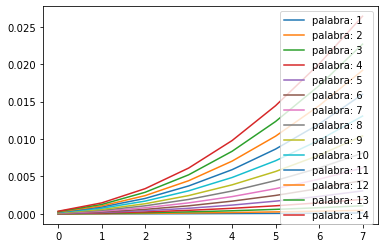

In [63]:
for i in range(14):
    plt.plot(data[i], label=f"resolucion: {i+1}")
    plt.legend()

In [3]:
df = pd.DataFrame(columns=['LP_bin', 'VD_bin'])

In [7]:
df.LP_bin = [0,0,0,0,0,0,0,0,0,0]
df.VD_bin = [0,0,0,0,0,0,0,0,0,0]

In [7]:
mutual_info_optimized(resolution(df, 100), ['LP_bin', 'VD_bin'], 1)

Entropia primera columna: 0.6383522843974425
Entropia segunda columna: 0.5003797555119865
Entropia conjunta: 1.1180052863560763


0.02072675355335285

In [9]:
mutual_info_optimized(resolution(df, 150), ['LP_bin', 'VD_bin'], 1)

Entropia primera columna: 0.7736364504765536
Entropia segunda columna: 0.6185150533286701
Entropia conjunta: 1.348515976071144


0.04363552773407964

In [10]:
df

,Unnamed: 0,LP,VD,LP_bin,VD_bin
0,0,0.004883,0.015259,0,0
1,1,0.001526,0.024109,0,0
2,2,-0.010681,0.031128,0,0
3,3,-0.022278,0.041809,0,0
4,4,-0.028076,0.045471,0,0
...,...,...,...,...,...
19847695,19847695,-0.005798,0.017395,0,0
19847696,19847696,-0.007019,0.024109,0,0
19847697,19847697,-0.000916,0.029602,0,0
19847698,19847698,0.007324,0.039368,0,0


(0.0, 2000.0)

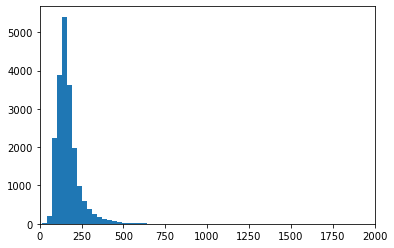

In [37]:
w = df.index[df.VD_bin > 0]
w = w[1:] - w[:-1]
plt.hist(w,bins=1000)
plt.xlim((0, 2000))

In [17]:
w

Int64Index([  97,  111,  130,  133,  135,  125,  156,  147,  132,  186,
            ...
             200,  214,  227,  500, 4951,  111,  154,  171,  178,  359],
           dtype='int64', length=32352)

In [ ]:
w = df.index[df.LP_bin > 0]

In [18]:
pd.Series(w).reindex()

0         97
1        111
2        130
3        133
4        135
        ... 
32347    111
32348    154
32349    171
32350    178
32351    359
Length: 32352, dtype: int64

In [38]:
threshold = 1000
w = df.index[df.LP_bin > 0]
w = (w[1:] - w[:-1]).to_list()
w.insert(0, np.inf)
df["distance"] = 0
df.loc[df.LP_bin > 0, "distance"] = w
df["LP2_bin"] = 0
df.loc[df.distance > threshold, "LP2_bin"] = 1

w = df.index[df.VD_bin > 0]
w = (w[1:] - w[:-1]).to_list()
w.insert(0, np.inf)
df["distance"] = 0
df.loc[df.VD_bin > 0, "distance"] = w
df["VD2_bin"] = 0
df.loc[df.distance > threshold, "VD2_bin"] = 1

In [40]:
df["VD2_bin"].sum()

1960

In [ ]:

df2 = get_bursts(df, 1000, ["LP_bin", "VD_bin"], ["LP_burst", "VD_burst"])


In [27]:
len(df.loc[df.LP_bin > 0, "distance"])

32353

In [32]:
df[df.LP_bin > 0]

,LP_bin,VD_bin,joined,distance
2878,1,0,1000,inf
2975,1,0,1000,97.0
3086,1,0,1000,111.0
3216,1,0,1000,130.0
3349,1,0,1000,133.0
...,...,...,...,...
19843981,1,0,1000,111.0
19844135,1,0,1000,154.0
19844306,1,0,1000,171.0
19844484,1,0,1000,178.0


In [29]:
w

Int64Index([  97,  111,  130,  133,  135,  125,  156,  147,  132,  186,
            ...
             200,  214,  227,  500, 4951,  111,  154,  171,  178,  359],
           dtype='int64', length=32352)

In [15]:
transfer_info(resolution(df,100), ['LP_bin', 'VD_bin'], 4)

Entropia primera columna: 2.02324110933116
Entropia segunda columna: 1.5134710660487392
Entropia conjunta: 3.4481154575867468


([0.043789500610948426, 0.05853875887066326],
 0.08859671779315281,
 [2.02324110933116, 1.5134710660487392],
 3.4481154575867468)

In [11]:
a = [1,2]

In [12]:
reversed(a)

In [13]:
for i in reversed(a):
    print(i)

2
1


In [23]:
a.insert(0,np.inf)

In [24]:
a

[inf, 10000, 1, 2]

In [6]:
col_names = [f"word_len {i}" for i in range(10)]
row_names = [f"resolution {i}" for i in range(10)]
data = {
    "transfer_info_col1_col2" : pd.DataFrame(columns = col_names, index = row_names),
    "mutual_info" : pd.DataFrame(columns = col_names, index = row_names),
    "col1_entropy" : pd.DataFrame(columns = col_names, index = row_names),
    "col2_entropy" : pd.DataFrame(columns = col_names, index = row_names),
    "joined_entropy" : pd.DataFrame(columns = col_names, index = row_names)
}
data["transfer_info_col1_col2"][:] = 0

In [7]:
data

{'transfer_info_col1_col2':              word_len 0 word_len 1 word_len 2 word_len 3 word_len 4  \
 resolution 0          0          0          0          0          0   
 resolution 1          0          0          0          0          0   
 resolution 2          0          0          0          0          0   
 resolution 3          0          0          0          0          0   
 resolution 4          0          0          0          0          0   
 resolution 5          0          0          0          0          0   
 resolution 6          0          0          0          0          0   
 resolution 7          0          0          0          0          0   
 resolution 8          0          0          0          0          0   
 resolution 9          0          0          0          0          0   
 
              word_len 5 word_len 6 word_len 7 word_len 8 word_len 9  
 resolution 0          0          0          0          0          0  
 resolution 1          0          0  